In [1]:
# increase default window size for notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\s.kaiser\AppData\Local\Temp\ipykernel_15084\696421802.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Set reproducible results by random seeding, answer from here: https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds

# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K

# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
K.set_session(sess)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import timeit
from datetime import timedelta
from dataclasses import dataclass       # C like structure
import glob                             # finds all the pathnames matching specified pattern
import datetime as dt
import random
!python --version
print('pandas version: ' + pd.__version__)
print('numpy version: ' + np.__version__)

Python 3.9.7
pandas version: 1.4.2
numpy version: 1.21.5


In [4]:
import sys, os
cwd = sys.path[0]
sys.path.append(os.path.join(cwd, 'my_modules'))                # sys.path[0] is dir of the ipynb file
import custom_plot
import data_clean
import data_preprocess
import constants

imported custom_plot.py
data_clean imported
data_preprocess imported


In [5]:
%matplotlib notebook
# Plot related packages,%matplotlib notebook makes plots in jupyter interactive
# constants for plotting
x_label_elapsedtime = 0
x_label_datetime = 1

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [7]:
# Load processed data (phase 1)

dir_path = os.path.join(cwd, 'csv')
filename = 'cell_cycles.pkl'

# load last saved df from phase1 data and convert time stamp and sort
li_ts_cycles_ph1 = data_preprocess.load_object(dir_path, filename)

In [8]:
# Load processed data (phase 2)
dir_path = os.path.join(cwd, 'csv', 'phase_2_pkl')
filename = 'mod1_cell_cycles.pkl'
li_ts_cycles_ph2 = data_preprocess.load_object(dir_path, filename)

In [9]:
# Combine phase1 and phase 2 data
import math

# for x, y in li_ts_cycles_ph1:
#     print('phase1 cells', x, y)
    
# for x, y in li_ts_cycles_ph2:
#     print('phase2 cells', len(y))

combined_phase_cycles = []
if len(li_ts_cycles_ph1) <= len(li_ts_cycles_ph2):
    for i in range(len(li_ts_cycles_ph1)):              # each cell contain multiple cycles
        c_1, cycles_1 = li_ts_cycles_ph1[i]                 # for example, (v1, [cycles])
        c_2, cycles_2 = li_ts_cycles_ph2[i]
        if (c_2 == c_1):
            cycles_1 += cycles_2                        # this adds cycle to li_ts_cycles_ph1
    combined_phase_cycles = li_ts_cycles_ph1
else:
    for i in range(len(li_ts_cycles_ph2)):              # each cell contain multiple cycles
        c_2, cycles_2 = li_ts_cycles_ph2[i]
        c_1, cycles_1 = li_ts_cycles_ph1[i]
        if (c_2 == c_1):
            cycles_2 += cycles_1                        # this adds cycle to li_ts_cycles
    combined_phase_cycles = li_ts_cycles_ph2


for x, y in combined_phase_cycles:
    print('combined cells', x)

combined cells V1
combined cells V2
combined cells V3
combined cells V4
combined cells V5
combined cells V6
combined cells V7
combined cells V8
combined cells V9
combined cells V10
combined cells V11
combined cells V12


In [10]:
import math

# Separate training, validation and test cycles, keep cycles without cell ID
TRAIN_SAMPLES = 0.9
li_train_cycles = []      # each of this list is a separate static_dynamic_static cycle
# li_validation_cycles = []
li_test_cycles= []
counter = 0

total_cycles = 0
for (c, li_cycles) in combined_phase_cycles:              # each cell contain multiple cycles
    counter += 1
    num_cell_cycles = len(li_cycles)
    num_train_cycles = math.floor(num_cell_cycles * TRAIN_SAMPLES)                 # training cycle samples 70%
    # num_validation_cycles = math.ceil((num_cell_cycles - num_train_cycles) * 0.5)
    # num_test_cycles = num_cell_cycles - num_validation_cycles - num_train_cycles
    num_test_cycles = num_cell_cycles - num_train_cycles
    total_cycles += len(li_cycles)
    # print(num_cell_cycles, num_train_cycles, num_validation_cycles, num_test_cycles)

    li_train_cycles += li_cycles[0:num_train_cycles]
    # li_validation_cycles += li_cycles[num_train_cycles:num_train_cycles+num_validation_cycles]
    # li_test_cycles += li_cycles[num_train_cycles+num_validation_cycles:]
    li_test_cycles += li_cycles[num_train_cycles:]
    break

print(total_cycles, len(li_train_cycles), len(li_test_cycles))     # test

17 15 2


### Remove the beginning static voltage for training and test data as it can be misleading to the model

In [11]:

for (i,df) in enumerate(li_train_cycles):
    iloc_cntr_on = (df['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
    df = df.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
    li_train_cycles[i] = df

for (i,df) in enumerate(li_test_cycles):
    iloc_cntr_on = (df['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
    df = df.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
    li_test_cycles[i] = df
    
print(total_cycles, len(li_train_cycles), len(li_test_cycles))     # test

17 15 2


<IPython.core.display.Javascript object>


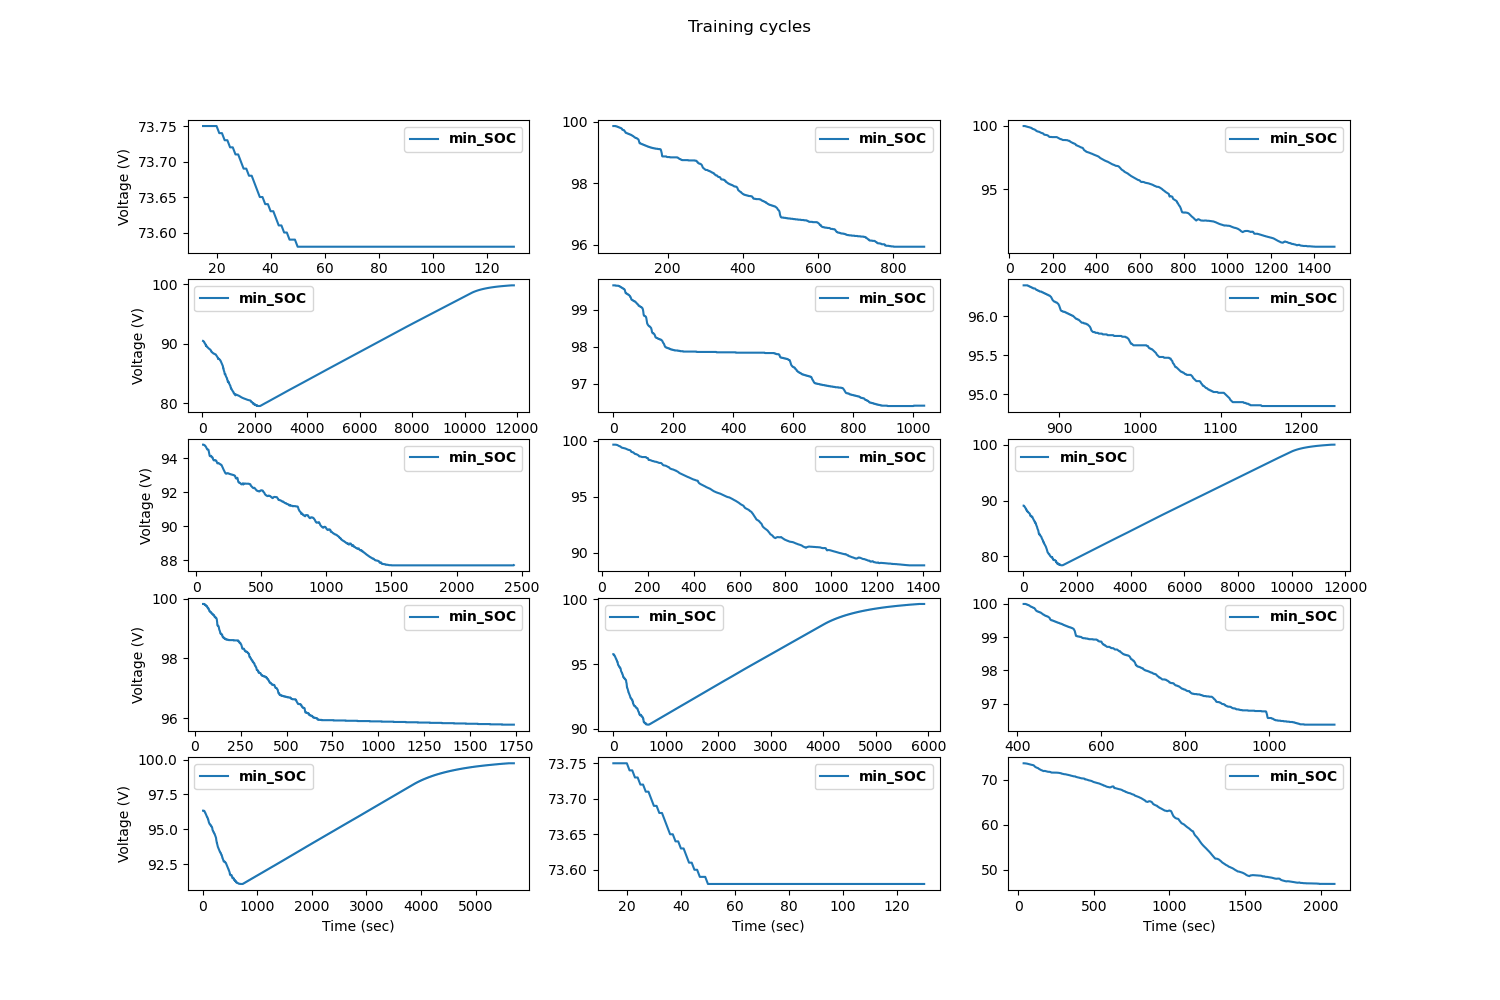

i:  0   j:  0
i:  0   j:  1
i:  0   j:  2
i:  1   j:  0
i:  1   j:  1
i:  1   j:  2
i:  2   j:  0
i:  2   j:  1
i:  2   j:  2
i:  3   j:  0
i:  3   j:  1
i:  3   j:  2
i:  4   j:  0
i:  4   j:  1
i:  4   j:  2


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


In [13]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set save path for plot
fig_path = os.path.join(cwd, 'figures')
plot_path = os.path.join(fig_path, 'train_cycles_voltages.pdf')

cols = 3
total_train_cycles = len(li_train_cycles)
rows = math.ceil(total_train_cycles / cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)

i = -1        # row index
j = 0        # col index
# Plot multiple train cycles voltages
for df in li_train_cycles:
    if (j % cols == 0):
        j = 0
        i += 1     # first entrance makes i = 0
    print('i: ', i, '  j: ', j)
    df_each = df.copy()
    df_each.plot(x='elapsed_sec', y='min_SOC', ax = axes[i][j], title='Training cycles', subplots=True)
#     ax.set_title(f'Title {i}')
    j += 1

# set labels
plt.setp(axes[-1, :], xlabel='Time (sec)')
plt.setp(axes[:, 0], ylabel='Voltage (V)')
plt.show()
plt.savefig(plot_path)

### univariate: current to voltage mapping

In [59]:
# Make dataset ready for LSTM
# [temporal input sequence] [output]
# example:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_supervised_univariate(df_feature, df_label, window_size=1):
    df_feature_as_np = df_feature.to_numpy()
    df_label_as_np = df_label.to_numpy()
    X = []
    y = []
    total_rows = len(df_feature_as_np) - window_size + 1
    for i in range(len(df_feature_as_np) - window_size):
        row = [[a] for a in df_feature_as_np[i:i+window_size]]
        X.append(row)
        label = df_label_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [60]:
TIMESTEPS = 3
# One sample only
df = li_train_cycles[2].copy()

# reverse data before training, for test
# df = df.iloc[::-1]
df1 = df.loc[df['contactor_state'] == 2]               # take only dynamic voltage
print(len(df1))

X, y = df_to_supervised_univariate(df1['current'], df1['V'], TIMESTEPS)     # prepare sequences for each cycle
print(X.shape, y.shape)

1376
(1373, 3, 1) (1373,)


In [62]:
NUM_EPOCHS = 2000
NUM_NEURONS = 64

def simple_LSTM(path, train_X, train_y, iteration_no, num_neurons=32, dropout=0):
    # Seeds
    tf.keras.backend.clear_session()
    seed_value= 0
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    K.set_session(sess)

    model = Sequential()
    model.add(LSTM(num_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))   # no use of batch because stateless, input shape=(#samples, #fatures)
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    model.summary()

    # save_best_only=true saves the best model with lowest validation loss
    model_path = os.path.join(path, 'model' + str(iteration_no) + '.h5')
    my_callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=100,verbose=0,mode='min'),  # minimize validation loss
        tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True)
    ]

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

    # measuers performance on every epoch on the validation dataset
    # calls back checkpoint after every epoch and saves model if validation loss is lower than before
    # history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=nb_epoch, callbacks=callback_list)

    history = model.fit(train_X, train_y, epochs=NUM_EPOCHS, verbose=2, shuffle=False, validation_split=0.20, callbacks=my_callbacks)
    data_preprocess.save_object(history, path, 'history' + str(iteration_no) + '.pkl')    # save history

# Train Generic RNN model
model_path = os.path.join(cwd, 'generalized', 'LSTM')
simple_LSTM(model_path, X, y, 'more_epochs', NUM_NEURONS, 0)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
35/35 - 1s - loss: 16.8162 - mean_absolute_error: 4.0995 - val_loss: 16.1358 - val_mean_absolute_error: 4.0154 - 1s/epoch - 35ms/step
Epoch 2/2000
35/35 - 0s - loss: 16.2642 - mean_absolute_error: 4.0321 - val_loss: 15.7486 - val_mean_absolute_error: 3.9675 - 103ms/epoch - 3ms/step
Epoch 3/2000
35/35 -

35/35 - 0s - loss: 0.3075 - mean_absolute_error: 0.2555 - val_loss: 1.0288 - val_mean_absolute_error: 0.5845 - 111ms/epoch - 3ms/step
Epoch 52/2000
35/35 - 0s - loss: 0.2946 - mean_absolute_error: 0.2496 - val_loss: 0.9927 - val_mean_absolute_error: 0.5734 - 110ms/epoch - 3ms/step
Epoch 53/2000
35/35 - 0s - loss: 0.2824 - mean_absolute_error: 0.2442 - val_loss: 0.9580 - val_mean_absolute_error: 0.5629 - 109ms/epoch - 3ms/step
Epoch 54/2000
35/35 - 0s - loss: 0.2708 - mean_absolute_error: 0.2389 - val_loss: 0.9246 - val_mean_absolute_error: 0.5527 - 111ms/epoch - 3ms/step
Epoch 55/2000
35/35 - 0s - loss: 0.2598 - mean_absolute_error: 0.2340 - val_loss: 0.8925 - val_mean_absolute_error: 0.5426 - 100ms/epoch - 3ms/step
Epoch 56/2000
35/35 - 0s - loss: 0.2494 - mean_absolute_error: 0.2294 - val_loss: 0.8615 - val_mean_absolute_error: 0.5325 - 108ms/epoch - 3ms/step
Epoch 57/2000
35/35 - 0s - loss: 0.2394 - mean_absolute_error: 0.2250 - val_loss: 0.8315 - val_mean_absolute_error: 0.5225 - 1

Epoch 107/2000
35/35 - 0s - loss: 0.0383 - mean_absolute_error: 0.1043 - val_loss: 0.1214 - val_mean_absolute_error: 0.2150 - 96ms/epoch - 3ms/step
Epoch 108/2000
35/35 - 0s - loss: 0.0371 - mean_absolute_error: 0.1029 - val_loss: 0.1161 - val_mean_absolute_error: 0.2105 - 102ms/epoch - 3ms/step
Epoch 109/2000
35/35 - 0s - loss: 0.0359 - mean_absolute_error: 0.1016 - val_loss: 0.1109 - val_mean_absolute_error: 0.2064 - 98ms/epoch - 3ms/step
Epoch 110/2000
35/35 - 0s - loss: 0.0347 - mean_absolute_error: 0.1003 - val_loss: 0.1060 - val_mean_absolute_error: 0.2022 - 105ms/epoch - 3ms/step
Epoch 111/2000
35/35 - 0s - loss: 0.0335 - mean_absolute_error: 0.0991 - val_loss: 0.1012 - val_mean_absolute_error: 0.1980 - 101ms/epoch - 3ms/step
Epoch 112/2000
35/35 - 0s - loss: 0.0325 - mean_absolute_error: 0.0980 - val_loss: 0.0966 - val_mean_absolute_error: 0.1940 - 102ms/epoch - 3ms/step
Epoch 113/2000
35/35 - 0s - loss: 0.0314 - mean_absolute_error: 0.0968 - val_loss: 0.0922 - val_mean_absolut

Epoch 163/2000
35/35 - 0s - loss: 0.0084 - mean_absolute_error: 0.0617 - val_loss: 0.0093 - val_mean_absolute_error: 0.0613 - 98ms/epoch - 3ms/step
Epoch 164/2000
35/35 - 0s - loss: 0.0081 - mean_absolute_error: 0.0610 - val_loss: 0.0091 - val_mean_absolute_error: 0.0603 - 93ms/epoch - 3ms/step
Epoch 165/2000
35/35 - 0s - loss: 0.0080 - mean_absolute_error: 0.0611 - val_loss: 0.0089 - val_mean_absolute_error: 0.0599 - 99ms/epoch - 3ms/step
Epoch 166/2000
35/35 - 0s - loss: 0.0078 - mean_absolute_error: 0.0604 - val_loss: 0.0087 - val_mean_absolute_error: 0.0591 - 94ms/epoch - 3ms/step
Epoch 167/2000
35/35 - 0s - loss: 0.0077 - mean_absolute_error: 0.0605 - val_loss: 0.0086 - val_mean_absolute_error: 0.0588 - 118ms/epoch - 3ms/step
Epoch 168/2000
35/35 - 0s - loss: 0.0075 - mean_absolute_error: 0.0599 - val_loss: 0.0084 - val_mean_absolute_error: 0.0580 - 100ms/epoch - 3ms/step
Epoch 169/2000
35/35 - 0s - loss: 0.0074 - mean_absolute_error: 0.0599 - val_loss: 0.0084 - val_mean_absolute_

Epoch 219/2000
35/35 - 0s - loss: 0.0042 - mean_absolute_error: 0.0506 - val_loss: 0.0084 - val_mean_absolute_error: 0.0618 - 85ms/epoch - 2ms/step
Epoch 220/2000
35/35 - 0s - loss: 0.0042 - mean_absolute_error: 0.0506 - val_loss: 0.0084 - val_mean_absolute_error: 0.0617 - 88ms/epoch - 3ms/step
Epoch 221/2000
35/35 - 0s - loss: 0.0041 - mean_absolute_error: 0.0505 - val_loss: 0.0083 - val_mean_absolute_error: 0.0615 - 91ms/epoch - 3ms/step
Epoch 222/2000
35/35 - 0s - loss: 0.0041 - mean_absolute_error: 0.0505 - val_loss: 0.0083 - val_mean_absolute_error: 0.0613 - 93ms/epoch - 3ms/step
Epoch 223/2000
35/35 - 0s - loss: 0.0041 - mean_absolute_error: 0.0504 - val_loss: 0.0083 - val_mean_absolute_error: 0.0611 - 82ms/epoch - 2ms/step
Epoch 224/2000
35/35 - 0s - loss: 0.0041 - mean_absolute_error: 0.0503 - val_loss: 0.0082 - val_mean_absolute_error: 0.0609 - 81ms/epoch - 2ms/step
Epoch 225/2000
35/35 - 0s - loss: 0.0041 - mean_absolute_error: 0.0502 - val_loss: 0.0082 - val_mean_absolute_er

Epoch 275/2000
35/35 - 0s - loss: 0.0034 - mean_absolute_error: 0.0472 - val_loss: 0.0064 - val_mean_absolute_error: 0.0519 - 97ms/epoch - 3ms/step
Epoch 276/2000
35/35 - 0s - loss: 0.0034 - mean_absolute_error: 0.0472 - val_loss: 0.0064 - val_mean_absolute_error: 0.0517 - 94ms/epoch - 3ms/step
Epoch 277/2000
35/35 - 0s - loss: 0.0034 - mean_absolute_error: 0.0471 - val_loss: 0.0063 - val_mean_absolute_error: 0.0516 - 118ms/epoch - 3ms/step
Epoch 278/2000
35/35 - 0s - loss: 0.0034 - mean_absolute_error: 0.0471 - val_loss: 0.0063 - val_mean_absolute_error: 0.0514 - 106ms/epoch - 3ms/step
Epoch 279/2000
35/35 - 0s - loss: 0.0034 - mean_absolute_error: 0.0470 - val_loss: 0.0063 - val_mean_absolute_error: 0.0512 - 99ms/epoch - 3ms/step
Epoch 280/2000
35/35 - 0s - loss: 0.0033 - mean_absolute_error: 0.0469 - val_loss: 0.0062 - val_mean_absolute_error: 0.0511 - 102ms/epoch - 3ms/step
Epoch 281/2000
35/35 - 0s - loss: 0.0033 - mean_absolute_error: 0.0469 - val_loss: 0.0062 - val_mean_absolute

Epoch 331/2000
35/35 - 0s - loss: 0.0030 - mean_absolute_error: 0.0447 - val_loss: 0.0045 - val_mean_absolute_error: 0.0435 - 102ms/epoch - 3ms/step
Epoch 332/2000
35/35 - 0s - loss: 0.0030 - mean_absolute_error: 0.0447 - val_loss: 0.0045 - val_mean_absolute_error: 0.0435 - 107ms/epoch - 3ms/step
Epoch 333/2000
35/35 - 0s - loss: 0.0030 - mean_absolute_error: 0.0447 - val_loss: 0.0045 - val_mean_absolute_error: 0.0433 - 109ms/epoch - 3ms/step
Epoch 334/2000
35/35 - 0s - loss: 0.0030 - mean_absolute_error: 0.0446 - val_loss: 0.0044 - val_mean_absolute_error: 0.0432 - 105ms/epoch - 3ms/step
Epoch 335/2000
35/35 - 0s - loss: 0.0030 - mean_absolute_error: 0.0446 - val_loss: 0.0044 - val_mean_absolute_error: 0.0430 - 104ms/epoch - 3ms/step
Epoch 336/2000
35/35 - 0s - loss: 0.0030 - mean_absolute_error: 0.0445 - val_loss: 0.0044 - val_mean_absolute_error: 0.0430 - 97ms/epoch - 3ms/step
Epoch 337/2000
35/35 - 0s - loss: 0.0030 - mean_absolute_error: 0.0445 - val_loss: 0.0043 - val_mean_absolu

Epoch 387/2000
35/35 - 0s - loss: 0.0028 - mean_absolute_error: 0.0430 - val_loss: 0.0032 - val_mean_absolute_error: 0.0376 - 98ms/epoch - 3ms/step
Epoch 388/2000
35/35 - 0s - loss: 0.0028 - mean_absolute_error: 0.0430 - val_loss: 0.0032 - val_mean_absolute_error: 0.0375 - 100ms/epoch - 3ms/step
Epoch 389/2000
35/35 - 0s - loss: 0.0028 - mean_absolute_error: 0.0430 - val_loss: 0.0032 - val_mean_absolute_error: 0.0375 - 105ms/epoch - 3ms/step
Epoch 390/2000
35/35 - 0s - loss: 0.0028 - mean_absolute_error: 0.0429 - val_loss: 0.0032 - val_mean_absolute_error: 0.0373 - 98ms/epoch - 3ms/step
Epoch 391/2000
35/35 - 0s - loss: 0.0028 - mean_absolute_error: 0.0429 - val_loss: 0.0032 - val_mean_absolute_error: 0.0373 - 98ms/epoch - 3ms/step
Epoch 392/2000
35/35 - 0s - loss: 0.0028 - mean_absolute_error: 0.0429 - val_loss: 0.0032 - val_mean_absolute_error: 0.0372 - 99ms/epoch - 3ms/step
Epoch 393/2000
35/35 - 0s - loss: 0.0028 - mean_absolute_error: 0.0429 - val_loss: 0.0031 - val_mean_absolute_

Epoch 443/2000
35/35 - 0s - loss: 0.0027 - mean_absolute_error: 0.0418 - val_loss: 0.0027 - val_mean_absolute_error: 0.0346 - 110ms/epoch - 3ms/step
Epoch 444/2000
35/35 - 0s - loss: 0.0027 - mean_absolute_error: 0.0419 - val_loss: 0.0027 - val_mean_absolute_error: 0.0347 - 90ms/epoch - 3ms/step
Epoch 445/2000
35/35 - 0s - loss: 0.0027 - mean_absolute_error: 0.0418 - val_loss: 0.0026 - val_mean_absolute_error: 0.0345 - 104ms/epoch - 3ms/step
Epoch 446/2000
35/35 - 0s - loss: 0.0027 - mean_absolute_error: 0.0418 - val_loss: 0.0027 - val_mean_absolute_error: 0.0346 - 88ms/epoch - 3ms/step
Epoch 447/2000
35/35 - 0s - loss: 0.0027 - mean_absolute_error: 0.0418 - val_loss: 0.0026 - val_mean_absolute_error: 0.0345 - 95ms/epoch - 3ms/step
Epoch 448/2000
35/35 - 0s - loss: 0.0027 - mean_absolute_error: 0.0418 - val_loss: 0.0027 - val_mean_absolute_error: 0.0346 - 89ms/epoch - 3ms/step
Epoch 449/2000
35/35 - 0s - loss: 0.0027 - mean_absolute_error: 0.0418 - val_loss: 0.0026 - val_mean_absolute_

Epoch 499/2000
35/35 - 0s - loss: 0.0025 - mean_absolute_error: 0.0403 - val_loss: 0.0024 - val_mean_absolute_error: 0.0330 - 110ms/epoch - 3ms/step
Epoch 500/2000
35/35 - 0s - loss: 0.0025 - mean_absolute_error: 0.0402 - val_loss: 0.0024 - val_mean_absolute_error: 0.0330 - 108ms/epoch - 3ms/step
Epoch 501/2000
35/35 - 0s - loss: 0.0025 - mean_absolute_error: 0.0402 - val_loss: 0.0024 - val_mean_absolute_error: 0.0330 - 85ms/epoch - 2ms/step
Epoch 502/2000
35/35 - 0s - loss: 0.0025 - mean_absolute_error: 0.0402 - val_loss: 0.0024 - val_mean_absolute_error: 0.0330 - 92ms/epoch - 3ms/step
Epoch 503/2000
35/35 - 0s - loss: 0.0025 - mean_absolute_error: 0.0402 - val_loss: 0.0024 - val_mean_absolute_error: 0.0331 - 91ms/epoch - 3ms/step
Epoch 504/2000
35/35 - 0s - loss: 0.0025 - mean_absolute_error: 0.0402 - val_loss: 0.0024 - val_mean_absolute_error: 0.0331 - 96ms/epoch - 3ms/step
Epoch 505/2000
35/35 - 0s - loss: 0.0025 - mean_absolute_error: 0.0402 - val_loss: 0.0024 - val_mean_absolute_

Epoch 555/2000
35/35 - 0s - loss: 0.0025 - mean_absolute_error: 0.0403 - val_loss: 0.0025 - val_mean_absolute_error: 0.0343 - 98ms/epoch - 3ms/step
Epoch 556/2000
35/35 - 0s - loss: 0.0024 - mean_absolute_error: 0.0403 - val_loss: 0.0025 - val_mean_absolute_error: 0.0343 - 98ms/epoch - 3ms/step
Epoch 557/2000
35/35 - 0s - loss: 0.0024 - mean_absolute_error: 0.0403 - val_loss: 0.0025 - val_mean_absolute_error: 0.0344 - 92ms/epoch - 3ms/step
Epoch 558/2000
35/35 - 0s - loss: 0.0024 - mean_absolute_error: 0.0403 - val_loss: 0.0025 - val_mean_absolute_error: 0.0344 - 84ms/epoch - 2ms/step
Epoch 559/2000
35/35 - 0s - loss: 0.0024 - mean_absolute_error: 0.0403 - val_loss: 0.0025 - val_mean_absolute_error: 0.0344 - 87ms/epoch - 2ms/step
Epoch 560/2000
35/35 - 0s - loss: 0.0024 - mean_absolute_error: 0.0402 - val_loss: 0.0025 - val_mean_absolute_error: 0.0344 - 83ms/epoch - 2ms/step
Epoch 561/2000
35/35 - 0s - loss: 0.0024 - mean_absolute_error: 0.0402 - val_loss: 0.0025 - val_mean_absolute_er

INFO:tensorflow:Assets written to: ram://8df1860d-9163-4f34-8c26-45913427f7b3/assets


INFO:tensorflow:Assets written to: ram://8df1860d-9163-4f34-8c26-45913427f7b3/assets


In [58]:
def conv1D(path, train_X, train_y, iteration_no, num_neurons=32, dropout=0):
    # Seeds
    tf.keras.backend.clear_session()
    seed_value= 0
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    K.set_session(sess)

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))

    # save_best_only=true saves the best model with lowest validation loss
    model_path = os.path.join(path, 'model' + str(iteration_no) + '.h5')
    my_callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=0,mode='min'),  # minimize validation loss
        tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True)
    ]

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

    # measuers performance on every epoch on the validation dataset
    # calls back checkpoint after every epoch and saves model if validation loss is lower than before
    # history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=nb_epoch, callbacks=callback_list)

    history = model.fit(train_X, train_y, epochs=NUM_EPOCHS, verbose=2, shuffle=False, validation_split=0.20, callbacks=my_callbacks)
    data_preprocess.save_object(history, path, 'history' + str(iteration_no) + '.pkl')    # save history

# Train Generic RNN model
model_path = os.path.join(cwd, 'conv', 'univar_single_cycle')
conv1D(model_path, X, y, 'conv1d', NUM_NEURONS, 0)

Epoch 1/2000
35/35 - 0s - loss: 18.8188 - mean_absolute_error: 2.7324 - val_loss: 7.4903 - val_mean_absolute_error: 2.3480 - 334ms/epoch - 10ms/step
Epoch 2/2000
35/35 - 0s - loss: 11.4715 - mean_absolute_error: 2.3712 - val_loss: 7.8761 - val_mean_absolute_error: 2.5152 - 55ms/epoch - 2ms/step
Epoch 3/2000
35/35 - 0s - loss: 8.8888 - mean_absolute_error: 2.3080 - val_loss: 8.3040 - val_mean_absolute_error: 2.6612 - 52ms/epoch - 1ms/step
Epoch 4/2000
35/35 - 0s - loss: 7.9548 - mean_absolute_error: 2.3249 - val_loss: 8.5747 - val_mean_absolute_error: 2.7447 - 44ms/epoch - 1ms/step
Epoch 5/2000
35/35 - 0s - loss: 7.6322 - mean_absolute_error: 2.3430 - val_loss: 8.6572 - val_mean_absolute_error: 2.7784 - 47ms/epoch - 1ms/step
Epoch 6/2000
35/35 - 0s - loss: 7.4746 - mean_absolute_error: 2.3447 - val_loss: 8.6284 - val_mean_absolute_error: 2.7840 - 43ms/epoch - 1ms/step
Epoch 7/2000
35/35 - 0s - loss: 7.3488 - mean_absolute_error: 2.3344 - val_loss: 8.5494 - val_mean_absolute_error: 2.774

Epoch 57/2000
35/35 - 0s - loss: 3.6137 - mean_absolute_error: 1.6324 - val_loss: 4.3769 - val_mean_absolute_error: 1.9804 - 53ms/epoch - 2ms/step
Epoch 58/2000
35/35 - 0s - loss: 3.5443 - mean_absolute_error: 1.6168 - val_loss: 4.3078 - val_mean_absolute_error: 1.9662 - 56ms/epoch - 2ms/step
Epoch 59/2000
35/35 - 0s - loss: 3.4657 - mean_absolute_error: 1.6001 - val_loss: 4.1925 - val_mean_absolute_error: 1.9383 - 55ms/epoch - 2ms/step
Epoch 60/2000
35/35 - 0s - loss: 3.4057 - mean_absolute_error: 1.5780 - val_loss: 4.1187 - val_mean_absolute_error: 1.9239 - 55ms/epoch - 2ms/step
Epoch 61/2000
35/35 - 0s - loss: 3.3478 - mean_absolute_error: 1.5553 - val_loss: 4.0755 - val_mean_absolute_error: 1.9189 - 54ms/epoch - 2ms/step
Epoch 62/2000
35/35 - 0s - loss: 3.2311 - mean_absolute_error: 1.5416 - val_loss: 3.9335 - val_mean_absolute_error: 1.8809 - 54ms/epoch - 2ms/step
Epoch 63/2000
35/35 - 0s - loss: 3.1397 - mean_absolute_error: 1.5133 - val_loss: 3.8475 - val_mean_absolute_error: 1.

Epoch 113/2000
35/35 - 0s - loss: 0.3636 - mean_absolute_error: 0.4789 - val_loss: 0.4746 - val_mean_absolute_error: 0.6165 - 56ms/epoch - 2ms/step
Epoch 114/2000
35/35 - 0s - loss: 0.3403 - mean_absolute_error: 0.4618 - val_loss: 0.4467 - val_mean_absolute_error: 0.5959 - 55ms/epoch - 2ms/step
Epoch 115/2000
35/35 - 0s - loss: 0.3205 - mean_absolute_error: 0.4458 - val_loss: 0.4208 - val_mean_absolute_error: 0.5761 - 65ms/epoch - 2ms/step
Epoch 116/2000
35/35 - 0s - loss: 0.3001 - mean_absolute_error: 0.4292 - val_loss: 0.3933 - val_mean_absolute_error: 0.5536 - 59ms/epoch - 2ms/step
Epoch 117/2000
35/35 - 0s - loss: 0.2800 - mean_absolute_error: 0.4120 - val_loss: 0.3685 - val_mean_absolute_error: 0.5331 - 58ms/epoch - 2ms/step
Epoch 118/2000
35/35 - 0s - loss: 0.2619 - mean_absolute_error: 0.3965 - val_loss: 0.3442 - val_mean_absolute_error: 0.5117 - 58ms/epoch - 2ms/step
Epoch 119/2000
35/35 - 0s - loss: 0.2431 - mean_absolute_error: 0.3784 - val_loss: 0.3245 - val_mean_absolute_er

Epoch 169/2000
35/35 - 0s - loss: 0.0382 - mean_absolute_error: 0.1250 - val_loss: 0.0591 - val_mean_absolute_error: 0.1661 - 64ms/epoch - 2ms/step
Epoch 170/2000
35/35 - 0s - loss: 0.0375 - mean_absolute_error: 0.1232 - val_loss: 0.0581 - val_mean_absolute_error: 0.1642 - 60ms/epoch - 2ms/step
Epoch 171/2000
35/35 - 0s - loss: 0.0372 - mean_absolute_error: 0.1236 - val_loss: 0.0574 - val_mean_absolute_error: 0.1641 - 53ms/epoch - 2ms/step
Epoch 172/2000
35/35 - 0s - loss: 0.0366 - mean_absolute_error: 0.1219 - val_loss: 0.0564 - val_mean_absolute_error: 0.1623 - 60ms/epoch - 2ms/step
Epoch 173/2000
35/35 - 0s - loss: 0.0363 - mean_absolute_error: 0.1221 - val_loss: 0.0557 - val_mean_absolute_error: 0.1620 - 66ms/epoch - 2ms/step
Epoch 174/2000
35/35 - 0s - loss: 0.0357 - mean_absolute_error: 0.1206 - val_loss: 0.0548 - val_mean_absolute_error: 0.1603 - 64ms/epoch - 2ms/step
Epoch 175/2000
35/35 - 0s - loss: 0.0355 - mean_absolute_error: 0.1210 - val_loss: 0.0542 - val_mean_absolute_er

Epoch 225/2000
35/35 - 0s - loss: 0.0199 - mean_absolute_error: 0.0927 - val_loss: 0.0302 - val_mean_absolute_error: 0.1241 - 71ms/epoch - 2ms/step
Epoch 226/2000
35/35 - 0s - loss: 0.0198 - mean_absolute_error: 0.0930 - val_loss: 0.0300 - val_mean_absolute_error: 0.1240 - 69ms/epoch - 2ms/step
Epoch 227/2000
35/35 - 0s - loss: 0.0197 - mean_absolute_error: 0.0923 - val_loss: 0.0297 - val_mean_absolute_error: 0.1232 - 60ms/epoch - 2ms/step
Epoch 228/2000
35/35 - 0s - loss: 0.0197 - mean_absolute_error: 0.0923 - val_loss: 0.0296 - val_mean_absolute_error: 0.1230 - 58ms/epoch - 2ms/step
Epoch 229/2000
35/35 - 0s - loss: 0.0196 - mean_absolute_error: 0.0917 - val_loss: 0.0293 - val_mean_absolute_error: 0.1223 - 59ms/epoch - 2ms/step
Epoch 230/2000
35/35 - 0s - loss: 0.0191 - mean_absolute_error: 0.0908 - val_loss: 0.0290 - val_mean_absolute_error: 0.1209 - 63ms/epoch - 2ms/step
Epoch 231/2000
35/35 - 0s - loss: 0.0194 - mean_absolute_error: 0.0915 - val_loss: 0.0289 - val_mean_absolute_er

Epoch 281/2000
35/35 - 0s - loss: 0.0136 - mean_absolute_error: 0.0795 - val_loss: 0.0204 - val_mean_absolute_error: 0.0991 - 61ms/epoch - 2ms/step
Epoch 282/2000
35/35 - 0s - loss: 0.0137 - mean_absolute_error: 0.0799 - val_loss: 0.0204 - val_mean_absolute_error: 0.1000 - 48ms/epoch - 1ms/step
Epoch 283/2000
35/35 - 0s - loss: 0.0130 - mean_absolute_error: 0.0776 - val_loss: 0.0201 - val_mean_absolute_error: 0.0982 - 55ms/epoch - 2ms/step
Epoch 284/2000
35/35 - 0s - loss: 0.0138 - mean_absolute_error: 0.0796 - val_loss: 0.0203 - val_mean_absolute_error: 0.1000 - 51ms/epoch - 1ms/step
Epoch 285/2000
35/35 - 0s - loss: 0.0133 - mean_absolute_error: 0.0792 - val_loss: 0.0200 - val_mean_absolute_error: 0.0977 - 59ms/epoch - 2ms/step
Epoch 286/2000
35/35 - 0s - loss: 0.0136 - mean_absolute_error: 0.0802 - val_loss: 0.0201 - val_mean_absolute_error: 0.0990 - 50ms/epoch - 1ms/step
Epoch 287/2000
35/35 - 0s - loss: 0.0128 - mean_absolute_error: 0.0774 - val_loss: 0.0198 - val_mean_absolute_er

Epoch 337/2000
35/35 - 0s - loss: 0.0102 - mean_absolute_error: 0.0715 - val_loss: 0.0155 - val_mean_absolute_error: 0.0839 - 57ms/epoch - 2ms/step
Epoch 338/2000
35/35 - 0s - loss: 0.0106 - mean_absolute_error: 0.0724 - val_loss: 0.0155 - val_mean_absolute_error: 0.0847 - 63ms/epoch - 2ms/step
Epoch 339/2000
35/35 - 0s - loss: 0.0108 - mean_absolute_error: 0.0730 - val_loss: 0.0154 - val_mean_absolute_error: 0.0836 - 57ms/epoch - 2ms/step
Epoch 340/2000
35/35 - 0s - loss: 0.0106 - mean_absolute_error: 0.0735 - val_loss: 0.0155 - val_mean_absolute_error: 0.0842 - 45ms/epoch - 1ms/step
Epoch 341/2000
35/35 - 0s - loss: 0.0103 - mean_absolute_error: 0.0717 - val_loss: 0.0154 - val_mean_absolute_error: 0.0835 - 61ms/epoch - 2ms/step
Epoch 342/2000
35/35 - 0s - loss: 0.0102 - mean_absolute_error: 0.0712 - val_loss: 0.0152 - val_mean_absolute_error: 0.0834 - 70ms/epoch - 2ms/step
Epoch 343/2000
35/35 - 0s - loss: 0.0109 - mean_absolute_error: 0.0730 - val_loss: 0.0150 - val_mean_absolute_er

Epoch 393/2000
35/35 - 0s - loss: 0.0085 - mean_absolute_error: 0.0637 - val_loss: 0.0115 - val_mean_absolute_error: 0.0732 - 62ms/epoch - 2ms/step
Epoch 394/2000
35/35 - 0s - loss: 0.0080 - mean_absolute_error: 0.0622 - val_loss: 0.0118 - val_mean_absolute_error: 0.0735 - 47ms/epoch - 1ms/step
Epoch 395/2000
35/35 - 0s - loss: 0.0091 - mean_absolute_error: 0.0660 - val_loss: 0.0114 - val_mean_absolute_error: 0.0723 - 63ms/epoch - 2ms/step
Epoch 396/2000
35/35 - 0s - loss: 0.0078 - mean_absolute_error: 0.0621 - val_loss: 0.0119 - val_mean_absolute_error: 0.0733 - 53ms/epoch - 2ms/step
Epoch 397/2000
35/35 - 0s - loss: 0.0095 - mean_absolute_error: 0.0672 - val_loss: 0.0116 - val_mean_absolute_error: 0.0733 - 46ms/epoch - 1ms/step
Epoch 398/2000
35/35 - 0s - loss: 0.0092 - mean_absolute_error: 0.0676 - val_loss: 0.0119 - val_mean_absolute_error: 0.0727 - 52ms/epoch - 1ms/step
Epoch 399/2000
35/35 - 0s - loss: 0.0080 - mean_absolute_error: 0.0632 - val_loss: 0.0118 - val_mean_absolute_er

Epoch 449/2000
35/35 - 0s - loss: 0.0073 - mean_absolute_error: 0.0600 - val_loss: 0.0097 - val_mean_absolute_error: 0.0676 - 58ms/epoch - 2ms/step
Epoch 450/2000
35/35 - 0s - loss: 0.0064 - mean_absolute_error: 0.0559 - val_loss: 0.0100 - val_mean_absolute_error: 0.0691 - 45ms/epoch - 1ms/step
Epoch 451/2000
35/35 - 0s - loss: 0.0074 - mean_absolute_error: 0.0605 - val_loss: 0.0096 - val_mean_absolute_error: 0.0670 - 68ms/epoch - 2ms/step
Epoch 452/2000
35/35 - 0s - loss: 0.0065 - mean_absolute_error: 0.0561 - val_loss: 0.0099 - val_mean_absolute_error: 0.0682 - 50ms/epoch - 1ms/step
Epoch 453/2000
35/35 - 0s - loss: 0.0073 - mean_absolute_error: 0.0601 - val_loss: 0.0095 - val_mean_absolute_error: 0.0669 - 69ms/epoch - 2ms/step
Epoch 454/2000
35/35 - 0s - loss: 0.0063 - mean_absolute_error: 0.0555 - val_loss: 0.0100 - val_mean_absolute_error: 0.0685 - 46ms/epoch - 1ms/step
Epoch 455/2000
35/35 - 0s - loss: 0.0074 - mean_absolute_error: 0.0606 - val_loss: 0.0096 - val_mean_absolute_er

Epoch 505/2000
35/35 - 0s - loss: 0.0069 - mean_absolute_error: 0.0590 - val_loss: 0.0095 - val_mean_absolute_error: 0.0665 - 49ms/epoch - 1ms/step
INFO:tensorflow:Assets written to: ram://82b2818b-82bd-40f7-a859-ca3ae1c4a106/assets


INFO:tensorflow:Assets written to: ram://82b2818b-82bd-40f7-a859-ca3ae1c4a106/assets


In [17]:
def df_to_supervised_multivariate(df_as_np, input_window, label_index, output_window=1):
    X = []
    y = []
    for i in range(len(df_as_np) - input_window):
        X.append(df_as_np[i:i+input_window, 0:df_as_np.shape[1]])
        label = df_as_np[i+input_window][label_index]    # index of output label ie voltage
        y.append(label)
    return np.array(X), np.array(y)
    return X, y

In [15]:
# Convert training data to supervised learning

# Many to one supervised learning
TIMESTEPS = 10
train_X = []
train_y = []
for df in li_train_cycles:
    df_each = df.copy()
    df_each = df_each[['V', 'current', 'Temp']]   # only necessary columns
    X, y = df_to_supervised_multivariate(df_each.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y

    # combine all the train cycles
    train_X += X.tolist()
    train_y += y.tolist()

train_X = np.array(train_X)   # convert to np array
train_y = np.array(train_y)

print(train_X.shape)
print(train_y.shape)


(276887, 10, 3)
(276887,)


### batchwise short TSs

In [ ]:
TIMESTEPS = 1
# One sample only
df = li_train_cycles[2].copy()

# reverse data before training, for test
# df = df.iloc[::-1]
df1 = df.loc[df['contactor_state'] == 2]               # take only dynamic voltage
print(len(df1))

X, y = df_to_supervised_univariate(df1['current'], df1['V'], TIMESTEPS)     # prepare sequences for each cycle
print(X.shape, y.shape)

### 1. First experiment: simple RNN, Stateless, without batch, remembers only one subsequence (#TIMESTEPS)

In [35]:

# Hyperparams
NUM_EPOCHS = 100
NUM_NEURONS = 64


def simple_RNN(path, train_X, train_y, iteration_no, num_neurons=32, dropout=0):

    # Seeds
    tf.keras.backend.clear_session()
    seed_value= 0
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    K.set_session(sess)
    
    model = Sequential()
    model.add(SimpleRNN(num_neurons, input_shape=(train_X.shape[1], 3)))   # no use of batch because stateless
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    model.summary()

    # save_best_only=true saves the best model with lowest validation loss
    model_path = os.path.join(path, 'model' + str(iteration_no) + '.h5')
    my_callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=0,mode='min'),  # minimize validation loss
        tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True)
    ]

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00001), metrics=[MeanAbsoluteError()])

    # measuers performance on every epoch on the validation dataset
    # calls back checkpoint after every epoch and saves model if validation loss is lower than before
    # history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=nb_epoch, callbacks=callback_list)

    history = model.fit(train_X, train_y, epochs=NUM_EPOCHS, verbose=0, shuffle=False, validation_split=0.20, callbacks=my_callbacks)
    data_preprocess.save_object(history, path, 'history' + str(iteration_no) + '.pkl')    # save history

# Train Generic RNN model
model_path = os.path.join(cwd, 'generalized', 'RNN')
# run five experiments
for i in range(3,5):
    simple_RNN(model_path, train_X, train_y, i, NUM_NEURONS, 0)

# def lstm_model(self, path, train_X, train_y, val_X, val_y, window_size, num_neurons=32, dropout=0):
#     all_history = pd.DataFrame()

#     batch_size = self.batch_size
#     # create and fit the LSTM network
#     if self.stacked:     # stacked LSTM
#         model = Sequential()
#         model.add(LSTM(32, batch_input_shape=(batch_size, train_X.shape[1], train_X.shape[2]), stateful=True, return_sequences=True))
#         model.add(LSTM(32, batch_input_shape=(batch_size, train_X.shape[1], train_X.shape[2]), stateful=True))
#         model.add(Dense(8, 'relu'))
#         model.add(Dense(1))
#     else:
#         model = Sequential()
#         model.add(LSTM(num_neurons, batch_input_shape=(batch_size, train_X.shape[1], train_X.shape[2]), stateful=True))   # batch_input_shape=batch_size, timesteps, features
#         model.add(Dense(8, 'relu'))
#         model.add(Dense(1, 'linear'))

#     model.summary()
#     # save_best_only=true saves the best model with lowest validation loss
#     model_path = os.path.join(path, 'model.h5')        
#     my_callbacks = [
#         tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,verbose=0,mode='min'),  # minimize validation loss
#         tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True)
#     ]

#     model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00001), metrics=[MeanAbsoluteError()])

#     # measuers performance on every epoch on the validation dataset
#     # calls back checkpoint after every epoch and saves model if validation loss is lower than before
#     # history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=nb_epoch, callbacks=callback_list)

#     for each TS:
#         for i in range(NUM_EPOCHS):
#             history = model.fit(train_X, train_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, validation_data=(val_X, val_y), callbacks=my_callbacks)
#             this_history = pd.DataFrame(history.history)
#             all_history = pd.concat([all_history, this_history])

#         # end of one time series, reset states here
#         model.reset_states()

#     dict_history = all_history.to_dict('list')
#     return model_path, dict_history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4352      
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,881
Trainable params: 4,881
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ram://e53c4e51-a914-43b1-babf-50c13bec2b02/assets
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4352      
               

In [ ]:
# Result analysis for first experiment


### 1. Second experiment simple LSTM: Stateless, without batch, remembers only one subsequence (#TIMESTEPS)

In [38]:
NUM_EPOCHS = 100
NUM_NEURONS = 64

def simple_LSTM(path, train_X, train_y, iteration_no, num_neurons=32, dropout=0):
    # Seeds
    tf.keras.backend.clear_session()
    seed_value= 0
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    K.set_session(sess)

    model = Sequential()
    model.add(LSTM(num_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))   # no use of batch because stateless, input shape=(#samples, #fatures)
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    model.summary()

    # save_best_only=true saves the best model with lowest validation loss
    model_path = os.path.join(path, 'model' + str(iteration_no) + '.h5')
    my_callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=0,mode='min'),  # minimize validation loss
        tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True)
    ]

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

    # measuers performance on every epoch on the validation dataset
    # calls back checkpoint after every epoch and saves model if validation loss is lower than before
    # history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=nb_epoch, callbacks=callback_list)

    history = model.fit(train_X, train_y, epochs=NUM_EPOCHS, verbose=2, shuffle=False, validation_split=0.20, callbacks=my_callbacks)
    data_preprocess.save_object(history, path, 'history' + str(iteration_no) + '.pkl')    # save history

# Train Generic RNN model
model_path = os.path.join(cwd, 'generalized', 'LSTM')
for i in range(5):
    simple_LSTM(model_path, train_X, train_y, i, NUM_NEURONS, 0)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
59084/59084 - 282s - loss: 0.0539 - mean_absolute_error: 0.0498 - val_loss: 0.0254 - val_mean_absolute_error: 0.1388 - 282s/epoch - 5ms/step
Epoch 2/100
59084/59084 - 304s - loss: 0.0026 - mean_absolute_error: 0.0270 - val_loss: 0.0309 - val_mean_absolute_error: 0.1577 - 304s/epoch - 5ms/step
Epoch 3/10

59084/59084 - 304s - loss: 1.4920e-04 - mean_absolute_error: 0.0067 - val_loss: 7.3705e-04 - val_mean_absolute_error: 0.0215 - 304s/epoch - 5ms/step
Epoch 49/100
59084/59084 - 300s - loss: 1.4656e-04 - mean_absolute_error: 0.0067 - val_loss: 7.3158e-04 - val_mean_absolute_error: 0.0216 - 300s/epoch - 5ms/step
Epoch 50/100
59084/59084 - 303s - loss: 1.4484e-04 - mean_absolute_error: 0.0066 - val_loss: 7.5434e-04 - val_mean_absolute_error: 0.0218 - 303s/epoch - 5ms/step
Epoch 51/100
59084/59084 - 301s - loss: 1.4158e-04 - mean_absolute_error: 0.0066 - val_loss: 7.4518e-04 - val_mean_absolute_error: 0.0215 - 301s/epoch - 5ms/step
Epoch 52/100
59084/59084 - 304s - loss: 1.3969e-04 - mean_absolute_error: 0.0065 - val_loss: 6.8215e-04 - val_mean_absolute_error: 0.0205 - 304s/epoch - 5ms/step
Epoch 53/100
59084/59084 - 305s - loss: 1.3741e-04 - mean_absolute_error: 0.0065 - val_loss: 7.9081e-04 - val_mean_absolute_error: 0.0217 - 305s/epoch - 5ms/step
Epoch 54/100
59084/59084 - 303s - loss: 1

Epoch 99/100
59084/59084 - 295s - loss: 7.6488e-05 - mean_absolute_error: 0.0047 - val_loss: 6.8136e-04 - val_mean_absolute_error: 0.0209 - 295s/epoch - 5ms/step
Epoch 100/100
59084/59084 - 296s - loss: 7.4655e-05 - mean_absolute_error: 0.0047 - val_loss: 7.0520e-04 - val_mean_absolute_error: 0.0206 - 296s/epoch - 5ms/step


INFO:tensorflow:Assets written to: ram://42aa7c5b-70a5-41bd-8efc-02c671ccfcdd/assets


INFO:tensorflow:Assets written to: ram://42aa7c5b-70a5-41bd-8efc-02c671ccfcdd/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
59084/59084 - 313s - loss: 0.0539 - mean_absolute_error: 0.0498 - val_loss: 0.0254 - val_mean_absolute_error: 0.1388 - 313s/epoch - 5ms/step
Epoch 2/100
59084/59084 - 310s - loss: 0.0026 - mean_absolute_error: 0.0270 - val_loss: 0.0309 - val_mean_absolute_error: 0.1577 - 310s/epoch - 5ms/step
Epoch 3/10

59084/59084 - 301s - loss: 1.4920e-04 - mean_absolute_error: 0.0067 - val_loss: 7.3705e-04 - val_mean_absolute_error: 0.0215 - 301s/epoch - 5ms/step
Epoch 49/100
59084/59084 - 294s - loss: 1.4656e-04 - mean_absolute_error: 0.0067 - val_loss: 7.3158e-04 - val_mean_absolute_error: 0.0216 - 294s/epoch - 5ms/step
Epoch 50/100
59084/59084 - 296s - loss: 1.4484e-04 - mean_absolute_error: 0.0066 - val_loss: 7.5434e-04 - val_mean_absolute_error: 0.0218 - 296s/epoch - 5ms/step
Epoch 51/100
59084/59084 - 294s - loss: 1.4158e-04 - mean_absolute_error: 0.0066 - val_loss: 7.4518e-04 - val_mean_absolute_error: 0.0215 - 294s/epoch - 5ms/step
Epoch 52/100
59084/59084 - 293s - loss: 1.3969e-04 - mean_absolute_error: 0.0065 - val_loss: 6.8215e-04 - val_mean_absolute_error: 0.0205 - 293s/epoch - 5ms/step
Epoch 53/100
59084/59084 - 295s - loss: 1.3741e-04 - mean_absolute_error: 0.0065 - val_loss: 7.9081e-04 - val_mean_absolute_error: 0.0217 - 295s/epoch - 5ms/step
Epoch 54/100
59084/59084 - 295s - loss: 1

Epoch 99/100
59084/59084 - 389s - loss: 7.6488e-05 - mean_absolute_error: 0.0047 - val_loss: 6.8136e-04 - val_mean_absolute_error: 0.0209 - 389s/epoch - 7ms/step
Epoch 100/100
59084/59084 - 382s - loss: 7.4655e-05 - mean_absolute_error: 0.0047 - val_loss: 7.0520e-04 - val_mean_absolute_error: 0.0206 - 382s/epoch - 6ms/step


INFO:tensorflow:Assets written to: ram://d91ab62b-97a3-456d-a704-690b63af3a30/assets


INFO:tensorflow:Assets written to: ram://d91ab62b-97a3-456d-a704-690b63af3a30/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
59084/59084 - 489s - loss: 0.0539 - mean_absolute_error: 0.0498 - val_loss: 0.0254 - val_mean_absolute_error: 0.1388 - 489s/epoch - 8ms/step
Epoch 2/100
59084/59084 - 479s - loss: 0.0026 - mean_absolute_error: 0.0270 - val_loss: 0.0309 - val_mean_absolute_error: 0.1577 - 479s/epoch - 8ms/step
Epoch 3/10

KeyboardInterrupt: 

In [16]:
NUM_EPOCHS = 100
NUM_NEURONS = 64

def stacked_LSTM(path, train_X, train_y, iteration_no, num_neurons=32, dropout=0):
    # Seeds
    tf.keras.backend.clear_session()
    seed_value= 0
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    K.set_session(sess)

    model = Sequential()
    model.add(LSTM(num_neurons, input_shape=(train_X.shape[1], train_X.shape[2]), stateful=False, return_sequences=True))
    model.add(LSTM(num_neurons, stateful=False))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1))

    # save_best_only=true saves the best model with lowest validation loss
    model_path = os.path.join(path, 'model' + str(iteration_no) + '.h5')
    my_callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=0,mode='min'),  # minimize validation loss
        tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True)
    ]

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

    # measuers performance on every epoch on the validation dataset
    # calls back checkpoint after every epoch and saves model if validation loss is lower than before
    # history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=nb_epoch, callbacks=callback_list)

    history = model.fit(train_X, train_y, epochs=NUM_EPOCHS, verbose=2, shuffle=False, validation_split=0.20, callbacks=my_callbacks)
    data_preprocess.save_object(history, path, 'history' + str(iteration_no) + '.pkl')    # save history

# Train Generic RNN model
model_path = os.path.join(cwd, 'generalized', 'stacked_LSTM')
for i in range(5):
    stacked_LSTM(model_path, train_X, train_y, i, NUM_NEURONS, 0)


Epoch 1/100
6923/6923 - 48s - loss: 0.1162 - mean_absolute_error: 0.0737 - val_loss: 0.0234 - val_mean_absolute_error: 0.1252 - 48s/epoch - 7ms/step
Epoch 2/100
6923/6923 - 49s - loss: 0.0020 - mean_absolute_error: 0.0226 - val_loss: 0.0224 - val_mean_absolute_error: 0.1236 - 49s/epoch - 7ms/step
Epoch 3/100
6923/6923 - 58s - loss: 0.0022 - mean_absolute_error: 0.0240 - val_loss: 0.0195 - val_mean_absolute_error: 0.1156 - 58s/epoch - 8ms/step
Epoch 4/100
6923/6923 - 69s - loss: 0.0023 - mean_absolute_error: 0.0245 - val_loss: 0.0192 - val_mean_absolute_error: 0.1147 - 69s/epoch - 10ms/step
Epoch 5/100
6923/6923 - 73s - loss: 0.0025 - mean_absolute_error: 0.0251 - val_loss: 0.0193 - val_mean_absolute_error: 0.1149 - 73s/epoch - 11ms/step
Epoch 6/100
6923/6923 - 71s - loss: 0.0026 - mean_absolute_error: 0.0255 - val_loss: 0.0189 - val_mean_absolute_error: 0.1138 - 71s/epoch - 10ms/step
Epoch 7/100
6923/6923 - 69s - loss: 0.0026 - mean_absolute_error: 0.0259 - val_loss: 0.0187 - val_mean_

Epoch 56/100
6923/6923 - 69s - loss: 0.0029 - mean_absolute_error: 0.0318 - val_loss: 0.0098 - val_mean_absolute_error: 0.0843 - 69s/epoch - 10ms/step
Epoch 57/100
6923/6923 - 74s - loss: 0.0029 - mean_absolute_error: 0.0320 - val_loss: 0.0092 - val_mean_absolute_error: 0.0813 - 74s/epoch - 11ms/step
Epoch 58/100
6923/6923 - 71s - loss: 0.0028 - mean_absolute_error: 0.0314 - val_loss: 0.0088 - val_mean_absolute_error: 0.0784 - 71s/epoch - 10ms/step
Epoch 59/100
6923/6923 - 69s - loss: 0.0028 - mean_absolute_error: 0.0310 - val_loss: 0.0085 - val_mean_absolute_error: 0.0759 - 69s/epoch - 10ms/step
Epoch 60/100
6923/6923 - 69s - loss: 0.0028 - mean_absolute_error: 0.0311 - val_loss: 0.0078 - val_mean_absolute_error: 0.0728 - 69s/epoch - 10ms/step
Epoch 61/100
6923/6923 - 68s - loss: 0.0028 - mean_absolute_error: 0.0309 - val_loss: 0.0083 - val_mean_absolute_error: 0.0753 - 68s/epoch - 10ms/step
Epoch 62/100
6923/6923 - 68s - loss: 0.0028 - mean_absolute_error: 0.0308 - val_loss: 0.0091 -

INFO:tensorflow:Assets written to: ram://3cd2896e-7343-4bf8-b88c-6d7f15f17a14/assets


INFO:tensorflow:Assets written to: ram://3cd2896e-7343-4bf8-b88c-6d7f15f17a14/assets


Epoch 1/100
6923/6923 - 73s - loss: 0.1162 - mean_absolute_error: 0.0737 - val_loss: 0.0234 - val_mean_absolute_error: 0.1252 - 73s/epoch - 11ms/step
Epoch 2/100
6923/6923 - 72s - loss: 0.0020 - mean_absolute_error: 0.0226 - val_loss: 0.0224 - val_mean_absolute_error: 0.1236 - 72s/epoch - 10ms/step
Epoch 3/100
6923/6923 - 67s - loss: 0.0022 - mean_absolute_error: 0.0240 - val_loss: 0.0195 - val_mean_absolute_error: 0.1156 - 67s/epoch - 10ms/step
Epoch 4/100
6923/6923 - 68s - loss: 0.0023 - mean_absolute_error: 0.0245 - val_loss: 0.0192 - val_mean_absolute_error: 0.1147 - 68s/epoch - 10ms/step
Epoch 5/100
6923/6923 - 68s - loss: 0.0025 - mean_absolute_error: 0.0251 - val_loss: 0.0193 - val_mean_absolute_error: 0.1149 - 68s/epoch - 10ms/step
Epoch 6/100
6923/6923 - 69s - loss: 0.0026 - mean_absolute_error: 0.0255 - val_loss: 0.0189 - val_mean_absolute_error: 0.1138 - 69s/epoch - 10ms/step
Epoch 7/100
6923/6923 - 72s - loss: 0.0026 - mean_absolute_error: 0.0259 - val_loss: 0.0187 - val_me

Epoch 56/100
6923/6923 - 75s - loss: 0.0029 - mean_absolute_error: 0.0318 - val_loss: 0.0098 - val_mean_absolute_error: 0.0843 - 75s/epoch - 11ms/step
Epoch 57/100
6923/6923 - 88s - loss: 0.0029 - mean_absolute_error: 0.0320 - val_loss: 0.0092 - val_mean_absolute_error: 0.0813 - 88s/epoch - 13ms/step
Epoch 58/100
6923/6923 - 80s - loss: 0.0028 - mean_absolute_error: 0.0314 - val_loss: 0.0088 - val_mean_absolute_error: 0.0784 - 80s/epoch - 12ms/step
Epoch 59/100
6923/6923 - 75s - loss: 0.0028 - mean_absolute_error: 0.0310 - val_loss: 0.0085 - val_mean_absolute_error: 0.0759 - 75s/epoch - 11ms/step
Epoch 60/100
6923/6923 - 77s - loss: 0.0028 - mean_absolute_error: 0.0311 - val_loss: 0.0078 - val_mean_absolute_error: 0.0728 - 77s/epoch - 11ms/step
Epoch 61/100
6923/6923 - 82s - loss: 0.0028 - mean_absolute_error: 0.0309 - val_loss: 0.0083 - val_mean_absolute_error: 0.0753 - 82s/epoch - 12ms/step
Epoch 62/100
6923/6923 - 79s - loss: 0.0028 - mean_absolute_error: 0.0308 - val_loss: 0.0091 -

INFO:tensorflow:Assets written to: ram://19e82540-efff-4923-82ae-4c4f294b3369/assets


INFO:tensorflow:Assets written to: ram://19e82540-efff-4923-82ae-4c4f294b3369/assets


Epoch 1/100
6923/6923 - 86s - loss: 0.1162 - mean_absolute_error: 0.0737 - val_loss: 0.0234 - val_mean_absolute_error: 0.1252 - 86s/epoch - 12ms/step
Epoch 2/100
6923/6923 - 82s - loss: 0.0020 - mean_absolute_error: 0.0226 - val_loss: 0.0224 - val_mean_absolute_error: 0.1236 - 82s/epoch - 12ms/step
Epoch 3/100
6923/6923 - 81s - loss: 0.0022 - mean_absolute_error: 0.0240 - val_loss: 0.0195 - val_mean_absolute_error: 0.1156 - 81s/epoch - 12ms/step
Epoch 4/100
6923/6923 - 82s - loss: 0.0023 - mean_absolute_error: 0.0245 - val_loss: 0.0192 - val_mean_absolute_error: 0.1147 - 82s/epoch - 12ms/step
Epoch 5/100
6923/6923 - 81s - loss: 0.0025 - mean_absolute_error: 0.0251 - val_loss: 0.0193 - val_mean_absolute_error: 0.1149 - 81s/epoch - 12ms/step
Epoch 6/100
6923/6923 - 85s - loss: 0.0026 - mean_absolute_error: 0.0255 - val_loss: 0.0189 - val_mean_absolute_error: 0.1138 - 85s/epoch - 12ms/step
Epoch 7/100
6923/6923 - 84s - loss: 0.0026 - mean_absolute_error: 0.0259 - val_loss: 0.0187 - val_me

Epoch 56/100
6923/6923 - 81s - loss: 0.0029 - mean_absolute_error: 0.0318 - val_loss: 0.0098 - val_mean_absolute_error: 0.0843 - 81s/epoch - 12ms/step
Epoch 57/100
6923/6923 - 80s - loss: 0.0029 - mean_absolute_error: 0.0320 - val_loss: 0.0092 - val_mean_absolute_error: 0.0813 - 80s/epoch - 12ms/step
Epoch 58/100
6923/6923 - 82s - loss: 0.0028 - mean_absolute_error: 0.0314 - val_loss: 0.0088 - val_mean_absolute_error: 0.0784 - 82s/epoch - 12ms/step
Epoch 59/100
6923/6923 - 80s - loss: 0.0028 - mean_absolute_error: 0.0310 - val_loss: 0.0085 - val_mean_absolute_error: 0.0759 - 80s/epoch - 12ms/step
Epoch 60/100
6923/6923 - 80s - loss: 0.0028 - mean_absolute_error: 0.0311 - val_loss: 0.0078 - val_mean_absolute_error: 0.0728 - 80s/epoch - 11ms/step
Epoch 61/100
6923/6923 - 83s - loss: 0.0028 - mean_absolute_error: 0.0309 - val_loss: 0.0083 - val_mean_absolute_error: 0.0753 - 83s/epoch - 12ms/step
Epoch 62/100
6923/6923 - 80s - loss: 0.0028 - mean_absolute_error: 0.0308 - val_loss: 0.0091 -

INFO:tensorflow:Assets written to: ram://2d33e5d0-f7fe-44ad-b1a9-01276e59bf22/assets


INFO:tensorflow:Assets written to: ram://2d33e5d0-f7fe-44ad-b1a9-01276e59bf22/assets


Epoch 1/100
6923/6923 - 135s - loss: 0.1162 - mean_absolute_error: 0.0737 - val_loss: 0.0234 - val_mean_absolute_error: 0.1252 - 135s/epoch - 19ms/step
Epoch 2/100
6923/6923 - 125s - loss: 0.0020 - mean_absolute_error: 0.0226 - val_loss: 0.0224 - val_mean_absolute_error: 0.1236 - 125s/epoch - 18ms/step
Epoch 3/100
6923/6923 - 128s - loss: 0.0022 - mean_absolute_error: 0.0240 - val_loss: 0.0195 - val_mean_absolute_error: 0.1156 - 128s/epoch - 19ms/step
Epoch 4/100
6923/6923 - 123s - loss: 0.0023 - mean_absolute_error: 0.0245 - val_loss: 0.0192 - val_mean_absolute_error: 0.1147 - 123s/epoch - 18ms/step
Epoch 5/100
6923/6923 - 129s - loss: 0.0025 - mean_absolute_error: 0.0251 - val_loss: 0.0193 - val_mean_absolute_error: 0.1149 - 129s/epoch - 19ms/step
Epoch 6/100
6923/6923 - 133s - loss: 0.0026 - mean_absolute_error: 0.0255 - val_loss: 0.0189 - val_mean_absolute_error: 0.1138 - 133s/epoch - 19ms/step
Epoch 7/100
6923/6923 - 131s - loss: 0.0026 - mean_absolute_error: 0.0259 - val_loss: 0.

Epoch 55/100
6923/6923 - 115s - loss: 0.0029 - mean_absolute_error: 0.0320 - val_loss: 0.0103 - val_mean_absolute_error: 0.0872 - 115s/epoch - 17ms/step
Epoch 56/100
6923/6923 - 115s - loss: 0.0029 - mean_absolute_error: 0.0318 - val_loss: 0.0098 - val_mean_absolute_error: 0.0843 - 115s/epoch - 17ms/step
Epoch 57/100
6923/6923 - 115s - loss: 0.0029 - mean_absolute_error: 0.0320 - val_loss: 0.0092 - val_mean_absolute_error: 0.0813 - 115s/epoch - 17ms/step
Epoch 58/100
6923/6923 - 116s - loss: 0.0028 - mean_absolute_error: 0.0314 - val_loss: 0.0088 - val_mean_absolute_error: 0.0784 - 116s/epoch - 17ms/step
Epoch 59/100
6923/6923 - 114s - loss: 0.0028 - mean_absolute_error: 0.0310 - val_loss: 0.0085 - val_mean_absolute_error: 0.0759 - 114s/epoch - 17ms/step
Epoch 60/100
6923/6923 - 115s - loss: 0.0028 - mean_absolute_error: 0.0311 - val_loss: 0.0078 - val_mean_absolute_error: 0.0728 - 115s/epoch - 17ms/step
Epoch 61/100
6923/6923 - 114s - loss: 0.0028 - mean_absolute_error: 0.0309 - val_l

INFO:tensorflow:Assets written to: ram://7dffcdab-93ae-4fe4-b244-5ec86535a87c/assets


INFO:tensorflow:Assets written to: ram://7dffcdab-93ae-4fe4-b244-5ec86535a87c/assets


Epoch 1/100
6923/6923 - 134s - loss: 0.1162 - mean_absolute_error: 0.0737 - val_loss: 0.0234 - val_mean_absolute_error: 0.1252 - 134s/epoch - 19ms/step
Epoch 2/100
6923/6923 - 135s - loss: 0.0020 - mean_absolute_error: 0.0226 - val_loss: 0.0224 - val_mean_absolute_error: 0.1236 - 135s/epoch - 19ms/step
Epoch 3/100
6923/6923 - 135s - loss: 0.0022 - mean_absolute_error: 0.0240 - val_loss: 0.0195 - val_mean_absolute_error: 0.1156 - 135s/epoch - 19ms/step
Epoch 4/100
6923/6923 - 129s - loss: 0.0023 - mean_absolute_error: 0.0245 - val_loss: 0.0192 - val_mean_absolute_error: 0.1147 - 129s/epoch - 19ms/step
Epoch 5/100
6923/6923 - 134s - loss: 0.0025 - mean_absolute_error: 0.0251 - val_loss: 0.0193 - val_mean_absolute_error: 0.1149 - 134s/epoch - 19ms/step
Epoch 6/100
6923/6923 - 135s - loss: 0.0026 - mean_absolute_error: 0.0255 - val_loss: 0.0189 - val_mean_absolute_error: 0.1138 - 135s/epoch - 20ms/step
Epoch 7/100
6923/6923 - 113s - loss: 0.0026 - mean_absolute_error: 0.0259 - val_loss: 0.

Epoch 55/100
6923/6923 - 106s - loss: 0.0029 - mean_absolute_error: 0.0320 - val_loss: 0.0103 - val_mean_absolute_error: 0.0872 - 106s/epoch - 15ms/step
Epoch 56/100
6923/6923 - 105s - loss: 0.0029 - mean_absolute_error: 0.0318 - val_loss: 0.0098 - val_mean_absolute_error: 0.0843 - 105s/epoch - 15ms/step
Epoch 57/100
6923/6923 - 107s - loss: 0.0029 - mean_absolute_error: 0.0320 - val_loss: 0.0092 - val_mean_absolute_error: 0.0813 - 107s/epoch - 15ms/step
Epoch 58/100
6923/6923 - 105s - loss: 0.0028 - mean_absolute_error: 0.0314 - val_loss: 0.0088 - val_mean_absolute_error: 0.0784 - 105s/epoch - 15ms/step
Epoch 59/100
6923/6923 - 104s - loss: 0.0028 - mean_absolute_error: 0.0310 - val_loss: 0.0085 - val_mean_absolute_error: 0.0759 - 104s/epoch - 15ms/step
Epoch 60/100
6923/6923 - 105s - loss: 0.0028 - mean_absolute_error: 0.0311 - val_loss: 0.0078 - val_mean_absolute_error: 0.0728 - 105s/epoch - 15ms/step
Epoch 61/100
6923/6923 - 107s - loss: 0.0028 - mean_absolute_error: 0.0309 - val_l

INFO:tensorflow:Assets written to: ram://d1ad6f85-99dc-4f70-b444-5ac4edd31847/assets


INFO:tensorflow:Assets written to: ram://d1ad6f85-99dc-4f70-b444-5ac4edd31847/assets


### LSTM with less epochs and neurons

In [19]:
NUM_EPOCHS = 30
NUM_NEURONS = 32

def simple_LSTM(path, train_X, train_y, iteration_no, num_neurons=32, dropout=0):
    # Seeds
    tf.keras.backend.clear_session()
    seed_value= 0
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    K.set_session(sess)

    model = Sequential()
    model.add(InputLayer((train_X.shape[1], train_X.shape[2])))      # (lookback, features)
    model.add(LSTM(num_neurons))   # no use of batch because stateless, input shape=(#samples, #fatures)
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    model.summary()

    # save_best_only=true saves the best model with lowest validation loss
    model_path = os.path.join(path, 'model' + str(iteration_no) + '.h5')
    my_callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=0,mode='min'),  # minimize validation loss
        tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True)
    ]

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

    # measuers performance on every epoch on the validation dataset
    # calls back checkpoint after every epoch and saves model if validation loss is lower than before
    # history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=nb_epoch, callbacks=callback_list)

    history = model.fit(train_X, train_y, epochs=NUM_EPOCHS, verbose=2, shuffle=False, validation_split=0.20, callbacks=my_callbacks)
    data_preprocess.save_object(history, path, 'history' + str(iteration_no) + '.pkl')    # save history

# Train Generic RNN model
model_path = os.path.join(cwd, 'generalized', 'LSTM_simpler')
for i in range(5):
    simple_LSTM(model_path, train_X, train_y, i, NUM_NEURONS, 0)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,881
Trainable params: 4,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
6923/6923 - 33s - loss: 1.1505 - mean_absolute_error: 0.4328 - val_loss: 0.0166 - val_mean_absolute_error: 0.0982 - 33s/epoch - 5ms/step
Epoch 2/30
6923/6923 - 28s - loss: 0.0057 - mean_absolute_error: 0.0384 - val_loss: 0.0142 - val_mean_absolute_error: 0.0972 - 28s/epoch - 4ms/step
Epoch 3/30
6923/6923 -

INFO:tensorflow:Assets written to: ram://f78b20e2-c296-419c-ada6-48380afb2474/assets


INFO:tensorflow:Assets written to: ram://f78b20e2-c296-419c-ada6-48380afb2474/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,881
Trainable params: 4,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
6923/6923 - 45s - loss: 1.1505 - mean_absolute_error: 0.4328 - val_loss: 0.0166 - val_mean_absolute_error: 0.0982 - 45s/epoch - 7ms/step
Epoch 2/30
6923/6923 - 41s - loss: 0.0057 - mean_absolute_error: 0.0384 - val_loss: 0.0142 - val_mean_absolute_error: 0.0972 - 41s/epoch - 6ms/step
Epoch 3/30
6923/6923 -

INFO:tensorflow:Assets written to: ram://35fb8209-c946-4f2d-9d96-748396aad54c/assets


INFO:tensorflow:Assets written to: ram://35fb8209-c946-4f2d-9d96-748396aad54c/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,881
Trainable params: 4,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
6923/6923 - 42s - loss: 1.1505 - mean_absolute_error: 0.4328 - val_loss: 0.0166 - val_mean_absolute_error: 0.0982 - 42s/epoch - 6ms/step
Epoch 2/30
6923/6923 - 44s - loss: 0.0057 - mean_absolute_error: 0.0384 - val_loss: 0.0142 - val_mean_absolute_error: 0.0972 - 44s/epoch - 6ms/step
Epoch 3/30
6923/6923 -

INFO:tensorflow:Assets written to: ram://7b2bea75-8df4-4906-83cf-6fe56fe90b7a/assets


INFO:tensorflow:Assets written to: ram://7b2bea75-8df4-4906-83cf-6fe56fe90b7a/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,881
Trainable params: 4,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
6923/6923 - 40s - loss: 1.1505 - mean_absolute_error: 0.4328 - val_loss: 0.0166 - val_mean_absolute_error: 0.0982 - 40s/epoch - 6ms/step
Epoch 2/30
6923/6923 - 40s - loss: 0.0057 - mean_absolute_error: 0.0384 - val_loss: 0.0142 - val_mean_absolute_error: 0.0972 - 40s/epoch - 6ms/step
Epoch 3/30
6923/6923 -

INFO:tensorflow:Assets written to: ram://e4724ef6-78ec-4f82-87a1-d2369b881efe/assets


INFO:tensorflow:Assets written to: ram://e4724ef6-78ec-4f82-87a1-d2369b881efe/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,881
Trainable params: 4,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
6923/6923 - 35s - loss: 1.1505 - mean_absolute_error: 0.4328 - val_loss: 0.0166 - val_mean_absolute_error: 0.0982 - 35s/epoch - 5ms/step
Epoch 2/30
6923/6923 - 38s - loss: 0.0057 - mean_absolute_error: 0.0384 - val_loss: 0.0142 - val_mean_absolute_error: 0.0972 - 38s/epoch - 5ms/step
Epoch 3/30
6923/6923 -

KeyboardInterrupt: 

### LSTM with higher cells (128), low LR=0.001, lookback=20

In [22]:
# Convert training data to supervised learning

# Many to one supervised learning
TIMESTEPS = 20
train_X = []
train_y = []
for df in li_train_cycles:
    df_each = df.copy()
    df_each = df_each[['V', 'current', 'Temp']]   # only necessary columns
    X, y = df_to_supervised_multivariate(df_each.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y

    # combine all the train cycles
    train_X += X.tolist()
    train_y += y.tolist()

train_X = np.array(train_X)   # convert to np array
train_y = np.array(train_y)

print(train_X.shape)
print(train_y.shape)

(48551, 20, 3)
(48551,)


In [23]:
NUM_EPOCHS = 50
NUM_NEURONS = 128


def simple_LSTM(path, train_X, train_y, iteration_no, num_neurons=32, dropout=0):
    # Seeds
    tf.keras.backend.clear_session()
    seed_value= 0
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    K.set_session(sess)

    model = Sequential()
    model.add(InputLayer((train_X.shape[1], train_X.shape[2])))      # (lookback, features)
    model.add(LSTM(num_neurons))   # no use of batch because stateless, input shape=(#samples, #fatures)
    model.add(Dense(12, 'relu'))
    model.add(Dense(1, 'linear'))
    model.summary()

    # save_best_only=true saves the best model with lowest validation loss
    model_path = os.path.join(path, 'model' + str(iteration_no) + '.h5')
    my_callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,verbose=0,mode='min'),  # minimize validation loss
        tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True)
    ]

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[MeanAbsoluteError()])

    # measuers performance on every epoch on the validation dataset
    # calls back checkpoint after every epoch and saves model if validation loss is lower than before
    # history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=nb_epoch, callbacks=callback_list)

    history = model.fit(train_X, train_y, epochs=NUM_EPOCHS, verbose=2, shuffle=False, validation_split=0.20, callbacks=my_callbacks)
    data_preprocess.save_object(history, path, 'history' + str(iteration_no) + '.pkl')    # save history

# Train Generic RNN model
model_path = os.path.join(cwd, 'generalized', 'LSTM_bigger_lookback')
for i in range(5):
    simple_LSTM(model_path, train_X, train_y, i, NUM_NEURONS, 0)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dense (Dense)               (None, 12)                1548      
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 69,145
Trainable params: 69,145
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1214/1214 - 58s - loss: 0.1371 - mean_absolute_error: 0.0753 - val_loss: 0.0282 - val_mean_absolute_error: 0.0934 - 58s/epoch - 48ms/step
Epoch 2/50
1214/1214 - 58s - loss: 0.0014 - mean_absolute_error: 0.0147 - val_loss: 0.0284 - val_mean_absolute_error: 0.1198 - 58s/epoch - 48ms/step
Epoch 3/50
1214/12

INFO:tensorflow:Assets written to: ram://ea934f9b-3fbe-484f-a224-a966f7e9edfc/assets


INFO:tensorflow:Assets written to: ram://ea934f9b-3fbe-484f-a224-a966f7e9edfc/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dense (Dense)               (None, 12)                1548      
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 69,145
Trainable params: 69,145
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1214/1214 - 50s - loss: 0.1371 - mean_absolute_error: 0.0753 - val_loss: 0.0282 - val_mean_absolute_error: 0.0934 - 50s/epoch - 41ms/step
Epoch 2/50
1214/1214 - 47s - loss: 0.0014 - mean_absolute_error: 0.0147 - val_loss: 0.0284 - val_mean_absolute_error: 0.1198 - 47s/epoch - 39ms/step
Epoch 3/50
1214/12

KeyboardInterrupt: 

In [56]:
# print(train_X.shape)
# print(train_y.shape)
# print(train_X)
# print(train_y)

### Data normalization with batch LSTM stateful=True

In [170]:
# Many to one supervised learning
TIMESTEPS = 10
X_data = []
Y_data = []
for df in li_train_cycles:
    df_each = df.copy()
    df_each = df_each[['V', 'current', 'Temp']]   # only necessary columns
    X, y = df_to_supervised_multivariate(df_each.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y

    # combine all the train cycles
    X_data += X.tolist()
    Y_data += y.tolist()

X_data = np.array(X_data)   # convert to np array
Y_data = np.array(Y_data)


In [171]:
# Do min max normalization
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# train_X_scaled = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)

scalers = {}
X_scaled = X_data
for i in range(X_data.shape[1]):
    scalers[i] = MinMaxScaler()
    X_scaled[:, i, :] = scalers[i].fit_transform(X_data[:, i, :])

In [172]:
# for 1D array, simply use sklearn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Y_data = Y_data.reshape(-1, 1)                 # necessary for applying MinMaxScaler
scaler = scaler.fit(Y_data)
Y_scaled = scaler.transform(Y_data)
Y_scaled = Y_scaled.flatten()        # Make array to 1D again

### For batch training, both train and val samples have to be divided by batch size

In [167]:
def split_given_size(a, size):
    return np.split(a, np.arange(size, len(a), size))

In [173]:
# Fix batch size
BATCH_SIZE = 32
num_samples = Y_scaled.shape[0]

len_training = math.floor(num_samples*80/100)    # 80% training data
train_X_scaled = X_scaled[:len_training]
train_y_scaled = Y_scaled[:len_training]

val_X_scaled = X_scaled[len_training:]
val_y_scaled = Y_scaled[len_training:]


print(train_X_scaled.shape, train_y_scaled.shape, val_X_scaled.shape, val_y_scaled.shape)

# total samples must fully divide by batch size
quotient_training = math.floor(train_y_scaled.shape[0] / BATCH_SIZE)
train_keep_until = quotient_training * BATCH_SIZE
train_X_scaled = train_X_scaled[:train_keep_until]
train_y_scaled = train_y_scaled[:train_keep_until]

# do same for validation
quotient_val = math.floor(val_y_scaled.shape[0] / BATCH_SIZE)
val_keep_until = quotient_val * BATCH_SIZE
val_X_scaled = train_X_scaled[:val_keep_until]
val_y_scaled = train_y_scaled[:val_keep_until]

print(train_X_scaled.shape, train_y_scaled.shape, val_X_scaled.shape, val_y_scaled.shape)
# train_batch_X = split_given_size(train_X_scaled, BATCH_SIZE)
# train_batch_y = split_given_size(train_y_scaled, BATCH_SIZE)


(37628, 10, 3) (37628,) (9407, 10, 3) (9407,)
(37600, 10, 3) (37600,) (9376, 10, 3) (9376,)


In [174]:
# for i in range(len(train_batch)):
#     print(train_batch[i].shape)

In [175]:
NUM_EPOCHS = 1000
NUM_NEURONS = 64

model_path = os.path.join(cwd, 'generalized', 'LSTM_scaled', 'time_steps_10')
path = model_path
train_X = train_X_scaled
train_y = train_y_scaled
iteration_no = 0
num_neurons = NUM_NEURONS
dropout=0

# def simple_LSTM(path, train_X, train_y, iteration_no, num_neurons=32, dropout=0):
# Seeds
tf.keras.backend.clear_session()
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
K.set_session(sess)

model = Sequential()
model.add(LSTM(num_neurons, batch_input_shape=(BATCH_SIZE, train_X.shape[1], train_X.shape[2]), stateful=True))   # no use of batch because stateless, input shape=(#samples, #fatures)
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
model.summary()

# save_best_only=true saves the best model with lowest validation loss
model_path = os.path.join(path, 'model' + str(iteration_no) + '.h5')
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=0,mode='min'),  # minimize validation loss
    tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True)
]

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

for i in range(1000):                    # 1000 epoch
    history = model.fit(train_X_scaled, train_y_scaled, batch_size=BATCH_SIZE, verbose=2, shuffle=False, validation_data=(val_X_scaled, val_y_scaled), callbacks=my_callbacks)
    data_preprocess.save_object(history, path, 'history' + str(iteration_no) + '.pkl')    # save history
    model.reset_states()

# simple_LSTM(model_path, train_batch_X, train_batch_y, i, NUM_NEURONS, 0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (32, 64)                  17408     
                                                                 
 dense (Dense)               (32, 8)                   520       
                                                                 
 dense_1 (Dense)             (32, 1)                   9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________
1175/1175 - 12s - loss: 0.0270 - mean_absolute_error: 0.0508 - val_loss: 0.0105 - val_mean_absolute_error: 0.0939 - 12s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://a77721cb-c04c-4fc3-99c5-f136ca311ceb/assets


INFO:tensorflow:Assets written to: ram://a77721cb-c04c-4fc3-99c5-f136ca311ceb/assets


1175/1175 - 10s - loss: 4.9031e-04 - mean_absolute_error: 0.0086 - val_loss: 0.0103 - val_mean_absolute_error: 0.0926 - 10s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://f136d5a4-77e9-49a6-84bf-ae1b76d4d981/assets


INFO:tensorflow:Assets written to: ram://f136d5a4-77e9-49a6-84bf-ae1b76d4d981/assets


1175/1175 - 8s - loss: 4.6980e-04 - mean_absolute_error: 0.0082 - val_loss: 0.0098 - val_mean_absolute_error: 0.0907 - 8s/epoch - 7ms/step


INFO:tensorflow:Assets written to: ram://c23e2273-6c91-4319-bf15-db9c906de85c/assets


INFO:tensorflow:Assets written to: ram://c23e2273-6c91-4319-bf15-db9c906de85c/assets


1175/1175 - 8s - loss: 4.5032e-04 - mean_absolute_error: 0.0078 - val_loss: 0.0093 - val_mean_absolute_error: 0.0883 - 8s/epoch - 7ms/step


INFO:tensorflow:Assets written to: ram://5af31090-5076-4fdc-a763-2728e0f1e004/assets


INFO:tensorflow:Assets written to: ram://5af31090-5076-4fdc-a763-2728e0f1e004/assets


1175/1175 - 7s - loss: 4.2749e-04 - mean_absolute_error: 0.0076 - val_loss: 0.0086 - val_mean_absolute_error: 0.0850 - 7s/epoch - 6ms/step


INFO:tensorflow:Assets written to: ram://ca187006-2f03-454b-8f47-2c234e4ab458/assets


INFO:tensorflow:Assets written to: ram://ca187006-2f03-454b-8f47-2c234e4ab458/assets


1175/1175 - 8s - loss: 4.0304e-04 - mean_absolute_error: 0.0073 - val_loss: 0.0079 - val_mean_absolute_error: 0.0812 - 8s/epoch - 7ms/step


INFO:tensorflow:Assets written to: ram://45aca6bc-6b11-4e6a-8ee4-f54c0299aec5/assets


INFO:tensorflow:Assets written to: ram://45aca6bc-6b11-4e6a-8ee4-f54c0299aec5/assets


1175/1175 - 14s - loss: 3.7745e-04 - mean_absolute_error: 0.0070 - val_loss: 0.0071 - val_mean_absolute_error: 0.0772 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://56f457e4-9558-4d58-b9c0-435113610a2d/assets


INFO:tensorflow:Assets written to: ram://56f457e4-9558-4d58-b9c0-435113610a2d/assets


1175/1175 - 15s - loss: 3.5139e-04 - mean_absolute_error: 0.0067 - val_loss: 0.0064 - val_mean_absolute_error: 0.0733 - 15s/epoch - 13ms/step


INFO:tensorflow:Assets written to: ram://b3da831d-ab74-4e0a-9856-03a68bcfd5d6/assets


INFO:tensorflow:Assets written to: ram://b3da831d-ab74-4e0a-9856-03a68bcfd5d6/assets


1175/1175 - 14s - loss: 3.2554e-04 - mean_absolute_error: 0.0064 - val_loss: 0.0058 - val_mean_absolute_error: 0.0700 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://21abe09b-b6ef-4d9f-b53d-aa665f35b725/assets


INFO:tensorflow:Assets written to: ram://21abe09b-b6ef-4d9f-b53d-aa665f35b725/assets


1175/1175 - 16s - loss: 3.0323e-04 - mean_absolute_error: 0.0062 - val_loss: 0.0054 - val_mean_absolute_error: 0.0675 - 16s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://849eba5c-f293-49c1-b99e-f69abe1fa5ab/assets


INFO:tensorflow:Assets written to: ram://849eba5c-f293-49c1-b99e-f69abe1fa5ab/assets


1175/1175 - 14s - loss: 2.8133e-04 - mean_absolute_error: 0.0059 - val_loss: 0.0052 - val_mean_absolute_error: 0.0659 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://efdadf4f-8ff3-4fa5-a166-5c07f9dc267d/assets


INFO:tensorflow:Assets written to: ram://efdadf4f-8ff3-4fa5-a166-5c07f9dc267d/assets


1175/1175 - 13s - loss: 2.6202e-04 - mean_absolute_error: 0.0057 - val_loss: 0.0049 - val_mean_absolute_error: 0.0643 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://e107de2b-9469-4a7c-bea7-d7d1fb646622/assets


INFO:tensorflow:Assets written to: ram://e107de2b-9469-4a7c-bea7-d7d1fb646622/assets


1175/1175 - 13s - loss: 2.4418e-04 - mean_absolute_error: 0.0054 - val_loss: 0.0047 - val_mean_absolute_error: 0.0626 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://a9787f9d-4ab6-4d89-8fa7-d0ac8bed2af8/assets


INFO:tensorflow:Assets written to: ram://a9787f9d-4ab6-4d89-8fa7-d0ac8bed2af8/assets


1175/1175 - 13s - loss: 2.2943e-04 - mean_absolute_error: 0.0052 - val_loss: 0.0044 - val_mean_absolute_error: 0.0608 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://8cbbaafb-1a71-4a7c-9df8-1d8bdf71d7cf/assets


INFO:tensorflow:Assets written to: ram://8cbbaafb-1a71-4a7c-9df8-1d8bdf71d7cf/assets


1175/1175 - 10s - loss: 2.1825e-04 - mean_absolute_error: 0.0050 - val_loss: 0.0041 - val_mean_absolute_error: 0.0586 - 10s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://b379fb63-a00b-4e55-9ae8-91cdcd911794/assets


INFO:tensorflow:Assets written to: ram://b379fb63-a00b-4e55-9ae8-91cdcd911794/assets


1175/1175 - 13s - loss: 2.0739e-04 - mean_absolute_error: 0.0048 - val_loss: 0.0038 - val_mean_absolute_error: 0.0565 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://34607dd4-e3b8-445f-b6cc-4eea9a18c2b3/assets


INFO:tensorflow:Assets written to: ram://34607dd4-e3b8-445f-b6cc-4eea9a18c2b3/assets


1175/1175 - 11s - loss: 1.9840e-04 - mean_absolute_error: 0.0046 - val_loss: 0.0036 - val_mean_absolute_error: 0.0542 - 11s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://1ca4210d-0d23-4a88-8988-333db370f580/assets


INFO:tensorflow:Assets written to: ram://1ca4210d-0d23-4a88-8988-333db370f580/assets


1175/1175 - 12s - loss: 1.9006e-04 - mean_absolute_error: 0.0045 - val_loss: 0.0033 - val_mean_absolute_error: 0.0520 - 12s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://9638aa4f-b236-4fa8-9938-875ed6dfb561/assets


INFO:tensorflow:Assets written to: ram://9638aa4f-b236-4fa8-9938-875ed6dfb561/assets


1175/1175 - 16s - loss: 1.8189e-04 - mean_absolute_error: 0.0043 - val_loss: 0.0030 - val_mean_absolute_error: 0.0497 - 16s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://092b5e1b-f262-4c20-858f-9fc4a848fb4c/assets


INFO:tensorflow:Assets written to: ram://092b5e1b-f262-4c20-858f-9fc4a848fb4c/assets


1175/1175 - 13s - loss: 1.7415e-04 - mean_absolute_error: 0.0042 - val_loss: 0.0027 - val_mean_absolute_error: 0.0473 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://520a5fd7-5189-4d54-8114-33c6748296d4/assets


INFO:tensorflow:Assets written to: ram://520a5fd7-5189-4d54-8114-33c6748296d4/assets


1175/1175 - 10s - loss: 1.6744e-04 - mean_absolute_error: 0.0041 - val_loss: 0.0025 - val_mean_absolute_error: 0.0447 - 10s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://64927b10-e038-4bec-8d72-b418893c9d51/assets


INFO:tensorflow:Assets written to: ram://64927b10-e038-4bec-8d72-b418893c9d51/assets


1175/1175 - 11s - loss: 1.6158e-04 - mean_absolute_error: 0.0040 - val_loss: 0.0022 - val_mean_absolute_error: 0.0424 - 11s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://a1f1c65b-4309-4e1f-8377-4897c8816a5d/assets


INFO:tensorflow:Assets written to: ram://a1f1c65b-4309-4e1f-8377-4897c8816a5d/assets


1175/1175 - 12s - loss: 1.5732e-04 - mean_absolute_error: 0.0040 - val_loss: 0.0020 - val_mean_absolute_error: 0.0402 - 12s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://0657ced6-cd2f-4080-bb68-8773500a8726/assets


INFO:tensorflow:Assets written to: ram://0657ced6-cd2f-4080-bb68-8773500a8726/assets


1175/1175 - 11s - loss: 1.5348e-04 - mean_absolute_error: 0.0039 - val_loss: 0.0019 - val_mean_absolute_error: 0.0387 - 11s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://eb1f0d3c-5b6c-4a0c-97f3-bb0831fcafbf/assets


INFO:tensorflow:Assets written to: ram://eb1f0d3c-5b6c-4a0c-97f3-bb0831fcafbf/assets


1175/1175 - 10s - loss: 1.5139e-04 - mean_absolute_error: 0.0038 - val_loss: 0.0017 - val_mean_absolute_error: 0.0373 - 10s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://3bb579e0-30bd-4369-86e2-11974f68a153/assets


INFO:tensorflow:Assets written to: ram://3bb579e0-30bd-4369-86e2-11974f68a153/assets


1175/1175 - 10s - loss: 1.4882e-04 - mean_absolute_error: 0.0038 - val_loss: 0.0017 - val_mean_absolute_error: 0.0368 - 10s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://12868c01-0ad2-4b12-978d-f76e448da88c/assets


INFO:tensorflow:Assets written to: ram://12868c01-0ad2-4b12-978d-f76e448da88c/assets


1175/1175 - 24s - loss: 1.4825e-04 - mean_absolute_error: 0.0038 - val_loss: 0.0015 - val_mean_absolute_error: 0.0352 - 24s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://b29cbcb1-3d70-4703-8be8-7fb89d5ef745/assets


INFO:tensorflow:Assets written to: ram://b29cbcb1-3d70-4703-8be8-7fb89d5ef745/assets


1175/1175 - 23s - loss: 1.4622e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0015 - val_mean_absolute_error: 0.0349 - 23s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://c4faa9c3-78ed-4b8b-8851-2358a9c02bf1/assets


INFO:tensorflow:Assets written to: ram://c4faa9c3-78ed-4b8b-8851-2358a9c02bf1/assets


1175/1175 - 21s - loss: 1.4617e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0014 - val_mean_absolute_error: 0.0332 - 21s/epoch - 18ms/step


INFO:tensorflow:Assets written to: ram://f5bfb39f-43c5-47d2-85f3-787a75138253/assets


INFO:tensorflow:Assets written to: ram://f5bfb39f-43c5-47d2-85f3-787a75138253/assets


1175/1175 - 19s - loss: 1.4447e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0014 - val_mean_absolute_error: 0.0330 - 19s/epoch - 16ms/step


INFO:tensorflow:Assets written to: ram://762decd1-a276-4869-afb7-9a760a34f1d1/assets


INFO:tensorflow:Assets written to: ram://762decd1-a276-4869-afb7-9a760a34f1d1/assets


1175/1175 - 24s - loss: 1.4443e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0012 - val_mean_absolute_error: 0.0311 - 24s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://6bc6bc63-abaf-4c9c-8269-c4b08b5b2a88/assets


INFO:tensorflow:Assets written to: ram://6bc6bc63-abaf-4c9c-8269-c4b08b5b2a88/assets


1175/1175 - 22s - loss: 1.4327e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0013 - val_mean_absolute_error: 0.0315 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://f792ee59-7e27-402e-b3ba-4f4369b50292/assets


INFO:tensorflow:Assets written to: ram://f792ee59-7e27-402e-b3ba-4f4369b50292/assets


1175/1175 - 21s - loss: 1.4353e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0011 - val_mean_absolute_error: 0.0296 - 21s/epoch - 18ms/step


INFO:tensorflow:Assets written to: ram://c458e2c0-0a47-4aa7-bc3a-30835b53624f/assets


INFO:tensorflow:Assets written to: ram://c458e2c0-0a47-4aa7-bc3a-30835b53624f/assets


1175/1175 - 21s - loss: 1.4207e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0012 - val_mean_absolute_error: 0.0303 - 21s/epoch - 18ms/step


INFO:tensorflow:Assets written to: ram://5e2bd965-5784-4084-9490-f3da4ddf7a82/assets


INFO:tensorflow:Assets written to: ram://5e2bd965-5784-4084-9490-f3da4ddf7a82/assets


1175/1175 - 25s - loss: 1.4241e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0010 - val_mean_absolute_error: 0.0285 - 25s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://5bdb5868-27dc-47fe-a869-154bf0328765/assets


INFO:tensorflow:Assets written to: ram://5bdb5868-27dc-47fe-a869-154bf0328765/assets


1175/1175 - 24s - loss: 1.4142e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0011 - val_mean_absolute_error: 0.0297 - 24s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://d0ffb8a4-553a-4b77-8e56-3d89de17a750/assets


INFO:tensorflow:Assets written to: ram://d0ffb8a4-553a-4b77-8e56-3d89de17a750/assets


1175/1175 - 23s - loss: 1.4409e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0011 - val_mean_absolute_error: 0.0289 - 23s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://d5e2146b-2cd8-4c08-948b-bf1cceee0c97/assets


INFO:tensorflow:Assets written to: ram://d5e2146b-2cd8-4c08-948b-bf1cceee0c97/assets


1175/1175 - 22s - loss: 1.4123e-04 - mean_absolute_error: 0.0035 - val_loss: 9.2940e-04 - val_mean_absolute_error: 0.0269 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://90552bc1-67b4-4c88-bde4-e91953f51d6e/assets


INFO:tensorflow:Assets written to: ram://90552bc1-67b4-4c88-bde4-e91953f51d6e/assets


1175/1175 - 25s - loss: 1.4010e-04 - mean_absolute_error: 0.0035 - val_loss: 9.8597e-04 - val_mean_absolute_error: 0.0279 - 25s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://95e9bb76-65ef-45d2-b90d-4306ad938268/assets


INFO:tensorflow:Assets written to: ram://95e9bb76-65ef-45d2-b90d-4306ad938268/assets


1175/1175 - 23s - loss: 1.4182e-04 - mean_absolute_error: 0.0036 - val_loss: 9.8122e-04 - val_mean_absolute_error: 0.0278 - 23s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://4623de56-fb61-454b-bc52-9039e95db39d/assets


INFO:tensorflow:Assets written to: ram://4623de56-fb61-454b-bc52-9039e95db39d/assets


1175/1175 - 22s - loss: 1.4060e-04 - mean_absolute_error: 0.0035 - val_loss: 8.7484e-04 - val_mean_absolute_error: 0.0261 - 22s/epoch - 18ms/step


INFO:tensorflow:Assets written to: ram://0910ba17-f1cf-4572-b783-88d41b987fd4/assets


INFO:tensorflow:Assets written to: ram://0910ba17-f1cf-4572-b783-88d41b987fd4/assets


1175/1175 - 22s - loss: 1.3931e-04 - mean_absolute_error: 0.0035 - val_loss: 9.7740e-04 - val_mean_absolute_error: 0.0279 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://231a6214-9570-4131-a4ab-654e7b4f77e8/assets


INFO:tensorflow:Assets written to: ram://231a6214-9570-4131-a4ab-654e7b4f77e8/assets


1175/1175 - 26s - loss: 1.4031e-04 - mean_absolute_error: 0.0036 - val_loss: 8.8150e-04 - val_mean_absolute_error: 0.0263 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://ce287785-013b-47d9-910e-543540ba8008/assets


INFO:tensorflow:Assets written to: ram://ce287785-013b-47d9-910e-543540ba8008/assets


1175/1175 - 25s - loss: 1.3905e-04 - mean_absolute_error: 0.0035 - val_loss: 9.2789e-04 - val_mean_absolute_error: 0.0271 - 25s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://15952368-4031-4932-ada3-02b47ec8b608/assets


INFO:tensorflow:Assets written to: ram://15952368-4031-4932-ada3-02b47ec8b608/assets


1175/1175 - 24s - loss: 1.3949e-04 - mean_absolute_error: 0.0035 - val_loss: 9.3600e-04 - val_mean_absolute_error: 0.0273 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://8f3c7461-b041-479f-bed6-3ec0894c0bb3/assets


INFO:tensorflow:Assets written to: ram://8f3c7461-b041-479f-bed6-3ec0894c0bb3/assets


1175/1175 - 22s - loss: 1.3894e-04 - mean_absolute_error: 0.0035 - val_loss: 9.1182e-04 - val_mean_absolute_error: 0.0269 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://cdf6f70a-78a9-4118-9d57-1ec6dcf6a4bb/assets


INFO:tensorflow:Assets written to: ram://cdf6f70a-78a9-4118-9d57-1ec6dcf6a4bb/assets


1175/1175 - 25s - loss: 1.3937e-04 - mean_absolute_error: 0.0036 - val_loss: 9.9181e-04 - val_mean_absolute_error: 0.0282 - 25s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://f96ceb30-e205-4a1f-83b5-084975fe7700/assets


INFO:tensorflow:Assets written to: ram://f96ceb30-e205-4a1f-83b5-084975fe7700/assets


1175/1175 - 24s - loss: 1.3813e-04 - mean_absolute_error: 0.0035 - val_loss: 9.0625e-04 - val_mean_absolute_error: 0.0269 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://bc7898a4-cd66-4de9-b4fc-63c1220b5495/assets


INFO:tensorflow:Assets written to: ram://bc7898a4-cd66-4de9-b4fc-63c1220b5495/assets


1175/1175 - 22s - loss: 1.3661e-04 - mean_absolute_error: 0.0035 - val_loss: 9.8511e-04 - val_mean_absolute_error: 0.0282 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://8298cdbd-216b-4158-ad16-6062a1dd4923/assets


INFO:tensorflow:Assets written to: ram://8298cdbd-216b-4158-ad16-6062a1dd4923/assets


1175/1175 - 21s - loss: 1.3747e-04 - mean_absolute_error: 0.0035 - val_loss: 9.6869e-04 - val_mean_absolute_error: 0.0280 - 21s/epoch - 18ms/step


INFO:tensorflow:Assets written to: ram://2915048d-89cf-4e37-bc77-7ab4c0e4b4f8/assets


INFO:tensorflow:Assets written to: ram://2915048d-89cf-4e37-bc77-7ab4c0e4b4f8/assets


1175/1175 - 26s - loss: 1.3791e-04 - mean_absolute_error: 0.0035 - val_loss: 9.3612e-04 - val_mean_absolute_error: 0.0275 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://9107f386-77af-4980-a96a-fc78fa641646/assets


INFO:tensorflow:Assets written to: ram://9107f386-77af-4980-a96a-fc78fa641646/assets


1175/1175 - 24s - loss: 1.3566e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0010 - val_mean_absolute_error: 0.0292 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://354661b1-63b2-4e7c-9b29-38340a58f126/assets


INFO:tensorflow:Assets written to: ram://354661b1-63b2-4e7c-9b29-38340a58f126/assets


1175/1175 - 22s - loss: 1.3707e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0013 - val_mean_absolute_error: 0.0330 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://c0036f58-7e5a-43f0-870e-c1ddfff438d9/assets


INFO:tensorflow:Assets written to: ram://c0036f58-7e5a-43f0-870e-c1ddfff438d9/assets


1175/1175 - 21s - loss: 1.3995e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0014 - val_mean_absolute_error: 0.0347 - 21s/epoch - 18ms/step


INFO:tensorflow:Assets written to: ram://36e7a77a-4811-420c-adc9-2ab6f99674e0/assets


INFO:tensorflow:Assets written to: ram://36e7a77a-4811-420c-adc9-2ab6f99674e0/assets


1175/1175 - 26s - loss: 1.3901e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0017 - val_mean_absolute_error: 0.0375 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://375953fb-eda7-4fb3-ad5b-8e63c50b4c87/assets


INFO:tensorflow:Assets written to: ram://375953fb-eda7-4fb3-ad5b-8e63c50b4c87/assets


1175/1175 - 24s - loss: 1.4200e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0011 - val_mean_absolute_error: 0.0301 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://48daa477-705d-4231-b7d0-ca6d9d33e647/assets


INFO:tensorflow:Assets written to: ram://48daa477-705d-4231-b7d0-ca6d9d33e647/assets


1175/1175 - 23s - loss: 1.3641e-04 - mean_absolute_error: 0.0034 - val_loss: 0.0020 - val_mean_absolute_error: 0.0416 - 23s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://abe383cf-c6dd-4312-8730-3bb979d32f21/assets


INFO:tensorflow:Assets written to: ram://abe383cf-c6dd-4312-8730-3bb979d32f21/assets


1175/1175 - 22s - loss: 1.4109e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0018 - val_mean_absolute_error: 0.0390 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://331a0cef-f801-4959-a9b9-23431c2c50e4/assets


INFO:tensorflow:Assets written to: ram://331a0cef-f801-4959-a9b9-23431c2c50e4/assets


1175/1175 - 23s - loss: 1.4268e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0019 - val_mean_absolute_error: 0.0405 - 23s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://c1a9d138-b71d-4a60-abec-c92822190075/assets


INFO:tensorflow:Assets written to: ram://c1a9d138-b71d-4a60-abec-c92822190075/assets


1175/1175 - 21s - loss: 1.4333e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0013 - val_mean_absolute_error: 0.0332 - 21s/epoch - 18ms/step


INFO:tensorflow:Assets written to: ram://7ab2f615-18c7-4cce-854d-aa22b73a2b57/assets


INFO:tensorflow:Assets written to: ram://7ab2f615-18c7-4cce-854d-aa22b73a2b57/assets


1175/1175 - 21s - loss: 1.3446e-04 - mean_absolute_error: 0.0034 - val_loss: 0.0013 - val_mean_absolute_error: 0.0331 - 21s/epoch - 18ms/step


INFO:tensorflow:Assets written to: ram://267f8244-55f8-4106-a9e0-773140b849e0/assets


INFO:tensorflow:Assets written to: ram://267f8244-55f8-4106-a9e0-773140b849e0/assets


1175/1175 - 24s - loss: 1.3476e-04 - mean_absolute_error: 0.0034 - val_loss: 0.0019 - val_mean_absolute_error: 0.0399 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://11975447-2fbf-4971-9874-84ec2a5e833d/assets


INFO:tensorflow:Assets written to: ram://11975447-2fbf-4971-9874-84ec2a5e833d/assets


1175/1175 - 24s - loss: 1.4010e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0019 - val_mean_absolute_error: 0.0407 - 24s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://b23847d6-b78e-4a0f-b8a8-a2b94c252ee1/assets


INFO:tensorflow:Assets written to: ram://b23847d6-b78e-4a0f-b8a8-a2b94c252ee1/assets


1175/1175 - 24s - loss: 1.4476e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0014 - val_mean_absolute_error: 0.0349 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://d565ad28-6bba-417b-a515-4f814b254fe6/assets


INFO:tensorflow:Assets written to: ram://d565ad28-6bba-417b-a515-4f814b254fe6/assets


1175/1175 - 23s - loss: 1.3428e-04 - mean_absolute_error: 0.0034 - val_loss: 0.0012 - val_mean_absolute_error: 0.0320 - 23s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://8058600e-3180-4acf-9ae6-63c2024f7b75/assets


INFO:tensorflow:Assets written to: ram://8058600e-3180-4acf-9ae6-63c2024f7b75/assets


1175/1175 - 25s - loss: 1.3620e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0024 - val_mean_absolute_error: 0.0451 - 25s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://b76f88ad-6429-4d61-979e-b8547fa27561/assets


INFO:tensorflow:Assets written to: ram://b76f88ad-6429-4d61-979e-b8547fa27561/assets


1175/1175 - 29s - loss: 1.4582e-04 - mean_absolute_error: 0.0038 - val_loss: 0.0015 - val_mean_absolute_error: 0.0354 - 29s/epoch - 25ms/step


INFO:tensorflow:Assets written to: ram://b3b180a6-0a77-424b-a100-6fb891af654d/assets


INFO:tensorflow:Assets written to: ram://b3b180a6-0a77-424b-a100-6fb891af654d/assets


1175/1175 - 28s - loss: 1.3393e-04 - mean_absolute_error: 0.0034 - val_loss: 0.0016 - val_mean_absolute_error: 0.0368 - 28s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ram://8e1719f4-97b1-47e4-b48e-7c1fc140a426/assets


INFO:tensorflow:Assets written to: ram://8e1719f4-97b1-47e4-b48e-7c1fc140a426/assets


1175/1175 - 26s - loss: 1.3636e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0025 - val_mean_absolute_error: 0.0462 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://824572e0-f61e-42e3-a481-70b4e3826aec/assets


INFO:tensorflow:Assets written to: ram://824572e0-f61e-42e3-a481-70b4e3826aec/assets


1175/1175 - 24s - loss: 1.4549e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0020 - val_mean_absolute_error: 0.0411 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://6c610a59-1615-4639-b322-dc9c965bb6b7/assets


INFO:tensorflow:Assets written to: ram://6c610a59-1615-4639-b322-dc9c965bb6b7/assets


1175/1175 - 26s - loss: 1.4258e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0016 - val_mean_absolute_error: 0.0373 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://64ecebdf-5aeb-460a-bc15-26609bd9c89f/assets


INFO:tensorflow:Assets written to: ram://64ecebdf-5aeb-460a-bc15-26609bd9c89f/assets


1175/1175 - 24s - loss: 1.3354e-04 - mean_absolute_error: 0.0034 - val_loss: 0.0014 - val_mean_absolute_error: 0.0348 - 24s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://4ecf0be0-8621-4e87-9cca-cac333e9efc8/assets


INFO:tensorflow:Assets written to: ram://4ecf0be0-8621-4e87-9cca-cac333e9efc8/assets


1175/1175 - 23s - loss: 1.3630e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0027 - val_mean_absolute_error: 0.0475 - 23s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://e5d62651-0060-4b1c-a4e5-312c94f6b386/assets


INFO:tensorflow:Assets written to: ram://e5d62651-0060-4b1c-a4e5-312c94f6b386/assets


1175/1175 - 22s - loss: 1.4697e-04 - mean_absolute_error: 0.0038 - val_loss: 0.0019 - val_mean_absolute_error: 0.0405 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://593b4895-f087-440f-b2a8-fa064ea4f6e0/assets


INFO:tensorflow:Assets written to: ram://593b4895-f087-440f-b2a8-fa064ea4f6e0/assets


1175/1175 - 26s - loss: 1.3689e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0017 - val_mean_absolute_error: 0.0373 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://4e9255d5-6cdf-4cee-99d6-17e9d86c7938/assets


INFO:tensorflow:Assets written to: ram://4e9255d5-6cdf-4cee-99d6-17e9d86c7938/assets


1175/1175 - 24s - loss: 1.3301e-04 - mean_absolute_error: 0.0034 - val_loss: 0.0018 - val_mean_absolute_error: 0.0386 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://278462c9-a517-4ec3-a9a4-dfa736c3941e/assets


INFO:tensorflow:Assets written to: ram://278462c9-a517-4ec3-a9a4-dfa736c3941e/assets


1175/1175 - 23s - loss: 1.3570e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0025 - val_mean_absolute_error: 0.0455 - 23s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://776677e1-3f4d-4a00-8cb1-e34ff49458aa/assets


INFO:tensorflow:Assets written to: ram://776677e1-3f4d-4a00-8cb1-e34ff49458aa/assets


1175/1175 - 22s - loss: 1.3774e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0026 - val_mean_absolute_error: 0.0465 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://12d70844-b676-4635-bf30-adbc0b82055a/assets


INFO:tensorflow:Assets written to: ram://12d70844-b676-4635-bf30-adbc0b82055a/assets


1175/1175 - 26s - loss: 1.4719e-04 - mean_absolute_error: 0.0038 - val_loss: 0.0015 - val_mean_absolute_error: 0.0355 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://1983705d-65be-4733-8f68-d5b0f97c3c44/assets


INFO:tensorflow:Assets written to: ram://1983705d-65be-4733-8f68-d5b0f97c3c44/assets


1175/1175 - 24s - loss: 1.3609e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0025 - val_mean_absolute_error: 0.0454 - 24s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://7fb2c1fc-442f-44ee-90c0-fd2c0f420032/assets


INFO:tensorflow:Assets written to: ram://7fb2c1fc-442f-44ee-90c0-fd2c0f420032/assets


1175/1175 - 23s - loss: 1.4087e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0019 - val_mean_absolute_error: 0.0400 - 23s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://6d6cf1f3-b0df-4c94-a624-aab8cade2e3f/assets


INFO:tensorflow:Assets written to: ram://6d6cf1f3-b0df-4c94-a624-aab8cade2e3f/assets


1175/1175 - 23s - loss: 1.3377e-04 - mean_absolute_error: 0.0034 - val_loss: 0.0018 - val_mean_absolute_error: 0.0382 - 23s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://167787af-7eba-47c3-b103-008f8c81d8e4/assets


INFO:tensorflow:Assets written to: ram://167787af-7eba-47c3-b103-008f8c81d8e4/assets


1175/1175 - 26s - loss: 1.3499e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0026 - val_mean_absolute_error: 0.0463 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://59dcb990-3a90-4e00-8661-7a0fc8be1956/assets


INFO:tensorflow:Assets written to: ram://59dcb990-3a90-4e00-8661-7a0fc8be1956/assets


1175/1175 - 25s - loss: 1.4153e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0025 - val_mean_absolute_error: 0.0454 - 25s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://40bc5e43-e3ec-4894-9a47-db620a5db23b/assets


INFO:tensorflow:Assets written to: ram://40bc5e43-e3ec-4894-9a47-db620a5db23b/assets


1175/1175 - 24s - loss: 1.4189e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0017 - val_mean_absolute_error: 0.0375 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://7ae44345-27b5-4c11-a950-c26f7205553e/assets


INFO:tensorflow:Assets written to: ram://7ae44345-27b5-4c11-a950-c26f7205553e/assets


1175/1175 - 23s - loss: 1.3510e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0022 - val_mean_absolute_error: 0.0429 - 23s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://1023df71-ac6c-47f5-a14a-4de6380bc051/assets


INFO:tensorflow:Assets written to: ram://1023df71-ac6c-47f5-a14a-4de6380bc051/assets


1175/1175 - 26s - loss: 1.3494e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0025 - val_mean_absolute_error: 0.0455 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://90ed8c97-c0bc-424a-9f3e-ff8789e26096/assets


INFO:tensorflow:Assets written to: ram://90ed8c97-c0bc-424a-9f3e-ff8789e26096/assets


1175/1175 - 25s - loss: 1.3655e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0024 - val_mean_absolute_error: 0.0448 - 25s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://cb604df4-881b-49fc-83df-4dec757b9a1d/assets


INFO:tensorflow:Assets written to: ram://cb604df4-881b-49fc-83df-4dec757b9a1d/assets


1175/1175 - 23s - loss: 1.3596e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0020 - val_mean_absolute_error: 0.0410 - 23s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://73db7562-db4d-4506-9cec-ff42f8236182/assets


INFO:tensorflow:Assets written to: ram://73db7562-db4d-4506-9cec-ff42f8236182/assets


1175/1175 - 22s - loss: 1.3566e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0024 - val_mean_absolute_error: 0.0450 - 22s/epoch - 18ms/step


INFO:tensorflow:Assets written to: ram://865200a4-574c-4150-bb69-41f64fdd68ac/assets


INFO:tensorflow:Assets written to: ram://865200a4-574c-4150-bb69-41f64fdd68ac/assets


1175/1175 - 27s - loss: 1.3673e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0029 - val_mean_absolute_error: 0.0491 - 27s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ram://68519f67-9a09-4ee7-9c12-295ef2335dd3/assets


INFO:tensorflow:Assets written to: ram://68519f67-9a09-4ee7-9c12-295ef2335dd3/assets


1175/1175 - 26s - loss: 1.4306e-04 - mean_absolute_error: 0.0038 - val_loss: 0.0025 - val_mean_absolute_error: 0.0454 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://ed923060-567e-42df-be3f-2b240dcb5ddb/assets


INFO:tensorflow:Assets written to: ram://ed923060-567e-42df-be3f-2b240dcb5ddb/assets


1175/1175 - 24s - loss: 1.3781e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0019 - val_mean_absolute_error: 0.0393 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://200d1516-194b-4873-a0a2-1c38a92735cf/assets


INFO:tensorflow:Assets written to: ram://200d1516-194b-4873-a0a2-1c38a92735cf/assets


1175/1175 - 22s - loss: 1.3963e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0030 - val_mean_absolute_error: 0.0502 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://592c6f25-46c2-4b97-b51d-d1e4eb89e9d2/assets


INFO:tensorflow:Assets written to: ram://592c6f25-46c2-4b97-b51d-d1e4eb89e9d2/assets


1175/1175 - 25s - loss: 1.5009e-04 - mean_absolute_error: 0.0040 - val_loss: 0.0019 - val_mean_absolute_error: 0.0392 - 25s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://486ad048-0650-4a37-bb7e-8ebf908d0aa5/assets


INFO:tensorflow:Assets written to: ram://486ad048-0650-4a37-bb7e-8ebf908d0aa5/assets


1175/1175 - 24s - loss: 1.3878e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0027 - val_mean_absolute_error: 0.0468 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://2a9b3667-7ca7-420b-af21-58eaf2c88cd8/assets


INFO:tensorflow:Assets written to: ram://2a9b3667-7ca7-420b-af21-58eaf2c88cd8/assets


1175/1175 - 22s - loss: 1.4156e-04 - mean_absolute_error: 0.0038 - val_loss: 0.0019 - val_mean_absolute_error: 0.0395 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://b724c5b8-b641-40f5-b676-da57c16f55d6/assets


INFO:tensorflow:Assets written to: ram://b724c5b8-b641-40f5-b676-da57c16f55d6/assets


1175/1175 - 23s - loss: 1.3590e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0024 - val_mean_absolute_error: 0.0440 - 23s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://1a7743d5-c319-4e15-a8dd-1448e56aa5f2/assets


INFO:tensorflow:Assets written to: ram://1a7743d5-c319-4e15-a8dd-1448e56aa5f2/assets


1175/1175 - 27s - loss: 1.3743e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0027 - val_mean_absolute_error: 0.0472 - 27s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ram://995e528b-3f28-4018-b241-c86ca738d5e9/assets


INFO:tensorflow:Assets written to: ram://995e528b-3f28-4018-b241-c86ca738d5e9/assets


1175/1175 - 25s - loss: 1.4325e-04 - mean_absolute_error: 0.0038 - val_loss: 0.0019 - val_mean_absolute_error: 0.0397 - 25s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://84560248-3725-48a4-9e4d-cf576a8def2a/assets


INFO:tensorflow:Assets written to: ram://84560248-3725-48a4-9e4d-cf576a8def2a/assets


1175/1175 - 23s - loss: 1.3546e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0021 - val_mean_absolute_error: 0.0415 - 23s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://0e0728bc-564c-4930-8f35-140f4f441894/assets


INFO:tensorflow:Assets written to: ram://0e0728bc-564c-4930-8f35-140f4f441894/assets


1175/1175 - 23s - loss: 1.3911e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0034 - val_mean_absolute_error: 0.0524 - 23s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://f8b9d21e-0e99-4e7d-8a5c-a4a93d9fccac/assets


INFO:tensorflow:Assets written to: ram://f8b9d21e-0e99-4e7d-8a5c-a4a93d9fccac/assets


1175/1175 - 26s - loss: 1.4961e-04 - mean_absolute_error: 0.0041 - val_loss: 0.0016 - val_mean_absolute_error: 0.0362 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://906ea897-a66f-43bb-aa77-8fbd03aeb875/assets


INFO:tensorflow:Assets written to: ram://906ea897-a66f-43bb-aa77-8fbd03aeb875/assets


1175/1175 - 24s - loss: 1.3782e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0026 - val_mean_absolute_error: 0.0457 - 24s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://14810943-553a-4f38-8fd8-4a3dc570a362/assets


INFO:tensorflow:Assets written to: ram://14810943-553a-4f38-8fd8-4a3dc570a362/assets


1175/1175 - 22s - loss: 1.4115e-04 - mean_absolute_error: 0.0038 - val_loss: 0.0016 - val_mean_absolute_error: 0.0354 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://6caaf909-88bd-445b-b0d4-833b25ca6d96/assets


INFO:tensorflow:Assets written to: ram://6caaf909-88bd-445b-b0d4-833b25ca6d96/assets


1175/1175 - 27s - loss: 1.3761e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0028 - val_mean_absolute_error: 0.0477 - 27s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ram://7bfae789-6648-46dc-a791-494a47e6a569/assets


INFO:tensorflow:Assets written to: ram://7bfae789-6648-46dc-a791-494a47e6a569/assets


1175/1175 - 26s - loss: 1.4918e-04 - mean_absolute_error: 0.0041 - val_loss: 0.0012 - val_mean_absolute_error: 0.0312 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://b4a47e40-32a9-47e9-a7a7-cb25346be859/assets


INFO:tensorflow:Assets written to: ram://b4a47e40-32a9-47e9-a7a7-cb25346be859/assets


1175/1175 - 25s - loss: 1.3724e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0025 - val_mean_absolute_error: 0.0454 - 25s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://8c38a6e0-be5a-47a1-83ff-2a423b51ef7b/assets


INFO:tensorflow:Assets written to: ram://8c38a6e0-be5a-47a1-83ff-2a423b51ef7b/assets


1175/1175 - 23s - loss: 1.4535e-04 - mean_absolute_error: 0.0039 - val_loss: 0.0012 - val_mean_absolute_error: 0.0301 - 23s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://f1b79791-0ced-4484-ae26-df4f3d1af0e7/assets


INFO:tensorflow:Assets written to: ram://f1b79791-0ced-4484-ae26-df4f3d1af0e7/assets


1175/1175 - 25s - loss: 1.3550e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0024 - val_mean_absolute_error: 0.0438 - 25s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://15db6778-eb2c-4b86-881d-51b0e5e8c901/assets


INFO:tensorflow:Assets written to: ram://15db6778-eb2c-4b86-881d-51b0e5e8c901/assets


1175/1175 - 24s - loss: 1.4507e-04 - mean_absolute_error: 0.0040 - val_loss: 0.0012 - val_mean_absolute_error: 0.0301 - 24s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://9a2e5919-a762-4afc-9b6d-beeea199a0d1/assets


INFO:tensorflow:Assets written to: ram://9a2e5919-a762-4afc-9b6d-beeea199a0d1/assets


1175/1175 - 23s - loss: 1.3257e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0019 - val_mean_absolute_error: 0.0386 - 23s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://6f76e8d7-7919-4e51-a9e1-a2113e6d8371/assets


INFO:tensorflow:Assets written to: ram://6f76e8d7-7919-4e51-a9e1-a2113e6d8371/assets


1175/1175 - 24s - loss: 1.3563e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0015 - val_mean_absolute_error: 0.0339 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://bc1218db-dc0a-4a1c-8d50-1417e30b039a/assets


INFO:tensorflow:Assets written to: ram://bc1218db-dc0a-4a1c-8d50-1417e30b039a/assets


1175/1175 - 28s - loss: 1.3141e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0015 - val_mean_absolute_error: 0.0347 - 28s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ram://c7ce90d1-7610-4c15-bc34-0327b40df3de/assets


INFO:tensorflow:Assets written to: ram://c7ce90d1-7610-4c15-bc34-0327b40df3de/assets


1175/1175 - 30s - loss: 1.3133e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0021 - val_mean_absolute_error: 0.0410 - 30s/epoch - 26ms/step


INFO:tensorflow:Assets written to: ram://fdef2da8-ff76-4e4f-a489-406a1c8e5f83/assets


INFO:tensorflow:Assets written to: ram://fdef2da8-ff76-4e4f-a489-406a1c8e5f83/assets


1175/1175 - 29s - loss: 1.3697e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0018 - val_mean_absolute_error: 0.0374 - 29s/epoch - 25ms/step


INFO:tensorflow:Assets written to: ram://f8586caa-bcee-47ea-af45-51e5513e003a/assets


INFO:tensorflow:Assets written to: ram://f8586caa-bcee-47ea-af45-51e5513e003a/assets


1175/1175 - 25s - loss: 1.3491e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0013 - val_mean_absolute_error: 0.0318 - 25s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://ddc217be-8fb4-4507-b225-691dcf2da133/assets


INFO:tensorflow:Assets written to: ram://ddc217be-8fb4-4507-b225-691dcf2da133/assets


1175/1175 - 26s - loss: 1.3068e-04 - mean_absolute_error: 0.0034 - val_loss: 0.0015 - val_mean_absolute_error: 0.0344 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://6d746825-c2d0-44db-80ce-2f36e62ec31b/assets


INFO:tensorflow:Assets written to: ram://6d746825-c2d0-44db-80ce-2f36e62ec31b/assets


1175/1175 - 27s - loss: 1.3105e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0019 - val_mean_absolute_error: 0.0389 - 27s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ram://c7ed76ef-02c4-412b-9953-1781bd5add25/assets


INFO:tensorflow:Assets written to: ram://c7ed76ef-02c4-412b-9953-1781bd5add25/assets


1175/1175 - 26s - loss: 1.3471e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0018 - val_mean_absolute_error: 0.0379 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://b38d4a1d-783d-4236-98f9-9ed8d0cd8998/assets


INFO:tensorflow:Assets written to: ram://b38d4a1d-783d-4236-98f9-9ed8d0cd8998/assets


1175/1175 - 24s - loss: 1.3770e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0011 - val_mean_absolute_error: 0.0289 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://98f9fd8d-baed-4335-bc5a-f069cea7bc52/assets


INFO:tensorflow:Assets written to: ram://98f9fd8d-baed-4335-bc5a-f069cea7bc52/assets


1175/1175 - 23s - loss: 1.3117e-04 - mean_absolute_error: 0.0034 - val_loss: 0.0016 - val_mean_absolute_error: 0.0353 - 23s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://0d488b75-bde8-49eb-8813-df6b952a39cd/assets


INFO:tensorflow:Assets written to: ram://0d488b75-bde8-49eb-8813-df6b952a39cd/assets


1175/1175 - 26s - loss: 1.3177e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0018 - val_mean_absolute_error: 0.0381 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://3f3018fa-0fb5-4bc2-a046-f385533078f5/assets


INFO:tensorflow:Assets written to: ram://3f3018fa-0fb5-4bc2-a046-f385533078f5/assets


1175/1175 - 24s - loss: 1.3516e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0013 - val_mean_absolute_error: 0.0325 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://d38a1b0e-0b68-40f2-a849-a5af82f931af/assets


INFO:tensorflow:Assets written to: ram://d38a1b0e-0b68-40f2-a849-a5af82f931af/assets


1175/1175 - 23s - loss: 1.3188e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0013 - val_mean_absolute_error: 0.0316 - 23s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://77a53e88-3902-4e9c-8c26-b30d956ba4ea/assets


INFO:tensorflow:Assets written to: ram://77a53e88-3902-4e9c-8c26-b30d956ba4ea/assets


1175/1175 - 22s - loss: 1.3078e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0020 - val_mean_absolute_error: 0.0394 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://fe5b8b31-6ee1-46b6-9ed3-8e47b1cd1664/assets


INFO:tensorflow:Assets written to: ram://fe5b8b31-6ee1-46b6-9ed3-8e47b1cd1664/assets


1175/1175 - 26s - loss: 1.3497e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0015 - val_mean_absolute_error: 0.0339 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://156306ce-85b7-44a0-96b4-90e036321362/assets


INFO:tensorflow:Assets written to: ram://156306ce-85b7-44a0-96b4-90e036321362/assets


1175/1175 - 24s - loss: 1.3327e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0013 - val_mean_absolute_error: 0.0317 - 24s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://22329f13-ee81-4317-ab93-2f33380a2035/assets


INFO:tensorflow:Assets written to: ram://22329f13-ee81-4317-ab93-2f33380a2035/assets


1175/1175 - 24s - loss: 1.3154e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0018 - val_mean_absolute_error: 0.0372 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://8ad0f55d-2288-4dd4-8596-4876f907a2f9/assets


INFO:tensorflow:Assets written to: ram://8ad0f55d-2288-4dd4-8596-4876f907a2f9/assets


1175/1175 - 22s - loss: 1.3360e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0018 - val_mean_absolute_error: 0.0375 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://586edf5c-19b8-4509-8c25-143460e3a902/assets


INFO:tensorflow:Assets written to: ram://586edf5c-19b8-4509-8c25-143460e3a902/assets


1175/1175 - 26s - loss: 1.3596e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0011 - val_mean_absolute_error: 0.0298 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://625bccca-1624-4dff-8659-d0fdfafa9ea5/assets


INFO:tensorflow:Assets written to: ram://625bccca-1624-4dff-8659-d0fdfafa9ea5/assets


1175/1175 - 24s - loss: 1.3129e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0016 - val_mean_absolute_error: 0.0350 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://a1b75fe7-bbd4-45ad-9318-4dc6d0e41d72/assets


INFO:tensorflow:Assets written to: ram://a1b75fe7-bbd4-45ad-9318-4dc6d0e41d72/assets


1175/1175 - 23s - loss: 1.3203e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0017 - val_mean_absolute_error: 0.0367 - 23s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://0185b30c-7329-4dad-8768-50bd4e3857b1/assets


INFO:tensorflow:Assets written to: ram://0185b30c-7329-4dad-8768-50bd4e3857b1/assets


1175/1175 - 22s - loss: 1.3341e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0015 - val_mean_absolute_error: 0.0349 - 22s/epoch - 18ms/step


INFO:tensorflow:Assets written to: ram://530be20f-9a3f-476d-aed1-0f32ca6b0fe7/assets


INFO:tensorflow:Assets written to: ram://530be20f-9a3f-476d-aed1-0f32ca6b0fe7/assets


1175/1175 - 27s - loss: 1.3360e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0016 - val_mean_absolute_error: 0.0359 - 27s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ram://343ccc46-15ec-4e83-a529-356356a5c6ea/assets


INFO:tensorflow:Assets written to: ram://343ccc46-15ec-4e83-a529-356356a5c6ea/assets


1175/1175 - 25s - loss: 1.3377e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0016 - val_mean_absolute_error: 0.0354 - 25s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://eea33cac-b443-432b-81c3-cddd7668528c/assets


INFO:tensorflow:Assets written to: ram://eea33cac-b443-432b-81c3-cddd7668528c/assets


1175/1175 - 23s - loss: 1.3534e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0019 - val_mean_absolute_error: 0.0383 - 23s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://4ad4e904-46fb-4f57-b8e7-6b74194bfb91/assets


INFO:tensorflow:Assets written to: ram://4ad4e904-46fb-4f57-b8e7-6b74194bfb91/assets


1175/1175 - 21s - loss: 1.3742e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0011 - val_mean_absolute_error: 0.0298 - 21s/epoch - 18ms/step


INFO:tensorflow:Assets written to: ram://d973761c-587f-46fa-b131-6e6b5dcb2c89/assets


INFO:tensorflow:Assets written to: ram://d973761c-587f-46fa-b131-6e6b5dcb2c89/assets


1175/1175 - 26s - loss: 1.3492e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0019 - val_mean_absolute_error: 0.0386 - 26s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ram://84de2b0f-6ad9-4020-b286-e5c763de3126/assets


INFO:tensorflow:Assets written to: ram://84de2b0f-6ad9-4020-b286-e5c763de3126/assets


1175/1175 - 25s - loss: 1.3873e-04 - mean_absolute_error: 0.0038 - val_loss: 0.0011 - val_mean_absolute_error: 0.0290 - 25s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://0f338f97-3a78-4972-9d4d-dec1216233b0/assets


INFO:tensorflow:Assets written to: ram://0f338f97-3a78-4972-9d4d-dec1216233b0/assets


1175/1175 - 22s - loss: 1.3304e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0016 - val_mean_absolute_error: 0.0351 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://beccf59a-7250-4403-b202-3f24c90bc2df/assets


INFO:tensorflow:Assets written to: ram://beccf59a-7250-4403-b202-3f24c90bc2df/assets


1175/1175 - 21s - loss: 1.3286e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0015 - val_mean_absolute_error: 0.0348 - 21s/epoch - 18ms/step


INFO:tensorflow:Assets written to: ram://aae1c43f-ef4e-43e1-ab69-7e8f1cedd7ab/assets


INFO:tensorflow:Assets written to: ram://aae1c43f-ef4e-43e1-ab69-7e8f1cedd7ab/assets


1175/1175 - 27s - loss: 1.3367e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0012 - val_mean_absolute_error: 0.0309 - 27s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ram://35fb43e9-4a36-4892-b37e-fb957b4121e3/assets


INFO:tensorflow:Assets written to: ram://35fb43e9-4a36-4892-b37e-fb957b4121e3/assets


1175/1175 - 24s - loss: 1.3253e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0018 - val_mean_absolute_error: 0.0375 - 24s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://a0a7011d-e2b4-4447-a340-28d9a19f6c04/assets


INFO:tensorflow:Assets written to: ram://a0a7011d-e2b4-4447-a340-28d9a19f6c04/assets


1175/1175 - 23s - loss: 1.3509e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0013 - val_mean_absolute_error: 0.0322 - 23s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://bb9ddd4a-958a-4613-8469-dba8feceb443/assets


INFO:tensorflow:Assets written to: ram://bb9ddd4a-958a-4613-8469-dba8feceb443/assets


1175/1175 - 22s - loss: 1.3367e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0016 - val_mean_absolute_error: 0.0356 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://0a96c57c-fe7b-4862-a961-fcff0241b74f/assets


INFO:tensorflow:Assets written to: ram://0a96c57c-fe7b-4862-a961-fcff0241b74f/assets


1175/1175 - 27s - loss: 1.3412e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0014 - val_mean_absolute_error: 0.0330 - 27s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ram://fb39b13a-ba54-4bef-b05e-156c84aee31b/assets


INFO:tensorflow:Assets written to: ram://fb39b13a-ba54-4bef-b05e-156c84aee31b/assets


1175/1175 - 25s - loss: 1.3356e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0015 - val_mean_absolute_error: 0.0343 - 25s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://81bfa372-fbe0-436e-8071-4dd959822e42/assets


INFO:tensorflow:Assets written to: ram://81bfa372-fbe0-436e-8071-4dd959822e42/assets


1175/1175 - 24s - loss: 1.3413e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0010 - val_mean_absolute_error: 0.0280 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://4cec2c8b-7671-4977-81d9-d06241ad26ed/assets


INFO:tensorflow:Assets written to: ram://4cec2c8b-7671-4977-81d9-d06241ad26ed/assets


1175/1175 - 24s - loss: 1.3253e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0020 - val_mean_absolute_error: 0.0401 - 24s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://9f0b56e5-c53c-4f42-b36d-26366d5a81f4/assets


INFO:tensorflow:Assets written to: ram://9f0b56e5-c53c-4f42-b36d-26366d5a81f4/assets


1175/1175 - 25s - loss: 1.4400e-04 - mean_absolute_error: 0.0040 - val_loss: 7.7298e-04 - val_mean_absolute_error: 0.0243 - 25s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://035db08d-6cfa-465c-89f8-56d3da842556/assets


INFO:tensorflow:Assets written to: ram://035db08d-6cfa-465c-89f8-56d3da842556/assets


1175/1175 - 24s - loss: 1.3383e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0018 - val_mean_absolute_error: 0.0376 - 24s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://1509d728-c677-4707-94f1-b198cf2d435a/assets


INFO:tensorflow:Assets written to: ram://1509d728-c677-4707-94f1-b198cf2d435a/assets


1175/1175 - 23s - loss: 1.4346e-04 - mean_absolute_error: 0.0041 - val_loss: 7.5815e-04 - val_mean_absolute_error: 0.0240 - 23s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://e96d3230-a2f0-47d6-9714-632367f8c465/assets


INFO:tensorflow:Assets written to: ram://e96d3230-a2f0-47d6-9714-632367f8c465/assets


1175/1175 - 25s - loss: 1.3052e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0013 - val_mean_absolute_error: 0.0316 - 25s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://d06a4ccf-c2fe-4930-82f0-a5f55100c82c/assets


INFO:tensorflow:Assets written to: ram://d06a4ccf-c2fe-4930-82f0-a5f55100c82c/assets


1175/1175 - 25s - loss: 1.3145e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0010 - val_mean_absolute_error: 0.0281 - 25s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://dab9db8f-ecfb-4406-b16e-75b4903537f7/assets


INFO:tensorflow:Assets written to: ram://dab9db8f-ecfb-4406-b16e-75b4903537f7/assets


1175/1175 - 25s - loss: 1.3008e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0014 - val_mean_absolute_error: 0.0333 - 25s/epoch - 21ms/step


INFO:tensorflow:Assets written to: ram://2870e8c5-6b53-4da5-b53d-9df18392e3ca/assets


INFO:tensorflow:Assets written to: ram://2870e8c5-6b53-4da5-b53d-9df18392e3ca/assets


1175/1175 - 24s - loss: 1.3103e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0012 - val_mean_absolute_error: 0.0297 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://eed52e7d-daba-4f71-be52-1278e1d91676/assets


INFO:tensorflow:Assets written to: ram://eed52e7d-daba-4f71-be52-1278e1d91676/assets


1175/1175 - 28s - loss: 1.3102e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0016 - val_mean_absolute_error: 0.0351 - 28s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ram://001830e1-e0b0-4638-871d-b33a41d99d85/assets


INFO:tensorflow:Assets written to: ram://001830e1-e0b0-4638-871d-b33a41d99d85/assets


1175/1175 - 31s - loss: 1.3518e-04 - mean_absolute_error: 0.0036 - val_loss: 8.6927e-04 - val_mean_absolute_error: 0.0256 - 31s/epoch - 27ms/step


INFO:tensorflow:Assets written to: ram://4bbbe7ba-e4d7-48d2-8ec0-333690b24d79/assets


INFO:tensorflow:Assets written to: ram://4bbbe7ba-e4d7-48d2-8ec0-333690b24d79/assets


1175/1175 - 30s - loss: 1.3050e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0017 - val_mean_absolute_error: 0.0359 - 30s/epoch - 26ms/step


INFO:tensorflow:Assets written to: ram://f519cf3f-5fa4-495e-9d7c-10647329a8e4/assets


INFO:tensorflow:Assets written to: ram://f519cf3f-5fa4-495e-9d7c-10647329a8e4/assets


1175/1175 - 27s - loss: 1.3500e-04 - mean_absolute_error: 0.0037 - val_loss: 8.5847e-04 - val_mean_absolute_error: 0.0256 - 27s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ram://53fa7b10-1c28-467d-8484-48e6f68c9ddb/assets


INFO:tensorflow:Assets written to: ram://53fa7b10-1c28-467d-8484-48e6f68c9ddb/assets


1175/1175 - 26s - loss: 1.2978e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0012 - val_mean_absolute_error: 0.0308 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://b46482a1-5903-4cb9-a550-3147fe4ee929/assets


INFO:tensorflow:Assets written to: ram://b46482a1-5903-4cb9-a550-3147fe4ee929/assets


1175/1175 - 26s - loss: 1.2894e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0013 - val_mean_absolute_error: 0.0312 - 26s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ram://68ca8a44-8ad0-4dcc-9914-91b3b8af483e/assets


INFO:tensorflow:Assets written to: ram://68ca8a44-8ad0-4dcc-9914-91b3b8af483e/assets


1175/1175 - 24s - loss: 1.3004e-04 - mean_absolute_error: 0.0035 - val_loss: 9.9660e-04 - val_mean_absolute_error: 0.0274 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://875f5a66-5984-42e0-9d02-5c2d57e3b4ef/assets


INFO:tensorflow:Assets written to: ram://875f5a66-5984-42e0-9d02-5c2d57e3b4ef/assets


1175/1175 - 11s - loss: 1.2835e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0018 - val_mean_absolute_error: 0.0369 - 11s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://83a22a57-3b60-4868-aad3-6579ed9a5d19/assets


INFO:tensorflow:Assets written to: ram://83a22a57-3b60-4868-aad3-6579ed9a5d19/assets


1175/1175 - 10s - loss: 1.3289e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0011 - val_mean_absolute_error: 0.0285 - 10s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://1788a050-a9c7-4c02-b803-aaf7687d65d1/assets


INFO:tensorflow:Assets written to: ram://1788a050-a9c7-4c02-b803-aaf7687d65d1/assets


1175/1175 - 12s - loss: 1.3034e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0015 - val_mean_absolute_error: 0.0343 - 12s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://a774f635-081a-4861-a4c2-246ce0e9de2d/assets


INFO:tensorflow:Assets written to: ram://a774f635-081a-4861-a4c2-246ce0e9de2d/assets


1175/1175 - 10s - loss: 1.3042e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0011 - val_mean_absolute_error: 0.0293 - 10s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://97289946-aa9f-4a44-b082-575e22786712/assets


INFO:tensorflow:Assets written to: ram://97289946-aa9f-4a44-b082-575e22786712/assets


1175/1175 - 10s - loss: 1.2963e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0017 - val_mean_absolute_error: 0.0368 - 10s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://95292e72-768c-4830-a745-3e4bc461ffda/assets


INFO:tensorflow:Assets written to: ram://95292e72-768c-4830-a745-3e4bc461ffda/assets


1175/1175 - 10s - loss: 1.3590e-04 - mean_absolute_error: 0.0038 - val_loss: 8.5610e-04 - val_mean_absolute_error: 0.0256 - 10s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://04ffdce0-e8bb-468e-bbe9-1078fa00ebce/assets


INFO:tensorflow:Assets written to: ram://04ffdce0-e8bb-468e-bbe9-1078fa00ebce/assets


1175/1175 - 17s - loss: 1.3052e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0014 - val_mean_absolute_error: 0.0333 - 17s/epoch - 15ms/step


INFO:tensorflow:Assets written to: ram://82043c96-3d1f-4730-9373-eb8ba228471b/assets


INFO:tensorflow:Assets written to: ram://82043c96-3d1f-4730-9373-eb8ba228471b/assets


1175/1175 - 14s - loss: 1.3051e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0011 - val_mean_absolute_error: 0.0288 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://8c01c563-edbc-4739-92c1-ebc145c85ec9/assets


INFO:tensorflow:Assets written to: ram://8c01c563-edbc-4739-92c1-ebc145c85ec9/assets


1175/1175 - 10s - loss: 1.2920e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0016 - val_mean_absolute_error: 0.0353 - 10s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://59509c5c-ef25-4ca1-828e-e8dc9acc65b4/assets


INFO:tensorflow:Assets written to: ram://59509c5c-ef25-4ca1-828e-e8dc9acc65b4/assets


1175/1175 - 13s - loss: 1.3268e-04 - mean_absolute_error: 0.0037 - val_loss: 9.3595e-04 - val_mean_absolute_error: 0.0266 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://d9ebfdfa-c73e-422c-a2fe-7d4ce9b3832b/assets


INFO:tensorflow:Assets written to: ram://d9ebfdfa-c73e-422c-a2fe-7d4ce9b3832b/assets


1175/1175 - 19s - loss: 1.3053e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0018 - val_mean_absolute_error: 0.0370 - 19s/epoch - 16ms/step


INFO:tensorflow:Assets written to: ram://14f31894-0a6d-4c53-b788-8e0a9d47a5ce/assets


INFO:tensorflow:Assets written to: ram://14f31894-0a6d-4c53-b788-8e0a9d47a5ce/assets


1175/1175 - 14s - loss: 1.3424e-04 - mean_absolute_error: 0.0038 - val_loss: 9.9621e-04 - val_mean_absolute_error: 0.0276 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://e3d46474-299c-49b3-859b-44a76566bca8/assets


INFO:tensorflow:Assets written to: ram://e3d46474-299c-49b3-859b-44a76566bca8/assets


1175/1175 - 9s - loss: 1.2956e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0013 - val_mean_absolute_error: 0.0320 - 9s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://8ec84b5e-2498-4342-b36c-e01b8a9a3ba2/assets


INFO:tensorflow:Assets written to: ram://8ec84b5e-2498-4342-b36c-e01b8a9a3ba2/assets


1175/1175 - 10s - loss: 1.3023e-04 - mean_absolute_error: 0.0036 - val_loss: 9.8083e-04 - val_mean_absolute_error: 0.0272 - 10s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://0de1f6a9-95e9-4613-9d46-e90240f078f2/assets


INFO:tensorflow:Assets written to: ram://0de1f6a9-95e9-4613-9d46-e90240f078f2/assets


1175/1175 - 17s - loss: 1.2863e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0017 - val_mean_absolute_error: 0.0358 - 17s/epoch - 15ms/step


INFO:tensorflow:Assets written to: ram://e8457651-2c51-4c5a-99ed-a1d30a4eeaf1/assets


INFO:tensorflow:Assets written to: ram://e8457651-2c51-4c5a-99ed-a1d30a4eeaf1/assets


1175/1175 - 15s - loss: 1.3355e-04 - mean_absolute_error: 0.0038 - val_loss: 8.9385e-04 - val_mean_absolute_error: 0.0262 - 15s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://0effe95a-b5ff-453b-8a5b-fa60ee426b78/assets


INFO:tensorflow:Assets written to: ram://0effe95a-b5ff-453b-8a5b-fa60ee426b78/assets


1175/1175 - 10s - loss: 1.2927e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0010 - val_mean_absolute_error: 0.0281 - 10s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://5d0c0af7-30e9-431d-8c8c-849a895ea00a/assets


INFO:tensorflow:Assets written to: ram://5d0c0af7-30e9-431d-8c8c-849a895ea00a/assets


1175/1175 - 10s - loss: 1.2763e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0013 - val_mean_absolute_error: 0.0320 - 10s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://2a411bad-c717-43f7-9211-53b962c95695/assets


INFO:tensorflow:Assets written to: ram://2a411bad-c717-43f7-9211-53b962c95695/assets


1175/1175 - 18s - loss: 1.2867e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0011 - val_mean_absolute_error: 0.0293 - 18s/epoch - 15ms/step


INFO:tensorflow:Assets written to: ram://40242829-b2fb-4c6f-b732-b2ac6fd875b1/assets


INFO:tensorflow:Assets written to: ram://40242829-b2fb-4c6f-b732-b2ac6fd875b1/assets


1175/1175 - 15s - loss: 1.2807e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0016 - val_mean_absolute_error: 0.0350 - 15s/epoch - 13ms/step


INFO:tensorflow:Assets written to: ram://93faaf01-7a3e-433f-8359-a634f2465524/assets


INFO:tensorflow:Assets written to: ram://93faaf01-7a3e-433f-8359-a634f2465524/assets


1175/1175 - 11s - loss: 1.3069e-04 - mean_absolute_error: 0.0036 - val_loss: 8.6837e-04 - val_mean_absolute_error: 0.0256 - 11s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://6d47ca04-7deb-4331-8a52-8fe9dc3e98af/assets


INFO:tensorflow:Assets written to: ram://6d47ca04-7deb-4331-8a52-8fe9dc3e98af/assets


1175/1175 - 10s - loss: 1.2934e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0019 - val_mean_absolute_error: 0.0386 - 10s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://bc8e12bd-aeb1-4495-983b-2cbd0ce67074/assets


INFO:tensorflow:Assets written to: ram://bc8e12bd-aeb1-4495-983b-2cbd0ce67074/assets


1175/1175 - 18s - loss: 1.3874e-04 - mean_absolute_error: 0.0040 - val_loss: 8.3673e-04 - val_mean_absolute_error: 0.0251 - 18s/epoch - 15ms/step


INFO:tensorflow:Assets written to: ram://eda73fed-5895-4c39-b1cc-182530111b7b/assets


INFO:tensorflow:Assets written to: ram://eda73fed-5895-4c39-b1cc-182530111b7b/assets


1175/1175 - 14s - loss: 1.3456e-04 - mean_absolute_error: 0.0039 - val_loss: 0.0023 - val_mean_absolute_error: 0.0422 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://9b9cb465-2e6a-4cb5-a8ca-9f18cace9093/assets


INFO:tensorflow:Assets written to: ram://9b9cb465-2e6a-4cb5-a8ca-9f18cace9093/assets


1175/1175 - 12s - loss: 1.4351e-04 - mean_absolute_error: 0.0041 - val_loss: 7.2134e-04 - val_mean_absolute_error: 0.0230 - 12s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://be0e7a56-c44a-4ad2-9564-1c764cad29b7/assets


INFO:tensorflow:Assets written to: ram://be0e7a56-c44a-4ad2-9564-1c764cad29b7/assets


1175/1175 - 9s - loss: 1.3999e-04 - mean_absolute_error: 0.0041 - val_loss: 0.0025 - val_mean_absolute_error: 0.0438 - 9s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://80d30e71-4e9d-41f4-9568-79730af92c7b/assets


INFO:tensorflow:Assets written to: ram://80d30e71-4e9d-41f4-9568-79730af92c7b/assets


1175/1175 - 20s - loss: 1.4314e-04 - mean_absolute_error: 0.0041 - val_loss: 7.8807e-04 - val_mean_absolute_error: 0.0242 - 20s/epoch - 17ms/step


INFO:tensorflow:Assets written to: ram://283819a8-77ba-4455-b444-b20d1b02c2ff/assets


INFO:tensorflow:Assets written to: ram://283819a8-77ba-4455-b444-b20d1b02c2ff/assets


1175/1175 - 16s - loss: 1.3676e-04 - mean_absolute_error: 0.0040 - val_loss: 0.0022 - val_mean_absolute_error: 0.0410 - 16s/epoch - 13ms/step


INFO:tensorflow:Assets written to: ram://a1e454d4-c29f-4706-99b1-4adc6808bc29/assets


INFO:tensorflow:Assets written to: ram://a1e454d4-c29f-4706-99b1-4adc6808bc29/assets


1175/1175 - 12s - loss: 1.4268e-04 - mean_absolute_error: 0.0040 - val_loss: 6.8396e-04 - val_mean_absolute_error: 0.0225 - 12s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://8e0fc4e3-2598-404c-b3b0-dd2a131e96a3/assets


INFO:tensorflow:Assets written to: ram://8e0fc4e3-2598-404c-b3b0-dd2a131e96a3/assets


1175/1175 - 9s - loss: 1.3358e-04 - mean_absolute_error: 0.0039 - val_loss: 0.0019 - val_mean_absolute_error: 0.0388 - 9s/epoch - 7ms/step


INFO:tensorflow:Assets written to: ram://7ac23fe4-25f8-4839-9dfe-305ba3bf8e3d/assets


INFO:tensorflow:Assets written to: ram://7ac23fe4-25f8-4839-9dfe-305ba3bf8e3d/assets


1175/1175 - 18s - loss: 1.4066e-04 - mean_absolute_error: 0.0040 - val_loss: 6.3879e-04 - val_mean_absolute_error: 0.0217 - 18s/epoch - 15ms/step


INFO:tensorflow:Assets written to: ram://1a47432e-9144-4917-936e-901b6260da16/assets


INFO:tensorflow:Assets written to: ram://1a47432e-9144-4917-936e-901b6260da16/assets


1175/1175 - 14s - loss: 1.3086e-04 - mean_absolute_error: 0.0038 - val_loss: 0.0018 - val_mean_absolute_error: 0.0375 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://66b1b1f6-0b4e-40a0-9322-becaafa810ea/assets


INFO:tensorflow:Assets written to: ram://66b1b1f6-0b4e-40a0-9322-becaafa810ea/assets


1175/1175 - 13s - loss: 1.3874e-04 - mean_absolute_error: 0.0039 - val_loss: 6.2760e-04 - val_mean_absolute_error: 0.0215 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://10d9ad89-7e90-4c42-b32e-b98404778b0f/assets


INFO:tensorflow:Assets written to: ram://10d9ad89-7e90-4c42-b32e-b98404778b0f/assets


1175/1175 - 19s - loss: 1.2932e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0018 - val_mean_absolute_error: 0.0367 - 19s/epoch - 17ms/step


INFO:tensorflow:Assets written to: ram://addfd0d2-1107-49ed-8589-323dff40a46c/assets


INFO:tensorflow:Assets written to: ram://addfd0d2-1107-49ed-8589-323dff40a46c/assets


1175/1175 - 19s - loss: 1.3610e-04 - mean_absolute_error: 0.0038 - val_loss: 6.5637e-04 - val_mean_absolute_error: 0.0220 - 19s/epoch - 17ms/step


INFO:tensorflow:Assets written to: ram://368f1afe-5a32-4512-b0ed-ea192333d5e5/assets


INFO:tensorflow:Assets written to: ram://368f1afe-5a32-4512-b0ed-ea192333d5e5/assets


1175/1175 - 16s - loss: 1.2830e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0017 - val_mean_absolute_error: 0.0364 - 16s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://69b6b122-cfc4-40d8-9992-fdd7a86c9079/assets


INFO:tensorflow:Assets written to: ram://69b6b122-cfc4-40d8-9992-fdd7a86c9079/assets


1175/1175 - 10s - loss: 1.3672e-04 - mean_absolute_error: 0.0039 - val_loss: 6.2870e-04 - val_mean_absolute_error: 0.0215 - 10s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://889bf4e5-b3bd-4907-b770-9e8f5af05a3b/assets


INFO:tensorflow:Assets written to: ram://889bf4e5-b3bd-4907-b770-9e8f5af05a3b/assets


1175/1175 - 12s - loss: 1.2781e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0016 - val_mean_absolute_error: 0.0352 - 12s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://43a078d6-9174-4ff7-a611-194a6850c663/assets


INFO:tensorflow:Assets written to: ram://43a078d6-9174-4ff7-a611-194a6850c663/assets


1175/1175 - 13s - loss: 1.3563e-04 - mean_absolute_error: 0.0038 - val_loss: 6.2648e-04 - val_mean_absolute_error: 0.0214 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://da62d89d-5d84-409f-a90b-28d5b19b17e5/assets


INFO:tensorflow:Assets written to: ram://da62d89d-5d84-409f-a90b-28d5b19b17e5/assets


1175/1175 - 10s - loss: 1.2724e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0015 - val_mean_absolute_error: 0.0341 - 10s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://79033580-2362-4a91-8529-4acfaad01a35/assets


INFO:tensorflow:Assets written to: ram://79033580-2362-4a91-8529-4acfaad01a35/assets


1175/1175 - 10s - loss: 1.3455e-04 - mean_absolute_error: 0.0038 - val_loss: 6.5177e-04 - val_mean_absolute_error: 0.0218 - 10s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://c4f124d4-51ce-4d31-9809-0b3855a2aca4/assets


INFO:tensorflow:Assets written to: ram://c4f124d4-51ce-4d31-9809-0b3855a2aca4/assets


1175/1175 - 14s - loss: 1.2641e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0015 - val_mean_absolute_error: 0.0337 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://a0a158d3-e1c8-42a4-b600-d4d9e269abe5/assets


INFO:tensorflow:Assets written to: ram://a0a158d3-e1c8-42a4-b600-d4d9e269abe5/assets


1175/1175 - 23s - loss: 1.3443e-04 - mean_absolute_error: 0.0038 - val_loss: 6.3551e-04 - val_mean_absolute_error: 0.0215 - 23s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://07b4cb50-87b4-40fa-9238-3f3d3b073d70/assets


INFO:tensorflow:Assets written to: ram://07b4cb50-87b4-40fa-9238-3f3d3b073d70/assets


1175/1175 - 22s - loss: 1.2598e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0015 - val_mean_absolute_error: 0.0332 - 22s/epoch - 18ms/step


INFO:tensorflow:Assets written to: ram://3f4b8440-25d2-4ca8-98a1-8db216f0c83a/assets


INFO:tensorflow:Assets written to: ram://3f4b8440-25d2-4ca8-98a1-8db216f0c83a/assets


1175/1175 - 17s - loss: 1.3400e-04 - mean_absolute_error: 0.0038 - val_loss: 6.4213e-04 - val_mean_absolute_error: 0.0216 - 17s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://45bf5a27-a0c1-4631-a7ff-f5e2a7405cf2/assets


INFO:tensorflow:Assets written to: ram://45bf5a27-a0c1-4631-a7ff-f5e2a7405cf2/assets


1175/1175 - 15s - loss: 1.2546e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0014 - val_mean_absolute_error: 0.0325 - 15s/epoch - 13ms/step


INFO:tensorflow:Assets written to: ram://561476fa-fad3-4215-af78-3fa3781a49bb/assets


INFO:tensorflow:Assets written to: ram://561476fa-fad3-4215-af78-3fa3781a49bb/assets


1175/1175 - 19s - loss: 1.3301e-04 - mean_absolute_error: 0.0038 - val_loss: 6.5720e-04 - val_mean_absolute_error: 0.0218 - 19s/epoch - 16ms/step


INFO:tensorflow:Assets written to: ram://8f57db58-aee0-44e5-9962-1bfbf14c708c/assets


INFO:tensorflow:Assets written to: ram://8f57db58-aee0-44e5-9962-1bfbf14c708c/assets


1175/1175 - 13s - loss: 1.2506e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0014 - val_mean_absolute_error: 0.0318 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://8546b537-099b-4626-81c3-b07072f940d3/assets


INFO:tensorflow:Assets written to: ram://8546b537-099b-4626-81c3-b07072f940d3/assets


1175/1175 - 11s - loss: 1.3189e-04 - mean_absolute_error: 0.0037 - val_loss: 6.7237e-04 - val_mean_absolute_error: 0.0220 - 11s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://058098af-0352-4b45-b74c-a675b65c8ed2/assets


INFO:tensorflow:Assets written to: ram://058098af-0352-4b45-b74c-a675b65c8ed2/assets


1175/1175 - 10s - loss: 1.2488e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0013 - val_mean_absolute_error: 0.0315 - 10s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://81cbc4dc-f7ec-40d2-a242-387ba7db1b7e/assets


INFO:tensorflow:Assets written to: ram://81cbc4dc-f7ec-40d2-a242-387ba7db1b7e/assets


1175/1175 - 17s - loss: 1.3147e-04 - mean_absolute_error: 0.0037 - val_loss: 6.7297e-04 - val_mean_absolute_error: 0.0220 - 17s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://61a52556-c447-4cb5-9566-39cce8b2f969/assets


INFO:tensorflow:Assets written to: ram://61a52556-c447-4cb5-9566-39cce8b2f969/assets


1175/1175 - 14s - loss: 1.2440e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0013 - val_mean_absolute_error: 0.0312 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://67e8bb5d-4da6-4cd1-89c4-031fc6db8ea4/assets


INFO:tensorflow:Assets written to: ram://67e8bb5d-4da6-4cd1-89c4-031fc6db8ea4/assets


1175/1175 - 11s - loss: 1.3153e-04 - mean_absolute_error: 0.0037 - val_loss: 6.6802e-04 - val_mean_absolute_error: 0.0219 - 11s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://699eb30e-c85e-4056-9d64-5e4310641bd6/assets


INFO:tensorflow:Assets written to: ram://699eb30e-c85e-4056-9d64-5e4310641bd6/assets


1175/1175 - 9s - loss: 1.2417e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0013 - val_mean_absolute_error: 0.0310 - 9s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://eacf5dc2-dfa5-4281-8023-38991231e1c7/assets


INFO:tensorflow:Assets written to: ram://eacf5dc2-dfa5-4281-8023-38991231e1c7/assets


1175/1175 - 17s - loss: 1.3099e-04 - mean_absolute_error: 0.0037 - val_loss: 6.8681e-04 - val_mean_absolute_error: 0.0222 - 17s/epoch - 15ms/step


INFO:tensorflow:Assets written to: ram://75f0aabf-d14e-4d98-80f6-8d4eb1f17aaa/assets


INFO:tensorflow:Assets written to: ram://75f0aabf-d14e-4d98-80f6-8d4eb1f17aaa/assets


1175/1175 - 16s - loss: 1.2394e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0013 - val_mean_absolute_error: 0.0307 - 16s/epoch - 13ms/step


INFO:tensorflow:Assets written to: ram://c139df55-d604-4802-8901-14a86ecc7867/assets


INFO:tensorflow:Assets written to: ram://c139df55-d604-4802-8901-14a86ecc7867/assets


1175/1175 - 11s - loss: 1.3053e-04 - mean_absolute_error: 0.0037 - val_loss: 7.0843e-04 - val_mean_absolute_error: 0.0225 - 11s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://9f7c7884-f356-49fc-9db0-1125f5736b1e/assets


INFO:tensorflow:Assets written to: ram://9f7c7884-f356-49fc-9db0-1125f5736b1e/assets


1175/1175 - 20s - loss: 1.2398e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0013 - val_mean_absolute_error: 0.0304 - 20s/epoch - 17ms/step


INFO:tensorflow:Assets written to: ram://1ca7ab03-5022-45a6-9b39-88960ba5b02a/assets


INFO:tensorflow:Assets written to: ram://1ca7ab03-5022-45a6-9b39-88960ba5b02a/assets


1175/1175 - 19s - loss: 1.3019e-04 - mean_absolute_error: 0.0037 - val_loss: 7.4034e-04 - val_mean_absolute_error: 0.0229 - 19s/epoch - 16ms/step


INFO:tensorflow:Assets written to: ram://32006657-0812-4cd8-849c-6a480c133866/assets


INFO:tensorflow:Assets written to: ram://32006657-0812-4cd8-849c-6a480c133866/assets


1175/1175 - 16s - loss: 1.2388e-04 - mean_absolute_error: 0.0034 - val_loss: 0.0012 - val_mean_absolute_error: 0.0291 - 16s/epoch - 13ms/step


INFO:tensorflow:Assets written to: ram://12e13249-04df-46f6-96db-820295c7034c/assets


INFO:tensorflow:Assets written to: ram://12e13249-04df-46f6-96db-820295c7034c/assets


1175/1175 - 14s - loss: 1.2913e-04 - mean_absolute_error: 0.0036 - val_loss: 7.4207e-04 - val_mean_absolute_error: 0.0228 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://05321157-b81b-4f71-8eba-6ce3c990bb8d/assets


INFO:tensorflow:Assets written to: ram://05321157-b81b-4f71-8eba-6ce3c990bb8d/assets


1175/1175 - 14s - loss: 1.2455e-04 - mean_absolute_error: 0.0034 - val_loss: 9.3216e-04 - val_mean_absolute_error: 0.0257 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://1d887074-cc79-4d48-99ba-e7a9f23fff90/assets


INFO:tensorflow:Assets written to: ram://1d887074-cc79-4d48-99ba-e7a9f23fff90/assets


1175/1175 - 14s - loss: 1.2564e-04 - mean_absolute_error: 0.0034 - val_loss: 6.9355e-04 - val_mean_absolute_error: 0.0218 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://1e89a0f1-765b-48ac-b3a4-f6667ee7bbd2/assets


INFO:tensorflow:Assets written to: ram://1e89a0f1-765b-48ac-b3a4-f6667ee7bbd2/assets


1175/1175 - 13s - loss: 1.2358e-04 - mean_absolute_error: 0.0033 - val_loss: 9.8178e-04 - val_mean_absolute_error: 0.0264 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://d1b4046a-74af-4ff0-b941-158ca5e5b09d/assets


INFO:tensorflow:Assets written to: ram://d1b4046a-74af-4ff0-b941-158ca5e5b09d/assets


1175/1175 - 10s - loss: 1.2576e-04 - mean_absolute_error: 0.0034 - val_loss: 6.9566e-04 - val_mean_absolute_error: 0.0218 - 10s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://ecc8c809-b79a-4991-bd62-639dc4815e92/assets


INFO:tensorflow:Assets written to: ram://ecc8c809-b79a-4991-bd62-639dc4815e92/assets


1175/1175 - 15s - loss: 1.2319e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0012 - val_mean_absolute_error: 0.0291 - 15s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://76f2c81d-5f6c-4a51-9517-e697f4f2632a/assets


INFO:tensorflow:Assets written to: ram://76f2c81d-5f6c-4a51-9517-e697f4f2632a/assets


1175/1175 - 22s - loss: 1.2546e-04 - mean_absolute_error: 0.0034 - val_loss: 6.7579e-04 - val_mean_absolute_error: 0.0214 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://94cb8f20-1d72-412d-ad56-1cbf903e91c7/assets


INFO:tensorflow:Assets written to: ram://94cb8f20-1d72-412d-ad56-1cbf903e91c7/assets


1175/1175 - 19s - loss: 1.2320e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0012 - val_mean_absolute_error: 0.0300 - 19s/epoch - 17ms/step


INFO:tensorflow:Assets written to: ram://3052c5e1-5b2b-4931-9f45-f29b660e10da/assets


INFO:tensorflow:Assets written to: ram://3052c5e1-5b2b-4931-9f45-f29b660e10da/assets


1175/1175 - 16s - loss: 1.2456e-04 - mean_absolute_error: 0.0034 - val_loss: 7.5689e-04 - val_mean_absolute_error: 0.0229 - 16s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://84eda270-5736-4094-9690-77ddafb13318/assets


INFO:tensorflow:Assets written to: ram://84eda270-5736-4094-9690-77ddafb13318/assets


1175/1175 - 13s - loss: 1.2285e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0013 - val_mean_absolute_error: 0.0308 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://ed9523f3-cdff-45a2-811a-01e29d076fce/assets


INFO:tensorflow:Assets written to: ram://ed9523f3-cdff-45a2-811a-01e29d076fce/assets


1175/1175 - 18s - loss: 1.2502e-04 - mean_absolute_error: 0.0034 - val_loss: 7.8638e-04 - val_mean_absolute_error: 0.0235 - 18s/epoch - 15ms/step


INFO:tensorflow:Assets written to: ram://175c35a5-8fb9-4323-b21d-7a4f93eccc7d/assets


INFO:tensorflow:Assets written to: ram://175c35a5-8fb9-4323-b21d-7a4f93eccc7d/assets


1175/1175 - 16s - loss: 1.2303e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0013 - val_mean_absolute_error: 0.0309 - 16s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://a6daa41d-d59b-4c6f-893d-eab9510013d4/assets


INFO:tensorflow:Assets written to: ram://a6daa41d-d59b-4c6f-893d-eab9510013d4/assets


1175/1175 - 12s - loss: 1.3113e-04 - mean_absolute_error: 0.0035 - val_loss: 4.3145e-04 - val_mean_absolute_error: 0.0164 - 12s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://5ead34ca-b750-4caa-9ab4-f0f22126f0ba/assets


INFO:tensorflow:Assets written to: ram://5ead34ca-b750-4caa-9ab4-f0f22126f0ba/assets


1175/1175 - 9s - loss: 1.2358e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0015 - val_mean_absolute_error: 0.0339 - 9s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://04e76edb-c407-49b8-bc91-8a535b9b34d9/assets


INFO:tensorflow:Assets written to: ram://04e76edb-c407-49b8-bc91-8a535b9b34d9/assets


1175/1175 - 17s - loss: 1.2900e-04 - mean_absolute_error: 0.0035 - val_loss: 5.0598e-04 - val_mean_absolute_error: 0.0181 - 17s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://16626e1e-4ad5-4ba5-b48e-20cb2e5f2e38/assets


INFO:tensorflow:Assets written to: ram://16626e1e-4ad5-4ba5-b48e-20cb2e5f2e38/assets


1175/1175 - 14s - loss: 1.2232e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0015 - val_mean_absolute_error: 0.0332 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://5bebe33e-62ce-4806-9ab4-a08501f96c8b/assets


INFO:tensorflow:Assets written to: ram://5bebe33e-62ce-4806-9ab4-a08501f96c8b/assets


1175/1175 - 10s - loss: 1.2896e-04 - mean_absolute_error: 0.0036 - val_loss: 6.9084e-04 - val_mean_absolute_error: 0.0219 - 10s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://647127ea-3e8b-4e23-b680-7562256b8eb2/assets


INFO:tensorflow:Assets written to: ram://647127ea-3e8b-4e23-b680-7562256b8eb2/assets


1175/1175 - 9s - loss: 1.2177e-04 - mean_absolute_error: 0.0033 - val_loss: 9.4458e-04 - val_mean_absolute_error: 0.0262 - 9s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://f79ac76b-e58f-4d60-88b8-f90a6b131779/assets


INFO:tensorflow:Assets written to: ram://f79ac76b-e58f-4d60-88b8-f90a6b131779/assets


1175/1175 - 17s - loss: 1.2428e-04 - mean_absolute_error: 0.0033 - val_loss: 5.1038e-04 - val_mean_absolute_error: 0.0181 - 17s/epoch - 15ms/step


INFO:tensorflow:Assets written to: ram://669a9ef7-62f5-42b7-8297-12a3337eb0bc/assets


INFO:tensorflow:Assets written to: ram://669a9ef7-62f5-42b7-8297-12a3337eb0bc/assets


1175/1175 - 16s - loss: 1.2210e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0016 - val_mean_absolute_error: 0.0355 - 16s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://4201580b-2922-4624-b6f8-c57ed40b880a/assets


INFO:tensorflow:Assets written to: ram://4201580b-2922-4624-b6f8-c57ed40b880a/assets


1175/1175 - 12s - loss: 1.2716e-04 - mean_absolute_error: 0.0034 - val_loss: 5.4512e-04 - val_mean_absolute_error: 0.0190 - 12s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://eb2eae1f-0a13-43ed-a31e-2d9b3cd2ada3/assets


INFO:tensorflow:Assets written to: ram://eb2eae1f-0a13-43ed-a31e-2d9b3cd2ada3/assets


1175/1175 - 14s - loss: 1.2217e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0015 - val_mean_absolute_error: 0.0342 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://7c0053f2-a9ec-4798-81d0-82d35a8b2522/assets


INFO:tensorflow:Assets written to: ram://7c0053f2-a9ec-4798-81d0-82d35a8b2522/assets


1175/1175 - 18s - loss: 1.2764e-04 - mean_absolute_error: 0.0036 - val_loss: 8.2490e-04 - val_mean_absolute_error: 0.0244 - 18s/epoch - 15ms/step


INFO:tensorflow:Assets written to: ram://13e68667-31da-46ef-976d-77f6743ba693/assets


INFO:tensorflow:Assets written to: ram://13e68667-31da-46ef-976d-77f6743ba693/assets


1175/1175 - 16s - loss: 1.2183e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0010 - val_mean_absolute_error: 0.0272 - 16s/epoch - 13ms/step


INFO:tensorflow:Assets written to: ram://c8d725ee-057c-45fe-b29d-a526054357d7/assets


INFO:tensorflow:Assets written to: ram://c8d725ee-057c-45fe-b29d-a526054357d7/assets


1175/1175 - 11s - loss: 1.2095e-04 - mean_absolute_error: 0.0032 - val_loss: 0.0011 - val_mean_absolute_error: 0.0286 - 11s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://29f7ccd8-8dfc-4bcc-b86f-722d4d838354/assets


INFO:tensorflow:Assets written to: ram://29f7ccd8-8dfc-4bcc-b86f-722d4d838354/assets


1175/1175 - 9s - loss: 1.2216e-04 - mean_absolute_error: 0.0033 - val_loss: 8.7696e-04 - val_mean_absolute_error: 0.0251 - 9s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://b54f56b7-9e57-4a0f-9f1c-a2eb59073b28/assets


INFO:tensorflow:Assets written to: ram://b54f56b7-9e57-4a0f-9f1c-a2eb59073b28/assets


1175/1175 - 19s - loss: 1.2231e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0015 - val_mean_absolute_error: 0.0334 - 19s/epoch - 16ms/step


INFO:tensorflow:Assets written to: ram://80aa43c0-a342-4590-9071-cb82e64d74ba/assets


INFO:tensorflow:Assets written to: ram://80aa43c0-a342-4590-9071-cb82e64d74ba/assets


1175/1175 - 15s - loss: 1.2277e-04 - mean_absolute_error: 0.0033 - val_loss: 9.7951e-04 - val_mean_absolute_error: 0.0268 - 15s/epoch - 13ms/step


INFO:tensorflow:Assets written to: ram://a6aa9d42-5098-43f2-8a12-a3274746adbd/assets


INFO:tensorflow:Assets written to: ram://a6aa9d42-5098-43f2-8a12-a3274746adbd/assets


1175/1175 - 12s - loss: 1.2277e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0325 - 12s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://437f6186-8b50-4036-bdf5-1ac83e08244a/assets


INFO:tensorflow:Assets written to: ram://437f6186-8b50-4036-bdf5-1ac83e08244a/assets


1175/1175 - 8s - loss: 1.2248e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0011 - val_mean_absolute_error: 0.0290 - 8s/epoch - 7ms/step


INFO:tensorflow:Assets written to: ram://e92facbe-21ac-4495-8ca2-fc4e57268805/assets


INFO:tensorflow:Assets written to: ram://e92facbe-21ac-4495-8ca2-fc4e57268805/assets


1175/1175 - 17s - loss: 1.2218e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0012 - val_mean_absolute_error: 0.0295 - 17s/epoch - 15ms/step


INFO:tensorflow:Assets written to: ram://97bb9b2b-f84b-45e2-9afd-325a0df9e8b4/assets


INFO:tensorflow:Assets written to: ram://97bb9b2b-f84b-45e2-9afd-325a0df9e8b4/assets


1175/1175 - 16s - loss: 1.2200e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0012 - val_mean_absolute_error: 0.0298 - 16s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://7f66d3d3-d80a-4b11-81f2-fda1ffa16b26/assets


INFO:tensorflow:Assets written to: ram://7f66d3d3-d80a-4b11-81f2-fda1ffa16b26/assets


1175/1175 - 10s - loss: 1.2175e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0013 - val_mean_absolute_error: 0.0314 - 10s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://ed232d54-837b-4211-9499-3f028aa98e01/assets


INFO:tensorflow:Assets written to: ram://ed232d54-837b-4211-9499-3f028aa98e01/assets


1175/1175 - 9s - loss: 1.2152e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0015 - val_mean_absolute_error: 0.0333 - 9s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://6d93bdb4-388b-45d1-a7cf-affb67b49ce8/assets


INFO:tensorflow:Assets written to: ram://6d93bdb4-388b-45d1-a7cf-affb67b49ce8/assets


1175/1175 - 18s - loss: 1.2272e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0017 - val_mean_absolute_error: 0.0362 - 18s/epoch - 15ms/step


INFO:tensorflow:Assets written to: ram://74a76038-36e4-4210-905c-fb6b53a9534d/assets


INFO:tensorflow:Assets written to: ram://74a76038-36e4-4210-905c-fb6b53a9534d/assets


1175/1175 - 14s - loss: 1.2383e-04 - mean_absolute_error: 0.0034 - val_loss: 0.0011 - val_mean_absolute_error: 0.0289 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://f5c32f2a-01b8-4b63-bd37-f7f382491098/assets


INFO:tensorflow:Assets written to: ram://f5c32f2a-01b8-4b63-bd37-f7f382491098/assets


1175/1175 - 10s - loss: 1.2467e-04 - mean_absolute_error: 0.0035 - val_loss: 0.0020 - val_mean_absolute_error: 0.0390 - 10s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://8fb82054-153b-46f1-aaa1-a70efa810900/assets


INFO:tensorflow:Assets written to: ram://8fb82054-153b-46f1-aaa1-a70efa810900/assets


1175/1175 - 9s - loss: 1.2786e-04 - mean_absolute_error: 0.0035 - val_loss: 6.3049e-04 - val_mean_absolute_error: 0.0208 - 9s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://002b6cbe-837f-4bbe-99f9-5ca47b97b735/assets


INFO:tensorflow:Assets written to: ram://002b6cbe-837f-4bbe-99f9-5ca47b97b735/assets


1175/1175 - 20s - loss: 1.2855e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0023 - val_mean_absolute_error: 0.0427 - 20s/epoch - 17ms/step


INFO:tensorflow:Assets written to: ram://b7bc7b83-ed8d-4d68-b909-70e5ae332b19/assets


INFO:tensorflow:Assets written to: ram://b7bc7b83-ed8d-4d68-b909-70e5ae332b19/assets


1175/1175 - 17s - loss: 1.4518e-04 - mean_absolute_error: 0.0041 - val_loss: 5.5848e-04 - val_mean_absolute_error: 0.0193 - 17s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://ae26847b-1aaf-4431-9f04-033602332b8c/assets


INFO:tensorflow:Assets written to: ram://ae26847b-1aaf-4431-9f04-033602332b8c/assets


1175/1175 - 13s - loss: 1.2704e-04 - mean_absolute_error: 0.0036 - val_loss: 0.0017 - val_mean_absolute_error: 0.0356 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://37f6217f-1fd7-460f-85bc-8a5bbb33b73b/assets


INFO:tensorflow:Assets written to: ram://37f6217f-1fd7-460f-85bc-8a5bbb33b73b/assets


1175/1175 - 13s - loss: 1.3133e-04 - mean_absolute_error: 0.0038 - val_loss: 4.9797e-04 - val_mean_absolute_error: 0.0180 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://ce7b8360-e6ef-415d-b8ec-5f127d438392/assets


INFO:tensorflow:Assets written to: ram://ce7b8360-e6ef-415d-b8ec-5f127d438392/assets


1175/1175 - 12s - loss: 1.2056e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0011 - val_mean_absolute_error: 0.0289 - 12s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://f874c486-8857-4e99-9ddd-95807dd642f3/assets


INFO:tensorflow:Assets written to: ram://f874c486-8857-4e99-9ddd-95807dd642f3/assets


1175/1175 - 11s - loss: 1.2075e-04 - mean_absolute_error: 0.0033 - val_loss: 6.1111e-04 - val_mean_absolute_error: 0.0201 - 11s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://7acac983-6795-408d-933c-0fe35395dbb5/assets


INFO:tensorflow:Assets written to: ram://7acac983-6795-408d-933c-0fe35395dbb5/assets


1175/1175 - 9s - loss: 1.2172e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0019 - val_mean_absolute_error: 0.0384 - 9s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://150c750c-eea7-486e-aa8e-03d89d69afee/assets


INFO:tensorflow:Assets written to: ram://150c750c-eea7-486e-aa8e-03d89d69afee/assets


1175/1175 - 15s - loss: 1.3095e-04 - mean_absolute_error: 0.0038 - val_loss: 6.6134e-04 - val_mean_absolute_error: 0.0212 - 15s/epoch - 13ms/step


INFO:tensorflow:Assets written to: ram://01b4b60d-1a19-4332-b573-3c8f5ecdff26/assets


INFO:tensorflow:Assets written to: ram://01b4b60d-1a19-4332-b573-3c8f5ecdff26/assets


1175/1175 - 16s - loss: 1.2167e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0328 - 16s/epoch - 13ms/step


INFO:tensorflow:Assets written to: ram://503fd14e-fc96-40f8-903d-7610e41717c6/assets


INFO:tensorflow:Assets written to: ram://503fd14e-fc96-40f8-903d-7610e41717c6/assets


1175/1175 - 13s - loss: 1.2495e-04 - mean_absolute_error: 0.0035 - val_loss: 6.6331e-04 - val_mean_absolute_error: 0.0212 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://8ea3448e-4c04-4138-9535-4da72a6ab134/assets


INFO:tensorflow:Assets written to: ram://8ea3448e-4c04-4138-9535-4da72a6ab134/assets


1175/1175 - 12s - loss: 1.1964e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0010 - val_mean_absolute_error: 0.0269 - 12s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://47ca7f24-985e-4e3c-828e-99c81d2c3711/assets


INFO:tensorflow:Assets written to: ram://47ca7f24-985e-4e3c-828e-99c81d2c3711/assets


1175/1175 - 14s - loss: 1.2035e-04 - mean_absolute_error: 0.0033 - val_loss: 6.7989e-04 - val_mean_absolute_error: 0.0213 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://6b65ed4c-d934-426c-822a-2a9b6594943f/assets


INFO:tensorflow:Assets written to: ram://6b65ed4c-d934-426c-822a-2a9b6594943f/assets


1175/1175 - 24s - loss: 1.2175e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0020 - val_mean_absolute_error: 0.0391 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://c260a19c-ecf2-462e-9fa4-7bc0f938af78/assets


INFO:tensorflow:Assets written to: ram://c260a19c-ecf2-462e-9fa4-7bc0f938af78/assets


1175/1175 - 20s - loss: 1.2969e-04 - mean_absolute_error: 0.0038 - val_loss: 6.6577e-04 - val_mean_absolute_error: 0.0212 - 20s/epoch - 17ms/step


INFO:tensorflow:Assets written to: ram://06dc1f96-f7b3-46b4-8db8-4a06f70c9535/assets


INFO:tensorflow:Assets written to: ram://06dc1f96-f7b3-46b4-8db8-4a06f70c9535/assets


1175/1175 - 17s - loss: 1.2217e-04 - mean_absolute_error: 0.0034 - val_loss: 0.0015 - val_mean_absolute_error: 0.0340 - 17s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://a1659ab2-52dd-431c-83db-c10a9ced7e7c/assets


INFO:tensorflow:Assets written to: ram://a1659ab2-52dd-431c-83db-c10a9ced7e7c/assets


1175/1175 - 14s - loss: 1.2577e-04 - mean_absolute_error: 0.0036 - val_loss: 6.9934e-04 - val_mean_absolute_error: 0.0218 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://3744737d-f7bd-4459-b58e-b4921f74b6ec/assets


INFO:tensorflow:Assets written to: ram://3744737d-f7bd-4459-b58e-b4921f74b6ec/assets


1175/1175 - 18s - loss: 1.1929e-04 - mean_absolute_error: 0.0033 - val_loss: 8.6621e-04 - val_mean_absolute_error: 0.0246 - 18s/epoch - 16ms/step


INFO:tensorflow:Assets written to: ram://b4fb0b0c-ebab-434e-b96a-5389157f3676/assets


INFO:tensorflow:Assets written to: ram://b4fb0b0c-ebab-434e-b96a-5389157f3676/assets


1175/1175 - 16s - loss: 1.1947e-04 - mean_absolute_error: 0.0033 - val_loss: 7.7955e-04 - val_mean_absolute_error: 0.0230 - 16s/epoch - 13ms/step


INFO:tensorflow:Assets written to: ram://19277226-7606-4350-bfda-03a6bd77e30b/assets


INFO:tensorflow:Assets written to: ram://19277226-7606-4350-bfda-03a6bd77e30b/assets


1175/1175 - 12s - loss: 1.2004e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0016 - val_mean_absolute_error: 0.0342 - 12s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://48b09272-c4dd-4ef8-b387-89a11f5b8ff1/assets


INFO:tensorflow:Assets written to: ram://48b09272-c4dd-4ef8-b387-89a11f5b8ff1/assets


1175/1175 - 13s - loss: 1.3125e-04 - mean_absolute_error: 0.0038 - val_loss: 4.3625e-04 - val_mean_absolute_error: 0.0163 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://5a15b570-7f98-4c80-88b7-1e7a327994ce/assets


INFO:tensorflow:Assets written to: ram://5a15b570-7f98-4c80-88b7-1e7a327994ce/assets


1175/1175 - 17s - loss: 1.2112e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0013 - val_mean_absolute_error: 0.0315 - 17s/epoch - 15ms/step


INFO:tensorflow:Assets written to: ram://cd9d4b69-1cdd-47b5-b7f0-939a742ec62d/assets


INFO:tensorflow:Assets written to: ram://cd9d4b69-1cdd-47b5-b7f0-939a742ec62d/assets


1175/1175 - 16s - loss: 1.2319e-04 - mean_absolute_error: 0.0034 - val_loss: 4.0265e-04 - val_mean_absolute_error: 0.0156 - 16s/epoch - 13ms/step


INFO:tensorflow:Assets written to: ram://6ec77ca9-36c0-4f6b-a8d0-f90103abe570/assets


INFO:tensorflow:Assets written to: ram://6ec77ca9-36c0-4f6b-a8d0-f90103abe570/assets


1175/1175 - 13s - loss: 1.2090e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0016 - val_mean_absolute_error: 0.0346 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://d14e37f0-dd71-4d66-bd39-f7a1d7e07827/assets


INFO:tensorflow:Assets written to: ram://d14e37f0-dd71-4d66-bd39-f7a1d7e07827/assets


1175/1175 - 10s - loss: 1.3154e-04 - mean_absolute_error: 0.0038 - val_loss: 4.2537e-04 - val_mean_absolute_error: 0.0161 - 10s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://40da2606-d7eb-442c-ab4b-25b8ae42a984/assets


INFO:tensorflow:Assets written to: ram://40da2606-d7eb-442c-ab4b-25b8ae42a984/assets


1175/1175 - 17s - loss: 1.2153e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0320 - 17s/epoch - 15ms/step


INFO:tensorflow:Assets written to: ram://6d634eca-2d9b-4fb0-909c-eb547905206c/assets


INFO:tensorflow:Assets written to: ram://6d634eca-2d9b-4fb0-909c-eb547905206c/assets


1175/1175 - 15s - loss: 1.2334e-04 - mean_absolute_error: 0.0034 - val_loss: 4.1262e-04 - val_mean_absolute_error: 0.0159 - 15s/epoch - 13ms/step


INFO:tensorflow:Assets written to: ram://2510b97c-f7d1-444c-9c8d-4fb06982a08a/assets


INFO:tensorflow:Assets written to: ram://2510b97c-f7d1-444c-9c8d-4fb06982a08a/assets


1175/1175 - 11s - loss: 1.1982e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0325 - 11s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://ef4e50ce-d147-49b1-9a9e-3fb726167012/assets


INFO:tensorflow:Assets written to: ram://ef4e50ce-d147-49b1-9a9e-3fb726167012/assets


1175/1175 - 10s - loss: 1.2516e-04 - mean_absolute_error: 0.0035 - val_loss: 3.9850e-04 - val_mean_absolute_error: 0.0155 - 10s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://0652c7ee-653d-415c-ae32-840f8686d519/assets


INFO:tensorflow:Assets written to: ram://0652c7ee-653d-415c-ae32-840f8686d519/assets


1175/1175 - 19s - loss: 1.2096e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0015 - val_mean_absolute_error: 0.0337 - 19s/epoch - 16ms/step


INFO:tensorflow:Assets written to: ram://35fcaf5e-4fe3-4275-96c2-915577fb957a/assets


INFO:tensorflow:Assets written to: ram://35fcaf5e-4fe3-4275-96c2-915577fb957a/assets


1175/1175 - 16s - loss: 1.2696e-04 - mean_absolute_error: 0.0035 - val_loss: 3.7192e-04 - val_mean_absolute_error: 0.0148 - 16s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://14fc6ba7-c552-4fca-b1e3-c92fde53cc77/assets


INFO:tensorflow:Assets written to: ram://14fc6ba7-c552-4fca-b1e3-c92fde53cc77/assets


1175/1175 - 11s - loss: 1.2069e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0323 - 11s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://50a560af-42aa-41f7-a15d-e9bc242270f6/assets


INFO:tensorflow:Assets written to: ram://50a560af-42aa-41f7-a15d-e9bc242270f6/assets


1175/1175 - 8s - loss: 1.2614e-04 - mean_absolute_error: 0.0035 - val_loss: 3.6887e-04 - val_mean_absolute_error: 0.0147 - 8s/epoch - 7ms/step


INFO:tensorflow:Assets written to: ram://70894a51-b425-4e41-8fb0-4e2f723e70ed/assets


INFO:tensorflow:Assets written to: ram://70894a51-b425-4e41-8fb0-4e2f723e70ed/assets


1175/1175 - 17s - loss: 1.2009e-04 - mean_absolute_error: 0.0032 - val_loss: 0.0013 - val_mean_absolute_error: 0.0309 - 17s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://46abd109-771f-43b1-b248-d37bb0ecbfa3/assets


INFO:tensorflow:Assets written to: ram://46abd109-771f-43b1-b248-d37bb0ecbfa3/assets


1175/1175 - 16s - loss: 1.2454e-04 - mean_absolute_error: 0.0034 - val_loss: 3.7839e-04 - val_mean_absolute_error: 0.0149 - 16s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://873b972d-8ca0-4a03-97f2-007bbb844e9f/assets


INFO:tensorflow:Assets written to: ram://873b972d-8ca0-4a03-97f2-007bbb844e9f/assets


1175/1175 - 10s - loss: 1.2066e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0325 - 10s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://6ab158a5-fb40-4360-9ae9-e8b89a2fca88/assets


INFO:tensorflow:Assets written to: ram://6ab158a5-fb40-4360-9ae9-e8b89a2fca88/assets


1175/1175 - 9s - loss: 1.2629e-04 - mean_absolute_error: 0.0035 - val_loss: 3.7264e-04 - val_mean_absolute_error: 0.0148 - 9s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://e2b9096e-3a77-4bbc-ae10-6f4d7e545114/assets


INFO:tensorflow:Assets written to: ram://e2b9096e-3a77-4bbc-ae10-6f4d7e545114/assets


1175/1175 - 17s - loss: 1.2003e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0315 - 17s/epoch - 15ms/step


INFO:tensorflow:Assets written to: ram://c12bffef-2461-47f8-88b0-bd2abef28bc6/assets


INFO:tensorflow:Assets written to: ram://c12bffef-2461-47f8-88b0-bd2abef28bc6/assets


1175/1175 - 14s - loss: 1.2491e-04 - mean_absolute_error: 0.0034 - val_loss: 3.7401e-04 - val_mean_absolute_error: 0.0149 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://d04f63d1-5b08-4fea-a3be-fd1c9a15dc08/assets


INFO:tensorflow:Assets written to: ram://d04f63d1-5b08-4fea-a3be-fd1c9a15dc08/assets


1175/1175 - 11s - loss: 1.2016e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0322 - 11s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://d0238906-b2ce-4176-8fcc-4d88ed249eff/assets


INFO:tensorflow:Assets written to: ram://d0238906-b2ce-4176-8fcc-4d88ed249eff/assets


1175/1175 - 10s - loss: 1.2593e-04 - mean_absolute_error: 0.0034 - val_loss: 3.7463e-04 - val_mean_absolute_error: 0.0150 - 10s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://2e44f283-e338-42d8-8331-c1b33111fea4/assets


INFO:tensorflow:Assets written to: ram://2e44f283-e338-42d8-8331-c1b33111fea4/assets


1175/1175 - 18s - loss: 1.2028e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0323 - 18s/epoch - 16ms/step


INFO:tensorflow:Assets written to: ram://12286739-869d-49d9-8413-854b1712b6f8/assets


INFO:tensorflow:Assets written to: ram://12286739-869d-49d9-8413-854b1712b6f8/assets


1175/1175 - 15s - loss: 1.2590e-04 - mean_absolute_error: 0.0034 - val_loss: 3.7196e-04 - val_mean_absolute_error: 0.0149 - 15s/epoch - 13ms/step


INFO:tensorflow:Assets written to: ram://7b00dc8f-1c30-4485-b1e7-9b16d451d140/assets


INFO:tensorflow:Assets written to: ram://7b00dc8f-1c30-4485-b1e7-9b16d451d140/assets


1175/1175 - 11s - loss: 1.2037e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0324 - 11s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://0c80c90c-7e03-4b0e-a9ce-0bd7a191cb66/assets


INFO:tensorflow:Assets written to: ram://0c80c90c-7e03-4b0e-a9ce-0bd7a191cb66/assets


1175/1175 - 10s - loss: 1.2618e-04 - mean_absolute_error: 0.0035 - val_loss: 3.8065e-04 - val_mean_absolute_error: 0.0152 - 10s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://de70315a-7d4d-4b1a-8e21-323b4d559c9a/assets


INFO:tensorflow:Assets written to: ram://de70315a-7d4d-4b1a-8e21-323b4d559c9a/assets


1175/1175 - 18s - loss: 1.2045e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0015 - val_mean_absolute_error: 0.0328 - 18s/epoch - 16ms/step


INFO:tensorflow:Assets written to: ram://7381d962-44dc-4ffa-966f-5277beb0f072/assets


INFO:tensorflow:Assets written to: ram://7381d962-44dc-4ffa-966f-5277beb0f072/assets


1175/1175 - 16s - loss: 1.2612e-04 - mean_absolute_error: 0.0035 - val_loss: 3.6021e-04 - val_mean_absolute_error: 0.0147 - 16s/epoch - 13ms/step


INFO:tensorflow:Assets written to: ram://2cdc9e2a-55e2-4d3a-bbb5-0ddeb1376cdb/assets


INFO:tensorflow:Assets written to: ram://2cdc9e2a-55e2-4d3a-bbb5-0ddeb1376cdb/assets


1175/1175 - 12s - loss: 1.2078e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0015 - val_mean_absolute_error: 0.0335 - 12s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://cadc4758-9987-4dda-aa6b-85028abe2f7c/assets


INFO:tensorflow:Assets written to: ram://cadc4758-9987-4dda-aa6b-85028abe2f7c/assets


1175/1175 - 9s - loss: 1.2790e-04 - mean_absolute_error: 0.0035 - val_loss: 3.6403e-04 - val_mean_absolute_error: 0.0148 - 9s/epoch - 7ms/step


INFO:tensorflow:Assets written to: ram://31b8bb32-d955-405b-a411-401d247e7fac/assets


INFO:tensorflow:Assets written to: ram://31b8bb32-d955-405b-a411-401d247e7fac/assets


1175/1175 - 19s - loss: 1.2011e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0317 - 19s/epoch - 16ms/step


INFO:tensorflow:Assets written to: ram://430e64df-5cf3-48ab-baea-10331d0860d8/assets


INFO:tensorflow:Assets written to: ram://430e64df-5cf3-48ab-baea-10331d0860d8/assets


1175/1175 - 16s - loss: 1.2540e-04 - mean_absolute_error: 0.0035 - val_loss: 3.7232e-04 - val_mean_absolute_error: 0.0151 - 16s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://addc8454-15eb-461c-b915-9033b034233f/assets


INFO:tensorflow:Assets written to: ram://addc8454-15eb-461c-b915-9033b034233f/assets


1175/1175 - 11s - loss: 1.2008e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0327 - 11s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://ff3f37ff-df73-4731-9eb3-8572f1c496f3/assets


INFO:tensorflow:Assets written to: ram://ff3f37ff-df73-4731-9eb3-8572f1c496f3/assets


1175/1175 - 12s - loss: 1.2645e-04 - mean_absolute_error: 0.0035 - val_loss: 3.6453e-04 - val_mean_absolute_error: 0.0149 - 12s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://668f0bc0-3172-463e-896a-578ef2d70c9a/assets


INFO:tensorflow:Assets written to: ram://668f0bc0-3172-463e-896a-578ef2d70c9a/assets


1175/1175 - 14s - loss: 1.1997e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0322 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://df9aa096-3b51-486a-8ad8-df4923d3198c/assets


INFO:tensorflow:Assets written to: ram://df9aa096-3b51-486a-8ad8-df4923d3198c/assets


1175/1175 - 11s - loss: 1.2629e-04 - mean_absolute_error: 0.0035 - val_loss: 3.6914e-04 - val_mean_absolute_error: 0.0150 - 11s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://aeef6692-dec4-48ab-9b1f-aeb0fb17e9d4/assets


INFO:tensorflow:Assets written to: ram://aeef6692-dec4-48ab-9b1f-aeb0fb17e9d4/assets


1175/1175 - 9s - loss: 1.1960e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0013 - val_mean_absolute_error: 0.0312 - 9s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://ddebe4c0-837b-43ba-9c21-da2cf3e86987/assets


INFO:tensorflow:Assets written to: ram://ddebe4c0-837b-43ba-9c21-da2cf3e86987/assets


1175/1175 - 14s - loss: 1.2456e-04 - mean_absolute_error: 0.0034 - val_loss: 3.8106e-04 - val_mean_absolute_error: 0.0153 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://4949b5d5-2bf7-417f-a172-5ec879794df3/assets


INFO:tensorflow:Assets written to: ram://4949b5d5-2bf7-417f-a172-5ec879794df3/assets


1175/1175 - 14s - loss: 1.1951e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0323 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://3a6b0d2b-aeed-4caf-b68d-1f7e9384e117/assets


INFO:tensorflow:Assets written to: ram://3a6b0d2b-aeed-4caf-b68d-1f7e9384e117/assets


1175/1175 - 13s - loss: 1.2549e-04 - mean_absolute_error: 0.0035 - val_loss: 3.7003e-04 - val_mean_absolute_error: 0.0151 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://8462a548-d2fe-4209-bec6-2083e7f22b4b/assets


INFO:tensorflow:Assets written to: ram://8462a548-d2fe-4209-bec6-2083e7f22b4b/assets


1175/1175 - 10s - loss: 1.1961e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0318 - 10s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://270a4366-7998-41b1-ae5c-f6985392e0a5/assets


INFO:tensorflow:Assets written to: ram://270a4366-7998-41b1-ae5c-f6985392e0a5/assets


1175/1175 - 17s - loss: 1.2516e-04 - mean_absolute_error: 0.0035 - val_loss: 3.7242e-04 - val_mean_absolute_error: 0.0151 - 17s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://b4f4f261-ddbf-4a54-8761-9b4244b02fc9/assets


INFO:tensorflow:Assets written to: ram://b4f4f261-ddbf-4a54-8761-9b4244b02fc9/assets


1175/1175 - 24s - loss: 1.1957e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0013 - val_mean_absolute_error: 0.0307 - 24s/epoch - 20ms/step


INFO:tensorflow:Assets written to: ram://ad98510a-8740-462d-9036-bb9146020108/assets


INFO:tensorflow:Assets written to: ram://ad98510a-8740-462d-9036-bb9146020108/assets


1175/1175 - 21s - loss: 1.2396e-04 - mean_absolute_error: 0.0034 - val_loss: 3.9012e-04 - val_mean_absolute_error: 0.0156 - 21s/epoch - 18ms/step


INFO:tensorflow:Assets written to: ram://0506b14e-4031-4b38-8f27-490513e8d1d1/assets


INFO:tensorflow:Assets written to: ram://0506b14e-4031-4b38-8f27-490513e8d1d1/assets


1175/1175 - 17s - loss: 1.1923e-04 - mean_absolute_error: 0.0032 - val_loss: 0.0013 - val_mean_absolute_error: 0.0308 - 17s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://866f3598-7a5d-4247-92e2-b5d017601209/assets


INFO:tensorflow:Assets written to: ram://866f3598-7a5d-4247-92e2-b5d017601209/assets


1175/1175 - 14s - loss: 1.2344e-04 - mean_absolute_error: 0.0034 - val_loss: 4.0665e-04 - val_mean_absolute_error: 0.0160 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://9f375bc0-134f-4d89-94cc-c495add73501/assets


INFO:tensorflow:Assets written to: ram://9f375bc0-134f-4d89-94cc-c495add73501/assets


1175/1175 - 20s - loss: 1.1919e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0013 - val_mean_absolute_error: 0.0312 - 20s/epoch - 17ms/step


INFO:tensorflow:Assets written to: ram://420ca6b8-4bb3-40a8-89a5-c1587e3686d4/assets


INFO:tensorflow:Assets written to: ram://420ca6b8-4bb3-40a8-89a5-c1587e3686d4/assets


1175/1175 - 18s - loss: 1.2348e-04 - mean_absolute_error: 0.0034 - val_loss: 4.1041e-04 - val_mean_absolute_error: 0.0161 - 18s/epoch - 15ms/step


INFO:tensorflow:Assets written to: ram://bc8d2fd2-594f-45bd-b704-a78be8dc3898/assets


INFO:tensorflow:Assets written to: ram://bc8d2fd2-594f-45bd-b704-a78be8dc3898/assets


1175/1175 - 14s - loss: 1.1930e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0318 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://b246e06e-f996-4006-b3c0-87321a2347c1/assets


INFO:tensorflow:Assets written to: ram://b246e06e-f996-4006-b3c0-87321a2347c1/assets


1175/1175 - 11s - loss: 1.2413e-04 - mean_absolute_error: 0.0034 - val_loss: 4.1519e-04 - val_mean_absolute_error: 0.0163 - 11s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://72cac20b-9644-4da5-a54a-7b3e8374dc86/assets


INFO:tensorflow:Assets written to: ram://72cac20b-9644-4da5-a54a-7b3e8374dc86/assets


1175/1175 - 18s - loss: 1.1899e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0320 - 18s/epoch - 16ms/step


INFO:tensorflow:Assets written to: ram://36a39af1-34b0-4038-b4b3-35aeebf89464/assets


INFO:tensorflow:Assets written to: ram://36a39af1-34b0-4038-b4b3-35aeebf89464/assets


1175/1175 - 16s - loss: 1.2401e-04 - mean_absolute_error: 0.0034 - val_loss: 4.1818e-04 - val_mean_absolute_error: 0.0164 - 16s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://89424dfa-77d1-407c-a562-a7d9db24467f/assets


INFO:tensorflow:Assets written to: ram://89424dfa-77d1-407c-a562-a7d9db24467f/assets


1175/1175 - 12s - loss: 1.1904e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0323 - 12s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://5aaf4507-3db0-4f29-8af9-2777e6be0bb7/assets


INFO:tensorflow:Assets written to: ram://5aaf4507-3db0-4f29-8af9-2777e6be0bb7/assets


1175/1175 - 10s - loss: 1.2418e-04 - mean_absolute_error: 0.0035 - val_loss: 4.3330e-04 - val_mean_absolute_error: 0.0168 - 10s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://0c7b1a11-3b1e-4b99-b81f-de294ce194c7/assets


INFO:tensorflow:Assets written to: ram://0c7b1a11-3b1e-4b99-b81f-de294ce194c7/assets


1175/1175 - 17s - loss: 1.1922e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0327 - 17s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://1bb17f90-d5aa-465c-9be8-989fa9291f5b/assets


INFO:tensorflow:Assets written to: ram://1bb17f90-d5aa-465c-9be8-989fa9291f5b/assets


1175/1175 - 16s - loss: 1.2449e-04 - mean_absolute_error: 0.0035 - val_loss: 4.0362e-04 - val_mean_absolute_error: 0.0161 - 16s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://ed63d6f2-e5e4-4c67-8ea2-72e0c4c3610c/assets


INFO:tensorflow:Assets written to: ram://ed63d6f2-e5e4-4c67-8ea2-72e0c4c3610c/assets


1175/1175 - 11s - loss: 1.1891e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0320 - 11s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://0f517135-0949-4517-925c-fc97f3e1b5e8/assets


INFO:tensorflow:Assets written to: ram://0f517135-0949-4517-925c-fc97f3e1b5e8/assets


1175/1175 - 9s - loss: 1.2417e-04 - mean_absolute_error: 0.0035 - val_loss: 4.1468e-04 - val_mean_absolute_error: 0.0163 - 9s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://be2d3120-2020-40fe-8928-94bdc79785b2/assets


INFO:tensorflow:Assets written to: ram://be2d3120-2020-40fe-8928-94bdc79785b2/assets


1175/1175 - 19s - loss: 1.1890e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0015 - val_mean_absolute_error: 0.0330 - 19s/epoch - 16ms/step


INFO:tensorflow:Assets written to: ram://3f03b060-2440-419f-990d-98f9a37bffc5/assets


INFO:tensorflow:Assets written to: ram://3f03b060-2440-419f-990d-98f9a37bffc5/assets


1175/1175 - 16s - loss: 1.2469e-04 - mean_absolute_error: 0.0035 - val_loss: 4.1113e-04 - val_mean_absolute_error: 0.0163 - 16s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://d61b713d-1f44-4849-ac7d-94fa45764b09/assets


INFO:tensorflow:Assets written to: ram://d61b713d-1f44-4849-ac7d-94fa45764b09/assets


1175/1175 - 14s - loss: 1.1935e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0326 - 14s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://d5e81f05-3470-462f-8c0c-f20d719ef21e/assets


INFO:tensorflow:Assets written to: ram://d5e81f05-3470-462f-8c0c-f20d719ef21e/assets


1175/1175 - 10s - loss: 1.2463e-04 - mean_absolute_error: 0.0035 - val_loss: 4.1070e-04 - val_mean_absolute_error: 0.0162 - 10s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://b5213e04-58ff-4805-8f5a-60a2ba192d24/assets


INFO:tensorflow:Assets written to: ram://b5213e04-58ff-4805-8f5a-60a2ba192d24/assets


1175/1175 - 18s - loss: 1.1879e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0324 - 18s/epoch - 15ms/step


INFO:tensorflow:Assets written to: ram://c25fb954-7fa5-4de4-abbf-bb0b74eb141d/assets


INFO:tensorflow:Assets written to: ram://c25fb954-7fa5-4de4-abbf-bb0b74eb141d/assets


1175/1175 - 16s - loss: 1.2397e-04 - mean_absolute_error: 0.0035 - val_loss: 4.0661e-04 - val_mean_absolute_error: 0.0162 - 16s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://6df342ce-22c2-4e50-a73a-e49157366164/assets


INFO:tensorflow:Assets written to: ram://6df342ce-22c2-4e50-a73a-e49157366164/assets


1175/1175 - 13s - loss: 1.1859e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0324 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://b6b6a3dc-4ad1-4988-bbb4-8c5880af5caa/assets


INFO:tensorflow:Assets written to: ram://b6b6a3dc-4ad1-4988-bbb4-8c5880af5caa/assets


1175/1175 - 10s - loss: 1.2403e-04 - mean_absolute_error: 0.0035 - val_loss: 4.0140e-04 - val_mean_absolute_error: 0.0160 - 10s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://08820169-9dbe-46f0-88e3-a9987e43caa0/assets


INFO:tensorflow:Assets written to: ram://08820169-9dbe-46f0-88e3-a9987e43caa0/assets


1175/1175 - 19s - loss: 1.1873e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0318 - 19s/epoch - 16ms/step


INFO:tensorflow:Assets written to: ram://27c9e1cc-aca0-4f51-9d7f-7c045201e1c8/assets


INFO:tensorflow:Assets written to: ram://27c9e1cc-aca0-4f51-9d7f-7c045201e1c8/assets


1175/1175 - 15s - loss: 1.2379e-04 - mean_absolute_error: 0.0035 - val_loss: 3.9817e-04 - val_mean_absolute_error: 0.0159 - 15s/epoch - 13ms/step


INFO:tensorflow:Assets written to: ram://c98b3751-9a09-479c-b05c-e8320ec11c83/assets


INFO:tensorflow:Assets written to: ram://c98b3751-9a09-479c-b05c-e8320ec11c83/assets


1175/1175 - 12s - loss: 1.1842e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0323 - 12s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://0c7e1e11-8cf0-4ea1-9271-c0d178088976/assets


INFO:tensorflow:Assets written to: ram://0c7e1e11-8cf0-4ea1-9271-c0d178088976/assets


1175/1175 - 9s - loss: 1.2373e-04 - mean_absolute_error: 0.0035 - val_loss: 3.9242e-04 - val_mean_absolute_error: 0.0158 - 9s/epoch - 7ms/step


INFO:tensorflow:Assets written to: ram://16364da5-c7b5-4a3b-84ee-44ddf4c42a95/assets


INFO:tensorflow:Assets written to: ram://16364da5-c7b5-4a3b-84ee-44ddf4c42a95/assets


1175/1175 - 20s - loss: 1.1866e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0318 - 20s/epoch - 17ms/step


INFO:tensorflow:Assets written to: ram://8353ba85-f736-4ed7-a161-c69724218b7d/assets


INFO:tensorflow:Assets written to: ram://8353ba85-f736-4ed7-a161-c69724218b7d/assets


1175/1175 - 18s - loss: 1.2347e-04 - mean_absolute_error: 0.0035 - val_loss: 3.8401e-04 - val_mean_absolute_error: 0.0156 - 18s/epoch - 15ms/step


INFO:tensorflow:Assets written to: ram://72c53967-43fa-45f8-b94b-09ef55c90515/assets


INFO:tensorflow:Assets written to: ram://72c53967-43fa-45f8-b94b-09ef55c90515/assets


1175/1175 - 13s - loss: 1.1815e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0321 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://fcbe2882-150e-4f07-a068-d9f025d8c21b/assets


INFO:tensorflow:Assets written to: ram://fcbe2882-150e-4f07-a068-d9f025d8c21b/assets


1175/1175 - 11s - loss: 1.2338e-04 - mean_absolute_error: 0.0035 - val_loss: 3.9449e-04 - val_mean_absolute_error: 0.0158 - 11s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://d71399fe-7aea-4939-8083-096d6aaeec61/assets


INFO:tensorflow:Assets written to: ram://d71399fe-7aea-4939-8083-096d6aaeec61/assets


1175/1175 - 22s - loss: 1.1830e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0322 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://c6cdb704-97fc-4886-bd85-be6413ae3281/assets


INFO:tensorflow:Assets written to: ram://c6cdb704-97fc-4886-bd85-be6413ae3281/assets


1175/1175 - 22s - loss: 1.2283e-04 - mean_absolute_error: 0.0034 - val_loss: 3.6461e-04 - val_mean_absolute_error: 0.0151 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://d7842443-9810-441a-b2fc-fc8c6a63354d/assets


INFO:tensorflow:Assets written to: ram://d7842443-9810-441a-b2fc-fc8c6a63354d/assets


1175/1175 - 16s - loss: 1.1930e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0015 - val_mean_absolute_error: 0.0336 - 16s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://97712d9e-9dcc-4bd0-852d-d1d8fa8591e5/assets


INFO:tensorflow:Assets written to: ram://97712d9e-9dcc-4bd0-852d-d1d8fa8591e5/assets


1175/1175 - 9s - loss: 1.2442e-04 - mean_absolute_error: 0.0035 - val_loss: 3.4296e-04 - val_mean_absolute_error: 0.0144 - 9s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://aef3d9a7-c302-491b-92fe-5dafbb62ed8d/assets


INFO:tensorflow:Assets written to: ram://aef3d9a7-c302-491b-92fe-5dafbb62ed8d/assets


1175/1175 - 20s - loss: 1.1843e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0318 - 20s/epoch - 17ms/step


INFO:tensorflow:Assets written to: ram://b4d26685-b64e-4a96-8086-e93f53d1a2c0/assets


INFO:tensorflow:Assets written to: ram://b4d26685-b64e-4a96-8086-e93f53d1a2c0/assets


1175/1175 - 16s - loss: 1.2318e-04 - mean_absolute_error: 0.0034 - val_loss: 3.4241e-04 - val_mean_absolute_error: 0.0144 - 16s/epoch - 14ms/step


INFO:tensorflow:Assets written to: ram://ffd31768-99d4-4b39-a3b2-4f6033d9d03f/assets


INFO:tensorflow:Assets written to: ram://ffd31768-99d4-4b39-a3b2-4f6033d9d03f/assets


1175/1175 - 14s - loss: 1.1830e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0013 - val_mean_absolute_error: 0.0315 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://29ad27c1-9e23-4e0c-8a8d-2a0fe27a3ea6/assets


INFO:tensorflow:Assets written to: ram://29ad27c1-9e23-4e0c-8a8d-2a0fe27a3ea6/assets


1175/1175 - 19s - loss: 1.2329e-04 - mean_absolute_error: 0.0034 - val_loss: 3.5557e-04 - val_mean_absolute_error: 0.0148 - 19s/epoch - 16ms/step


INFO:tensorflow:Assets written to: ram://ed65e777-c3a7-4616-81d9-6f1e358ad2a0/assets


INFO:tensorflow:Assets written to: ram://ed65e777-c3a7-4616-81d9-6f1e358ad2a0/assets


1175/1175 - 18s - loss: 1.1766e-04 - mean_absolute_error: 0.0032 - val_loss: 0.0012 - val_mean_absolute_error: 0.0302 - 18s/epoch - 16ms/step


INFO:tensorflow:Assets written to: ram://add8a19e-9a76-4981-8db0-41ffecd2d147/assets


INFO:tensorflow:Assets written to: ram://add8a19e-9a76-4981-8db0-41ffecd2d147/assets


1175/1175 - 15s - loss: 1.2117e-04 - mean_absolute_error: 0.0034 - val_loss: 3.4795e-04 - val_mean_absolute_error: 0.0145 - 15s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://0ba5d1f8-e355-45d4-a7c1-a705f822e61f/assets


INFO:tensorflow:Assets written to: ram://0ba5d1f8-e355-45d4-a7c1-a705f822e61f/assets


1175/1175 - 12s - loss: 1.1813e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0013 - val_mean_absolute_error: 0.0314 - 12s/epoch - 10ms/step


INFO:tensorflow:Assets written to: ram://7778ae8a-3bee-4037-a7f6-f1abb5b0e128/assets


INFO:tensorflow:Assets written to: ram://7778ae8a-3bee-4037-a7f6-f1abb5b0e128/assets


1175/1175 - 14s - loss: 1.2246e-04 - mean_absolute_error: 0.0034 - val_loss: 3.6324e-04 - val_mean_absolute_error: 0.0149 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://feabf736-56c1-402d-94e8-65b1473990ae/assets


INFO:tensorflow:Assets written to: ram://feabf736-56c1-402d-94e8-65b1473990ae/assets


1175/1175 - 12s - loss: 1.1689e-04 - mean_absolute_error: 0.0032 - val_loss: 0.0012 - val_mean_absolute_error: 0.0301 - 12s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://512647a4-e443-464f-a214-2222d0da58d5/assets


INFO:tensorflow:Assets written to: ram://512647a4-e443-464f-a214-2222d0da58d5/assets


1175/1175 - 10s - loss: 1.2090e-04 - mean_absolute_error: 0.0034 - val_loss: 3.7173e-04 - val_mean_absolute_error: 0.0152 - 10s/epoch - 9ms/step


INFO:tensorflow:Assets written to: ram://0bd0f85f-a8ea-4762-8469-a8edac23b9f6/assets


INFO:tensorflow:Assets written to: ram://0bd0f85f-a8ea-4762-8469-a8edac23b9f6/assets


1175/1175 - 9s - loss: 1.1777e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0318 - 9s/epoch - 8ms/step


INFO:tensorflow:Assets written to: ram://d7388099-d2de-4c49-8289-026eddc6f91c/assets


INFO:tensorflow:Assets written to: ram://d7388099-d2de-4c49-8289-026eddc6f91c/assets


1175/1175 - 14s - loss: 1.2157e-04 - mean_absolute_error: 0.0034 - val_loss: 3.6175e-04 - val_mean_absolute_error: 0.0149 - 14s/epoch - 12ms/step


INFO:tensorflow:Assets written to: ram://ab600b6b-2eab-423f-8c07-768f3c6f09d6/assets


INFO:tensorflow:Assets written to: ram://ab600b6b-2eab-423f-8c07-768f3c6f09d6/assets


1175/1175 - 22s - loss: 1.1773e-04 - mean_absolute_error: 0.0033 - val_loss: 0.0013 - val_mean_absolute_error: 0.0315 - 22s/epoch - 19ms/step


INFO:tensorflow:Assets written to: ram://33521203-5bdc-4bdd-984b-bbd0895fb5e1/assets


INFO:tensorflow:Assets written to: ram://33521203-5bdc-4bdd-984b-bbd0895fb5e1/assets


1175/1175 - 13s - loss: 1.2129e-04 - mean_absolute_error: 0.0034 - val_loss: 3.5463e-04 - val_mean_absolute_error: 0.0147 - 13s/epoch - 11ms/step


INFO:tensorflow:Assets written to: ram://19edc0d6-ac37-41b6-89ec-0b14c2d90203/assets


INFO:tensorflow:Assets written to: ram://19edc0d6-ac37-41b6-89ec-0b14c2d90203/assets


KeyboardInterrupt: 

### Scaled LSTM_batch


### LSTM with loss=rms, lookback=10

In [91]:
# Many to one supervised learning
TIMESTEPS = 10
train_X = []
train_y = []
for df in li_train_cycles:
    df_each = df.copy()
    df_each = df_each[['V', 'current', 'Temp']]   # only necessary columns
    X, y = df_to_supervised_multivariate(df_each.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y

    # combine all the train cycles
    train_X += X.tolist()
    train_y += y.tolist()

train_X = np.array(train_X)   # convert to np array
train_y = np.array(train_y)
print(train_X.shape)

(47035, 10, 3)


In [103]:
NUM_EPOCHS = 100
NUM_NEURONS = 64

def LSTM_rms(path, train_X, train_y, iteration_no, num_neurons=32, dropout=0):

    model = Sequential()
    model.add(LSTM(num_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))   # no use of batch because stateless, input shape=(#samples, #fatures)
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    model.summary()

    # save_best_only=true saves the best model with lowest validation loss
    model_path = os.path.join(path, 'model' + str(iteration_no) + '.h5')
    my_callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=0,mode='min'),  # minimize validation loss
        tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True)
    ]

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

    # measuers performance on every epoch on the validation dataset
    # calls back checkpoint after every epoch and saves model if validation loss is lower than before
    # history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=nb_epoch, callbacks=callback_list)

    history = model.fit(train_X, train_y, epochs=NUM_EPOCHS, verbose=2, shuffle=False, validation_split=0.20, callbacks=my_callbacks)
    data_preprocess.save_object(history, path, 'history' + str(iteration_no) + '.pkl')    # save history
    
#     model.fit(train_X, train_y, epochs=NUM_EPOCHS, verbose=2, shuffle=False, validation_split=0.20)


# Train Generic RNN model
model_path = os.path.join(cwd, 'generalized', 'LSTM_rms')
for i in range(5):
    LSTM_rms(model_path, train_X, train_y, i, NUM_NEURONS, 0)


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 64)                17408     
                                                                 
 dense_32 (Dense)            (None, 8)                 520       
                                                                 
 dense_33 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1176/1176 - 17s - loss: 1.7508 - root_mean_squared_error: 1.3232 - val_loss: 0.0454 - val_root_mean_squared_error: 0.2130 - 17s/epoch - 14ms/step
Epoch 2/100
1176/1176 - 14s - loss: 0.0250 - root_mean_squared_error: 0.1580 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1594 - 14s/epoch - 12ms/st

Epoch 48/100
1176/1176 - 15s - loss: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099 - 15s/epoch - 13ms/step
Epoch 49/100
1176/1176 - 15s - loss: 0.0015 - root_mean_squared_error: 0.0394 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097 - 15s/epoch - 12ms/step
Epoch 50/100
1176/1176 - 15s - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094 - 15s/epoch - 13ms/step
Epoch 51/100
1176/1176 - 14s - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094 - 14s/epoch - 12ms/step
Epoch 52/100
1176/1176 - 13s - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091 - 13s/epoch - 11ms/step
Epoch 53/100
1176/1176 - 14s - loss: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091 - 14s/epoch - 12ms/step
Epoch 54/100
1176/1176 - 14s - loss: 0.0016 - 

INFO:tensorflow:Assets written to: ram://f48c827f-95ca-4ace-b292-d209e2c2b779/assets


INFO:tensorflow:Assets written to: ram://f48c827f-95ca-4ace-b292-d209e2c2b779/assets


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 64)                17408     
                                                                 
 dense_34 (Dense)            (None, 8)                 520       
                                                                 
 dense_35 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1176/1176 - 16s - loss: 1.2645 - root_mean_squared_error: 1.1245 - val_loss: 0.1266 - val_root_mean_squared_error: 0.3558 - 16s/epoch - 14ms/step
Epoch 2/100
1176/1176 - 12s - loss: 0.0340 - root_mean_squared_error: 0.1844 - val_loss: 0.0469 - val_root_mean_squared_error: 0.2166 - 12s/epoch - 10ms/st

INFO:tensorflow:Assets written to: ram://2c3446e3-0118-4c26-a34b-7180b5b021b1/assets


INFO:tensorflow:Assets written to: ram://2c3446e3-0118-4c26-a34b-7180b5b021b1/assets


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 64)                17408     
                                                                 
 dense_36 (Dense)            (None, 8)                 520       
                                                                 
 dense_37 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1176/1176 - 19s - loss: 2.5998 - root_mean_squared_error: 1.6124 - val_loss: 0.2504 - val_root_mean_squared_error: 0.5004 - 19s/epoch - 16ms/step
Epoch 2/100
1176/1176 - 15s - loss: 0.0377 - root_mean_squared_error: 0.1942 - val_loss: 0.0678 - val_root_mean_squared_error: 0.2603 - 15s/epoch - 13ms/st

Epoch 48/100
1176/1176 - 15s - loss: 0.0021 - root_mean_squared_error: 0.0458 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173 - 15s/epoch - 12ms/step
Epoch 49/100
1176/1176 - 15s - loss: 0.0021 - root_mean_squared_error: 0.0459 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1194 - 15s/epoch - 12ms/step
Epoch 50/100
1176/1176 - 15s - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1161 - 15s/epoch - 13ms/step
Epoch 51/100
1176/1176 - 16s - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1161 - 16s/epoch - 13ms/step
Epoch 52/100
1176/1176 - 15s - loss: 0.0021 - root_mean_squared_error: 0.0455 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1169 - 15s/epoch - 12ms/step
Epoch 53/100
1176/1176 - 14s - loss: 0.0021 - root_mean_squared_error: 0.0455 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1195 - 14s/epoch - 12ms/step
Epoch 54/100
1176/1176 - 14s - loss: 0.0021 - 

INFO:tensorflow:Assets written to: ram://1ab3819f-902f-407e-b0f6-877647e5dbd4/assets


INFO:tensorflow:Assets written to: ram://1ab3819f-902f-407e-b0f6-877647e5dbd4/assets


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 64)                17408     
                                                                 
 dense_38 (Dense)            (None, 8)                 520       
                                                                 
 dense_39 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1176/1176 - 16s - loss: 2.0581 - root_mean_squared_error: 1.4346 - val_loss: 0.2734 - val_root_mean_squared_error: 0.5228 - 16s/epoch - 14ms/step
Epoch 2/100
1176/1176 - 13s - loss: 0.0446 - root_mean_squared_error: 0.2113 - val_loss: 0.0765 - val_root_mean_squared_error: 0.2766 - 13s/epoch - 11ms/st

INFO:tensorflow:Assets written to: ram://aa88d792-4cb1-4074-b821-c79bf3965fe3/assets


INFO:tensorflow:Assets written to: ram://aa88d792-4cb1-4074-b821-c79bf3965fe3/assets


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 64)                17408     
                                                                 
 dense_40 (Dense)            (None, 8)                 520       
                                                                 
 dense_41 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1176/1176 - 11s - loss: 3.2272 - root_mean_squared_error: 1.7964 - val_loss: 0.3623 - val_root_mean_squared_error: 0.6019 - 11s/epoch - 10ms/step
Epoch 2/100
1176/1176 - 13s - loss: 0.0804 - root_mean_squared_error: 0.2835 - val_loss: 0.0908 - val_root_mean_squared_error: 0.3013 - 13s/epoch - 11ms/st

KeyboardInterrupt: 

In [69]:
# Do voltage smoothing
import matplotlib.pyplot as plt
import numpy as np
sales=np.array([72,180,279,378,495,585,693,792,855,873,801,648,612,477,396])
indexes=np.arange(1,16)

plt.plot(indexes,sales,'ro',label='Projected Sales')

p = np.polyfit(indexes,sales,2)
plt.plot(indexes,np.polyval(p, indexes),color='blue',label='Best Fit - Projected Sales')

plt.legend()
plt.show()


### LSTM with batch, stateful=True


#### Add the following code snippet for reproducibility before each experiment

In [43]:
tf.keras.backend.clear_session()
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
K.set_session(sess)